# AD_with_Plaques:1
# NCI_with_No_Plaques: 0

In [1]:
!pwd

/12tb_dsk2/danish/Pytorch_Biologically_Informed_Neural_Network/all_subtypes_jupyter_notebook/Exc_L2-3_CBLN2_LINC02306


In [8]:
import os
os.chdir('./../../')

import tensorflow as tf
from gene_expression import *
from pathway_hierarchy import *
from utils import *
import torch

In [ ]:
import os
import torch
from tqdm import tqdm
import numpy as np
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
import argparse
from utils import *
from gene_expression import *
from pathway_hierarchy import *
import pandas as pd
import yaml
from custom_neural_network import *
from custom_fc_network import *
from datetime import datetime
import csv
import copy
import pickle
import random
random.seed(0)
np.random.seed(0)

path_config = '/12tb_dsk2/danish/Pytorch_Biologically_Informed_Neural_Network/all_subtypes_jupyter_notebook/Exc_L2-3_CBLN2_LINC02306/config.yml'
model_dct = dict()

# Hook function
def hook_fn(module, input, output, layer_name):
    global model_dct
    input_list = [i.detach().cpu().numpy().tolist() for i in input]
    output_list = output.detach().cpu().numpy().tolist()
    
    # If the layer name is not in the dictionary, create a new list for it
    if layer_name not in model_dct:
        model_dct[layer_name] = []

    # Append the activations to the corresponding layer list
    model_dct[layer_name].append({
        'input': input_list,
        'output': output_list
    })



# Define the file path for the CSV file
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

class TabularDataset(Dataset):
    def __init__(self, count_matrix, label):
        # Read the CSV file
        self.data = count_matrix
        # Separate features and target
        self.features = self.data.values
        self.target = label.values
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        # Get features and target for a given index
        features = torch.tensor(self.features[idx], dtype=torch.float32)
        target = torch.tensor(self.target[idx], dtype=torch.float32)
        return features, target

def evaluate(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    predicted_list = []
    probability_list = []
    labels_list = []
    criterion = nn.BCEWithLogitsLoss()
    loss = 0
    with torch.no_grad():  # No need to compute gradients during evaluation
        for features, labels in dataloader:
            outputs = model(features)
            #print(outputs)
            probability = torch.sigmoid(outputs.data)
            predicted = torch.round(torch.sigmoid(outputs.data))
            #print(outputs)
            #print(predicted)
            loss += criterion(outputs, labels)
            #_, predicted = torch.sigmoid(outputs.data)
            predicted_list.extend(predicted)
            labels_list.extend(labels)
            probability_list.extend(probability)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    #print(total)
    accuracy = 100 * correct / total
    return accuracy, loss, predicted_list, labels_list, probability_list

def save_model(model_nn,model_path, model_state_dict_path):
    
    model_nn.eval()
    torch.save(model_nn, model_path)
    torch.save(model_nn.state_dict(), model_state_dict_path)




def model_fc(train_dataloader , val_dataloader, test_dataloader, test_cell_id, layers_node, masking, output_layer,model_save_dir, date_string, learning_rate=0.001, num_epochs=50, weight_decay = 0):

    model_nn = CustomfcNetwork(layers_node, output_layer, masking)
    optimizer = optim.AdamW(model_nn.parameters(), lr=learning_rate,weight_decay = weight_decay )  # Using SGD with momentum
    criterion = nn.BCEWithLogitsLoss()
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5, verbose=True)
    patience = 20
    best_val_accuracy = 0.0
    epochs_no_improve = 0
    early_stop = False
    csv_file_path = f'{model_save_dir}{date_string}/fc_training_log_{output_layer}.csv'

    try:
        os.makedirs(f'{model_save_dir}{date_string}')
    except:
        print(('...'))

    with open(csv_file_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Epoch', 'Train_Loss', 'Train_accuracy','Validation_Loss','Val_accuracy'])

    for epoch in tqdm(range(num_epochs)):
        if early_stop:
            print("Early stopping")
            break
        epoch_cost = 0.
        
        total_loss = 0
        for batch_features,batch_targets in train_dataloader:
            outputs = model_nn(batch_features)
            #print(outputs)
            #print(batch_targets)
            #print(outputs)
            loss = criterion(outputs, batch_targets)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            
        
        train_accuracy, train_loss, predicted_list_train, labels_list_train, train_probability_list = evaluate(model_nn, train_dataloader)
        val_accuracy, val_loss, predicted_list_val, labels_list_val, val_probability_list = evaluate(model_nn, val_dataloader)
        #scheduler.step(val_accuracy)
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss.item():.4f}, Train_accuracy: {train_accuracy}, Val Loss: {val_loss.item():.4f}, Val_accuracy: {val_accuracy}')
        with open(csv_file_path, mode='a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow([epoch + 1, loss.item(), train_accuracy, val_loss.item(), val_accuracy])
        
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            epochs_no_improve = 0
        # Save the best model
            model_path = f'{model_save_dir}{date_string}/fc_best_model_{output_layer}.pth'
            model_state_dict_path = f'{model_save_dir}{date_string}/fc_best_model_{output_layer}_state_dict.pth'
            save_model(model_nn, model_path, model_state_dict_path)
            best_model_nn = copy.deepcopy(model_nn)
            #torch.save(model_nn, f'{model_save_dir}{date_string}/fc_best_model_{output_layer}.pth')
            #torch.save(model_nn.state_dict(), f'{model_save_dir}{date_string}/fc_best_model_{output_layer}_state_dict.pth')
            print('Model saved.')
        else:
            epochs_no_improve += 1
    
        # Early stopping
        '''if epochs_no_improve >= patience:
            early_stop = True
            print("Early stopping triggered")'''
        
    
    train_accuracy, train_loss, predicted_list_train, labels_list_train, train_probability_list = evaluate(best_model_nn, train_dataloader)
    val_accuracy, val_loss, predicted_list_val, labels_list_val, val_probability_list = evaluate(best_model_nn, val_dataloader)
    test_accuracy, test_loss, predicted_list_test, labels_list_test, test_probability_list = evaluate(best_model_nn, test_dataloader)
    print('Test Accucary', test_accuracy)
    output_train = (predicted_list_train, labels_list_train)
    output_val = (predicted_list_val, labels_list_val)

    labels_list_test = [m.item() for m in labels_list_test]
    predicted_list_test = [m.item() for m in predicted_list_test]
    test_probability_list = [m.item() for m in test_probability_list]


    test_df = pd.DataFrame({'cell_id': test_cell_id, 'true_y': labels_list_test, 'pred_y': predicted_list_test, 'probabilty': test_probability_list})
    csv_file_path = f'{model_save_dir}{date_string}/fc_test_log_{output_layer}.csv'
    test_df.to_csv(csv_file_path)
    #torch.save(model_nn, f'{model_save_dir}{date_string}/fc_last_epoch_model_{output_layer}.pth')
    return output_train, output_val,best_model_nn



def model(train_dataloader , val_dataloader, test_dataloader, test_cell_id, layers_node, masking, output_layer,model_save_dir, date_string, learning_rate=0.001, num_epochs=50, weight_decay = 0):

    model_nn = CustomNetwork(layers_node, output_layer, masking)
    print(model_nn)
    optimizer = optim.AdamW(model_nn.parameters(), lr=learning_rate,weight_decay = weight_decay )
    #optimizer = optim.Adagrad(model_nn.parameters(), lr= learning_rate, lr_decay=0, weight_decay=weight_decay)# Using SGD with momentum
    criterion = nn.BCEWithLogitsLoss()
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5, verbose=True)
    patience = 20
    best_val_accuracy = 0.0
    epochs_no_improve = 0
    early_stop = False
    csv_file_path = f'{model_save_dir}{date_string}/training_log_{output_layer}.csv'

    try:
        os.makedirs(f'{model_save_dir}{date_string}')
    except:
        print(('...'))

    with open(csv_file_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Epoch', 'Train_Loss', 'Train_accuracy','Validation_Loss','Val_accuracy'])

    for epoch in tqdm(range(num_epochs)):
        if early_stop:
            print("Early stopping")
            break
        epoch_cost = 0.
        
        total_loss = 0
        for batch_features,batch_targets in train_dataloader:
            
            #print(outputs)
            #print(batch_targets)
            #print(outputs)
            
            
            optimizer.zero_grad()
            outputs = model_nn(batch_features)
            loss = criterion(outputs, batch_targets)
            loss.backward()
            optimizer.step()
            
            
        
        train_accuracy, train_loss, predicted_list_train, labels_list_train, train_probability_list = evaluate(model_nn, train_dataloader)
        val_accuracy, val_loss, predicted_list_val, labels_list_val, val_probability_list = evaluate(model_nn, val_dataloader)
        #scheduler.step(val_accuracy)
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss.item():.4f}, Train_accuracy: {train_accuracy}, Val Loss: {val_loss.item():.4f}, Val_accuracy: {val_accuracy}')
        with open(csv_file_path, mode='a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow([epoch + 1, loss.item(), train_accuracy, val_loss.item(), val_accuracy])
        
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            epochs_no_improve = 0
        # Save the best model
            model_path = f'{model_save_dir}{date_string}/best_model_{output_layer}.pth'
            model_state_dict_path = f'{model_save_dir}{date_string}/best_model_{output_layer}_state_dict.pth'
            save_model(model_nn, model_path, model_state_dict_path)
            best_model_nn = copy.deepcopy(model_nn)
            #torch.save(model_nn, f'{model_save_dir}{date_string}/best_model_{output_layer}.pth')
            #torch.save(model_nn.state_dict(), f'{model_save_dir}{date_string}/best_model_{output_layer}_state_dict.pth')
            print('Model saved.')
        else:
            epochs_no_improve += 1
    
        # Early stopping
        '''if epochs_no_improve >= patience:
            early_stop = True
            print("Early stopping triggered")'''
        
    
    train_accuracy, train_loss, predicted_list_train, labels_list_train, train_probability_list = evaluate(best_model_nn, train_dataloader)
    val_accuracy, val_loss, predicted_list_val, labels_list_val, val_probability_list = evaluate(best_model_nn, val_dataloader)
    test_accuracy, test_loss, predicted_list_test, labels_list_test, test_probability_list = evaluate(best_model_nn, test_dataloader)
    print('Test Accucary', test_accuracy)
    output_train = (predicted_list_train, labels_list_train)
    output_val = (predicted_list_val, labels_list_val)

    labels_list_test = [m.item() for m in labels_list_test]
    predicted_list_test = [m.item() for m in predicted_list_test]
    test_probability_list = [m.item() for m in test_probability_list]


    test_df = pd.DataFrame({'cell_id': test_cell_id, 'true_y': labels_list_test, 'pred_y': predicted_list_test, 'probabilty': test_probability_list})
    csv_file_path = f'{model_save_dir}{date_string}/test_log_{output_layer}.csv'
    test_df.to_csv(csv_file_path)
    #torch.save(model_nn, f'{model_save_dir}{date_string}/last_epoch_model_{output_layer}.pth')
    return output_train, output_val,best_model_nn


def load_config(config_file):
    with open(config_file, 'r') as file:
        return yaml.safe_load(file)


def main_file(path_config):

    '''parser = argparse.ArgumentParser(description='Sample application with config and argparse')
    parser.add_argument('--config', type=str, default='config.yml', help='Path to the configuration file')
    args = parser.parse_args()'''

    config = load_config(path_config)
    print(config)
    train = pd.read_csv(config['dataset']['train'],index_col=0)
    test = pd.read_csv(config['dataset']['test'],index_col=0)
    val = pd.read_csv(config['dataset']['val'],index_col=0)

    y_train = pd.read_csv(config['dataset']['y_train'])
    y_test = pd.read_csv(config['dataset']['y_test'])
    y_val = pd.read_csv(config['dataset']['y_val'])
  


    r_data_tmp = train.T
    q_data_tmp = test.T
    v_data_tmp = val.T
    r_label_tmp = y_train


    '''
    pathway_relation, ensemble_pathway_relation = return_threshold_pathways(config['pathways_network']['pathway_relation'], 
                                  config['pathways_network']['ensemble_pathway_relation'],  config['pathways_network']['h_thresh'],\
                                      config['pathways_network']['l_thresh'])

    if os.path.exists(config['pathways_network']['pathway_relation_updated']):
        os.remove(config['pathways_network']['pathway_relation_updated'])

    if os.path.exists(config['pathways_network']['ensemble_pathway_relation_updated']):
        os.remove(config['pathways_network']['ensemble_pathway_relation_updated'])

    pathway_relation.to_csv(config['pathways_network']['pathway_relation_updated'], sep = '\t', index = False, header= False)
    ensemble_pathway_relation.to_csv(config['pathways_network']['ensemble_pathway_relation_updated'], sep = '\t', index = False, header= False)

    '''


    print('Getting Marker Genes.......')
    train_x, test_x, val_x, train_y = get_expression(r_data_tmp,
                                                q_data_tmp,
                                                v_data_tmp,
                                                r_label_tmp,
                                                thrh=config['gene_expression']['highly_expressed_threshold'],
                                                thrl=config['gene_expression']['lowly_expressed_threshold'],
                                                normalization=config['gene_expression']['normalization'],
                                                marker=config['gene_expression']['marker'])
    
    print('Getting Pathway Genes.........')
    pathway_genes = get_gene_pathways(config['pathways_network']['ensemble_pathway_relation'], species=config['pathways_network']['species'])


    print('Getting Masking.........')
    masking, masking_df, layers_node, train_x, test_x,val_x = get_masking(config['pathways_network']['pathway_names'],
                                                        pathway_genes,
                                                        config['pathways_network']['pathway_relation'],
                                                        train_x,
                                                        test_x,
                                                        val_x,
                                                        train_y,
                                                        config['pathways_network']['datatype'],
                                                        config['pathways_network']['species'],
                                                        config['pathways_network']['n_hidden_layer'])

    test_cell_id = list(test_x.T.index) 
    try:
        masking = list(masking.values())
        layers_node = list(layers_node.values())
    except:
        print('already_done')


    train_dataset = TabularDataset(train_x.T,train_y)
    val_dataset = TabularDataset(val_x.T,y_val)
    test_dataset = TabularDataset(test_x.T,y_test)  
    
    

    dataloader_params = {
    'batch_size': config['train']['batch_size'],
    'shuffle': False
    }

    train_dataloader = DataLoader(train_dataset,**dataloader_params)
    test_dataloader = DataLoader(test_dataset, **dataloader_params)
    val_dataloader = DataLoader(val_dataset,**dataloader_params)
    # Example of iterating through the DataLoader


    pred_y_df = pd.DataFrame(data=0, index=test_x.columns, columns=list(range(2, len(masking) + 2)))
    train_y_df = pd.DataFrame(data=0, index=train_x.columns, columns=list(range(2, len(masking) + 2)))
    model_dict_sparse = dict()
    model_dict_fc = dict()
    activation_output = {}
    now = datetime.now()

# Format the date as a string
    date_string = datetime_string = now.strftime("%Y_%m_%d_%H_%M_%S")

    try:
        os.makedirs(f'{config['model_output']['model_save_dir']}{date_string}')
    except:
        print(('...'))

   

    print('Training.........')
    for output_layer in range(2, len(masking) + 2):
        if config['gene_expression']['print_information']:
            print("Current sub-neural network has " + str(output_layer - 1) + " hidden layers.")
        output_train, output_val,model_dict_sparse[output_layer] = model(train_dataloader,
                                            val_dataloader,test_dataloader, test_cell_id,
                                            layers_node,
                                            masking,
                                            output_layer,
                                            model_save_dir = config['model_output']['model_save_dir'],date_string = date_string,
                                            learning_rate=config['train']['learning_rate'],num_epochs=config['train']['epochs'],weight_decay = config['train']['weight_decay']
                                        )  

    '''print('tranining_fully_connected_layers:')
    for output_layer in range(2, len(masking) + 2):
        if config['gene_expression']['print_information']:
            print("Current sub-neural network has " + str(output_layer - 1) + " hidden layers.")
        output_train, output_val,model_dict_fc[output_layer] = model_fc(train_dataloader,
                                            val_dataloader,test_dataloader, test_cell_id,
                                            layers_node,
                                            masking,
                                            output_layer,
                                            model_save_dir = config['model_output']['model_save_dir'],date_string = date_string,
                                            learning_rate=config['train']['learning_rate'],num_epochs=config['train']['epochs'],weight_decay = config['train']['weight_decay']
                                        )  '''
        
    new_parameter = {'date_string': date_string}
    config.update(new_parameter)
    save_path =   str(config['model_output']['model_save_dir'])+ date_string + '/config.yml'
    with open(save_path, 'w') as file:
        yaml.dump(config, file)

        
    for i in range(len(masking_df)):
        masking_df[i].to_csv(str(config['model_output']['model_save_dir'])+ date_string+ '/' +f'masking_df_{i}.csv')
    
   
        
    return model_dict_sparse, val_dataloader, test_dataloader, train_dataloader, train_x, train_y, val_x, y_val, test_x, y_test, config

   
model_dict_sparse, val_dataloader, test_dataloader, train_dataloader,train_x, train_y, val_x, y_val, test_x, y_test, config = main_file(path_config= path_config)
for j,i in model_dict_sparse.items():

# Assuming 'model' is your neural network
    torch.save(i.state_dict(), f'{config['model_output']['model_save_dir']}{config['date_string']}/model_{j}_state_dict_jupyter_notebook.pth')


for j,i in model_dict_sparse.items():
        
        print(f'Hidden_Layers: {j}')
        accuracy, loss, predicted_list, labels_list, probability_list = evaluate(i, test_dataloader)
        print(f'Test Accuracy: {accuracy}')   
        accuracy, loss, predicted_list, labels_list, probability_list = evaluate(i, train_dataloader)
        print(f'Train Accuracy: {accuracy}')   
        accuracy, loss, predicted_list, labels_list, probability_list = evaluate(i, val_dataloader)
        print(f'Validation Accuracy: {accuracy}') 

{'dataset': {'train': '/12tb_dsk2/danish/Pytorch_Biologically_Informed_Neural_Network/Preprocessed_data/excitory_neurons/Exc_L2-3_CBLN2_LINC02306/train.csv', 'test': '/12tb_dsk2/danish/Pytorch_Biologically_Informed_Neural_Network/Preprocessed_data/excitory_neurons/Exc_L2-3_CBLN2_LINC02306/test.csv', 'val': '/12tb_dsk2/danish/Pytorch_Biologically_Informed_Neural_Network/Preprocessed_data/excitory_neurons/Exc_L2-3_CBLN2_LINC02306/val.csv', 'y_train': '/12tb_dsk2/danish/Pytorch_Biologically_Informed_Neural_Network/Preprocessed_data/excitory_neurons/Exc_L2-3_CBLN2_LINC02306/y_train.csv', 'y_test': '/12tb_dsk2/danish/Pytorch_Biologically_Informed_Neural_Network/Preprocessed_data/excitory_neurons/Exc_L2-3_CBLN2_LINC02306/y_test.csv', 'y_val': '/12tb_dsk2/danish/Pytorch_Biologically_Informed_Neural_Network/Preprocessed_data/excitory_neurons/Exc_L2-3_CBLN2_LINC02306/y_val.csv'}, 'model_output': {'model_save_dir': '/12tb_dsk2/danish/Pytorch_Biologically_Informed_Neural_Network/model_save/excito

/home/anwer/.local/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Training.........
Current sub-neural network has 1 hidden layers.
CustomNetwork(
  (layers): ModuleList(
    (0): Linear(in_features=1162, out_features=1104, bias=False)
    (1): Linear(in_features=1104, out_features=1, bias=True)
  )
)
...


  0%|▎                                                                                                                                                                           | 1/500 [00:00<04:38,  1.79it/s]

Epoch [1/500], Train Loss: 1.1000, Train_accuracy: 49.946751863684774, Val Loss: 1.0902, Val_accuracy: 50.33013844515442
Model saved.


  0%|▋                                                                                                                                                                           | 2/500 [00:01<04:33,  1.82it/s]

Epoch [2/500], Train Loss: 4.3238, Train_accuracy: 50.17394391196308, Val Loss: 4.3500, Val_accuracy: 49.75505857294995


  1%|█                                                                                                                                                                           | 3/500 [00:02<07:54,  1.05it/s]

Epoch [3/500], Train Loss: 2.0119, Train_accuracy: 50.17394391196308, Val Loss: 2.0232, Val_accuracy: 49.75505857294995


  1%|█▍                                                                                                                                                                          | 4/500 [00:03<06:34,  1.26it/s]

Epoch [4/500], Train Loss: 1.4126, Train_accuracy: 49.840255591054316, Val Loss: 1.4020, Val_accuracy: 50.26624068157614


  1%|█▋                                                                                                                                                                          | 5/500 [00:03<05:51,  1.41it/s]

Epoch [5/500], Train Loss: 1.5083, Train_accuracy: 49.82605608803692, Val Loss: 1.4972, Val_accuracy: 50.24494142705005


  1%|██                                                                                                                                                                          | 6/500 [00:04<05:26,  1.51it/s]

Epoch [6/500], Train Loss: 0.7179, Train_accuracy: 45.28221512247072, Val Loss: 0.7182, Val_accuracy: 45.5591054313099


  1%|██▍                                                                                                                                                                         | 7/500 [00:05<07:05,  1.16it/s]

Epoch [7/500], Train Loss: 1.5732, Train_accuracy: 50.17394391196308, Val Loss: 1.5821, Val_accuracy: 49.75505857294995


  2%|██▊                                                                                                                                                                         | 8/500 [00:06<06:17,  1.30it/s]

Epoch [8/500], Train Loss: 1.3967, Train_accuracy: 50.17394391196308, Val Loss: 1.4049, Val_accuracy: 49.75505857294995


  2%|███                                                                                                                                                                         | 9/500 [00:06<05:56,  1.38it/s]

Epoch [9/500], Train Loss: 0.6919, Train_accuracy: 51.44479943201988, Val Loss: 0.6935, Val_accuracy: 51.30990415335463
Model saved.


  2%|███▍                                                                                                                                                                       | 10/500 [00:07<05:30,  1.48it/s]

Epoch [10/500], Train Loss: 1.0175, Train_accuracy: 49.91125310614129, Val Loss: 1.0108, Val_accuracy: 50.24494142705005


  2%|███▊                                                                                                                                                                       | 11/500 [00:08<07:01,  1.16it/s]

Epoch [11/500], Train Loss: 1.0452, Train_accuracy: 49.93965211217608, Val Loss: 1.0383, Val_accuracy: 50.308839190628326


  2%|████                                                                                                                                                                       | 12/500 [00:09<06:30,  1.25it/s]

Epoch [12/500], Train Loss: 0.6561, Train_accuracy: 60.12069577564785, Val Loss: 0.6556, Val_accuracy: 60.170394036208734
Model saved.


  3%|████▍                                                                                                                                                                      | 13/500 [00:09<05:54,  1.37it/s]

Epoch [13/500], Train Loss: 0.9695, Train_accuracy: 50.19524316648917, Val Loss: 0.9753, Val_accuracy: 49.90415335463259


  3%|████▊                                                                                                                                                                      | 14/500 [00:10<05:30,  1.47it/s]

Epoch [14/500], Train Loss: 0.9710, Train_accuracy: 50.23074192403266, Val Loss: 0.9773, Val_accuracy: 49.92545260915868


  3%|█████▏                                                                                                                                                                     | 15/500 [00:11<07:07,  1.13it/s]

Epoch [15/500], Train Loss: 0.6415, Train_accuracy: 63.840965566205185, Val Loss: 0.6434, Val_accuracy: 63.40788072417465
Model saved.


  3%|█████▍                                                                                                                                                                     | 16/500 [00:12<06:20,  1.27it/s]

Epoch [16/500], Train Loss: 0.8032, Train_accuracy: 50.99041533546326, Val Loss: 0.7998, Val_accuracy: 51.395101171459


  3%|█████▊                                                                                                                                                                     | 17/500 [00:12<05:47,  1.39it/s]

Epoch [17/500], Train Loss: 0.8731, Train_accuracy: 50.386936457223996, Val Loss: 0.8688, Val_accuracy: 50.84132055378062


  4%|██████▏                                                                                                                                                                    | 18/500 [00:13<05:24,  1.49it/s]

Epoch [18/500], Train Loss: 0.6781, Train_accuracy: 56.187433439829604, Val Loss: 0.6771, Val_accuracy: 56.54952076677316


  4%|██████▍                                                                                                                                                                    | 19/500 [00:14<06:50,  1.17it/s]

Epoch [19/500], Train Loss: 0.6560, Train_accuracy: 59.08413205537806, Val Loss: 0.6600, Val_accuracy: 58.019169329073485


  4%|██████▊                                                                                                                                                                    | 20/500 [00:15<06:08,  1.30it/s]

Epoch [20/500], Train Loss: 0.7838, Train_accuracy: 50.91231806886759, Val Loss: 0.7905, Val_accuracy: 50.52183173588924


  4%|███████▏                                                                                                                                                                   | 21/500 [00:15<05:37,  1.42it/s]

Epoch [21/500], Train Loss: 0.7107, Train_accuracy: 53.09904153354633, Val Loss: 0.7166, Val_accuracy: 52.6517571884984


  4%|███████▌                                                                                                                                                                   | 22/500 [00:16<05:27,  1.46it/s]

Epoch [22/500], Train Loss: 0.6129, Train_accuracy: 69.29357472488464, Val Loss: 0.6155, Val_accuracy: 69.6059637912673
Model saved.


  5%|███████▊                                                                                                                                                                   | 23/500 [00:17<06:52,  1.16it/s]

Epoch [23/500], Train Loss: 0.6664, Train_accuracy: 57.13880014199503, Val Loss: 0.6659, Val_accuracy: 57.273695420660275


  5%|████████▏                                                                                                                                                                  | 24/500 [00:18<06:09,  1.29it/s]

Epoch [24/500], Train Loss: 0.7056, Train_accuracy: 53.439829605963794, Val Loss: 0.7042, Val_accuracy: 53.97231096911608


  5%|████████▌                                                                                                                                                                  | 25/500 [00:18<05:37,  1.41it/s]

Epoch [25/500], Train Loss: 0.6500, Train_accuracy: 60.04259850905218, Val Loss: 0.6500, Val_accuracy: 60.0


  5%|████████▉                                                                                                                                                                  | 26/500 [00:19<05:25,  1.45it/s]

Epoch [26/500], Train Loss: 0.6023, Train_accuracy: 70.22364217252397, Val Loss: 0.6052, Val_accuracy: 70.03194888178913
Model saved.


  5%|█████████▏                                                                                                                                                                 | 27/500 [00:20<05:07,  1.54it/s]

Epoch [27/500], Train Loss: 0.6352, Train_accuracy: 62.009229676961304, Val Loss: 0.6409, Val_accuracy: 61.128860489882854


  6%|█████████▌                                                                                                                                                                 | 28/500 [00:21<06:36,  1.19it/s]

Epoch [28/500], Train Loss: 0.6608, Train_accuracy: 58.821441249556266, Val Loss: 0.6676, Val_accuracy: 57.891373801916934


  6%|█████████▉                                                                                                                                                                 | 29/500 [00:21<05:57,  1.32it/s]

Epoch [29/500], Train Loss: 0.6222, Train_accuracy: 64.0468583599574, Val Loss: 0.6281, Val_accuracy: 63.173588924387644


  6%|██████████▎                                                                                                                                                                | 30/500 [00:22<05:40,  1.38it/s]

Epoch [30/500], Train Loss: 0.5896, Train_accuracy: 70.75612353567625, Val Loss: 0.5934, Val_accuracy: 70.24494142705005
Model saved.


  6%|██████████▌                                                                                                                                                                | 31/500 [00:23<05:16,  1.48it/s]

Epoch [31/500], Train Loss: 0.6086, Train_accuracy: 66.67376641817536, Val Loss: 0.6104, Val_accuracy: 67.30564430244941


  6%|██████████▉                                                                                                                                                                | 32/500 [00:24<06:43,  1.16it/s]

Epoch [32/500], Train Loss: 0.6238, Train_accuracy: 64.87752928647497, Val Loss: 0.6250, Val_accuracy: 64.70713525026623


  7%|███████████▎                                                                                                                                                               | 33/500 [00:24<05:59,  1.30it/s]

Epoch [33/500], Train Loss: 0.5992, Train_accuracy: 68.3209087681931, Val Loss: 0.6016, Val_accuracy: 68.39190628328008


  7%|███████████▋                                                                                                                                                               | 34/500 [00:25<05:39,  1.37it/s]

Epoch [34/500], Train Loss: 0.5769, Train_accuracy: 71.1395101171459, Val Loss: 0.5818, Val_accuracy: 70.43663471778488
Model saved.


  7%|███████████▉                                                                                                                                                               | 35/500 [00:26<05:16,  1.47it/s]

Epoch [35/500], Train Loss: 0.5892, Train_accuracy: 68.80369187078452, Val Loss: 0.5966, Val_accuracy: 68.26411075612353


  7%|████████████▎                                                                                                                                                              | 36/500 [00:27<06:41,  1.16it/s]

Epoch [36/500], Train Loss: 0.5982, Train_accuracy: 67.71033013844516, Val Loss: 0.6067, Val_accuracy: 66.98615548455804


  7%|████████████▋                                                                                                                                                              | 37/500 [00:27<05:57,  1.29it/s]

Epoch [37/500], Train Loss: 0.5782, Train_accuracy: 70.1029463968761, Val Loss: 0.5861, Val_accuracy: 69.35037273695421


  8%|████████████▉                                                                                                                                                              | 38/500 [00:28<05:38,  1.37it/s]

Epoch [38/500], Train Loss: 0.5645, Train_accuracy: 71.94888178913737, Val Loss: 0.5707, Val_accuracy: 70.99041533546325
Model saved.


  8%|█████████████▎                                                                                                                                                             | 39/500 [00:29<05:13,  1.47it/s]

Epoch [39/500], Train Loss: 0.5755, Train_accuracy: 70.17394391196308, Val Loss: 0.5804, Val_accuracy: 70.35143769968052


  8%|█████████████▋                                                                                                                                                             | 40/500 [00:30<06:38,  1.15it/s]

Epoch [40/500], Train Loss: 0.5761, Train_accuracy: 70.15974440894568, Val Loss: 0.5811, Val_accuracy: 70.30883919062833


  8%|██████████████                                                                                                                                                             | 41/500 [00:31<06:08,  1.24it/s]

Epoch [41/500], Train Loss: 0.5581, Train_accuracy: 72.11217607383742, Val Loss: 0.5650, Val_accuracy: 71.73588924387647
Model saved.


  8%|██████████████▎                                                                                                                                                            | 42/500 [00:31<05:34,  1.37it/s]

Epoch [42/500], Train Loss: 0.5549, Train_accuracy: 72.21157259495918, Val Loss: 0.5646, Val_accuracy: 71.01171458998935


  9%|██████████████▋                                                                                                                                                            | 43/500 [00:32<05:10,  1.47it/s]

Epoch [43/500], Train Loss: 0.5627, Train_accuracy: 71.24600638977635, Val Loss: 0.5742, Val_accuracy: 70.92651757188499


  9%|███████████████                                                                                                                                                            | 44/500 [00:33<06:33,  1.16it/s]

Epoch [44/500], Train Loss: 0.5529, Train_accuracy: 72.04827831025914, Val Loss: 0.5643, Val_accuracy: 71.20340788072417


  9%|███████████████▍                                                                                                                                                           | 45/500 [00:34<06:01,  1.26it/s]

Epoch [45/500], Train Loss: 0.5423, Train_accuracy: 73.4256301029464, Val Loss: 0.5524, Val_accuracy: 72.01277955271566
Model saved.


  9%|███████████████▋                                                                                                                                                           | 46/500 [00:34<05:29,  1.38it/s]

Epoch [46/500], Train Loss: 0.5480, Train_accuracy: 72.30386936457224, Val Loss: 0.5570, Val_accuracy: 71.94888178913737


  9%|████████████████                                                                                                                                                           | 47/500 [00:35<05:17,  1.43it/s]

Epoch [47/500], Train Loss: 0.5441, Train_accuracy: 72.6588569400071, Val Loss: 0.5538, Val_accuracy: 72.22577209797657
Model saved.


 10%|████████████████▍                                                                                                                                                          | 48/500 [00:36<06:45,  1.11it/s]

Epoch [48/500], Train Loss: 0.5329, Train_accuracy: 73.97941072062478, Val Loss: 0.5451, Val_accuracy: 72.86474973375933
Model saved.


 10%|████████████████▊                                                                                                                                                          | 49/500 [00:37<05:59,  1.26it/s]

Epoch [49/500], Train Loss: 0.5361, Train_accuracy: 73.6812211572595, Val Loss: 0.5508, Val_accuracy: 72.31096911608094


 10%|█████████████████                                                                                                                                                          | 50/500 [00:37<05:26,  1.38it/s]

Epoch [50/500], Train Loss: 0.5335, Train_accuracy: 73.90131345402911, Val Loss: 0.5491, Val_accuracy: 72.58785942492013


 10%|█████████████████▍                                                                                                                                                         | 51/500 [00:38<05:16,  1.42it/s]

Epoch [51/500], Train Loss: 0.5242, Train_accuracy: 74.57578984735534, Val Loss: 0.5387, Val_accuracy: 73.33333333333333
Model saved.


 10%|█████████████████▊                                                                                                                                                         | 52/500 [00:39<06:34,  1.14it/s]

Epoch [52/500], Train Loss: 0.5270, Train_accuracy: 73.82321618743345, Val Loss: 0.5405, Val_accuracy: 72.99254526091586


 11%|██████████████████▏                                                                                                                                                        | 53/500 [00:40<05:49,  1.28it/s]

Epoch [53/500], Train Loss: 0.5228, Train_accuracy: 74.11430599929002, Val Loss: 0.5372, Val_accuracy: 73.05644302449414


 11%|██████████████████▍                                                                                                                                                        | 54/500 [00:41<05:32,  1.34it/s]

Epoch [54/500], Train Loss: 0.5167, Train_accuracy: 75.07987220447285, Val Loss: 0.5340, Val_accuracy: 73.56762513312034
Model saved.


 11%|██████████████████▊                                                                                                                                                        | 55/500 [00:41<05:07,  1.45it/s]

Epoch [55/500], Train Loss: 0.5193, Train_accuracy: 75.03017394391196, Val Loss: 0.5389, Val_accuracy: 73.56762513312034


 11%|███████████████████▏                                                                                                                                                       | 56/500 [00:42<06:37,  1.12it/s]

Epoch [56/500], Train Loss: 0.5124, Train_accuracy: 75.41356052538161, Val Loss: 0.5317, Val_accuracy: 73.84451544195953
Model saved.


 11%|███████████████████▍                                                                                                                                                       | 57/500 [00:43<05:51,  1.26it/s]

Epoch [57/500], Train Loss: 0.5115, Train_accuracy: 74.9378771742989, Val Loss: 0.5295, Val_accuracy: 73.6954206602769


 12%|███████████████████▊                                                                                                                                                       | 58/500 [00:44<05:21,  1.37it/s]

Epoch [58/500], Train Loss: 0.5100, Train_accuracy: 74.90947816826412, Val Loss: 0.5287, Val_accuracy: 73.54632587859425


 12%|████████████████████▏                                                                                                                                                      | 59/500 [00:44<05:11,  1.42it/s]

Epoch [59/500], Train Loss: 0.5048, Train_accuracy: 75.77564785232516, Val Loss: 0.5264, Val_accuracy: 74.01490947816826
Model saved.


 12%|████████████████████▌                                                                                                                                                      | 60/500 [00:45<05:01,  1.46it/s]

Epoch [60/500], Train Loss: 0.5061, Train_accuracy: 75.65495207667732, Val Loss: 0.5300, Val_accuracy: 74.22790202342918
Model saved.


 12%|████████████████████▊                                                                                                                                                      | 61/500 [00:46<06:30,  1.12it/s]

Epoch [61/500], Train Loss: 0.5003, Train_accuracy: 76.03123890663827, Val Loss: 0.5236, Val_accuracy: 74.4408945686901
Model saved.


 12%|█████████████████████▏                                                                                                                                                     | 62/500 [00:47<05:50,  1.25it/s]

Epoch [62/500], Train Loss: 0.5010, Train_accuracy: 75.51295704650337, Val Loss: 0.5234, Val_accuracy: 73.75931842385516


 13%|█████████████████████▌                                                                                                                                                     | 63/500 [00:47<05:19,  1.37it/s]

Epoch [63/500], Train Loss: 0.4966, Train_accuracy: 76.10933617323394, Val Loss: 0.5208, Val_accuracy: 74.05750798722045


 13%|█████████████████████▉                                                                                                                                                     | 64/500 [00:48<05:08,  1.42it/s]

Epoch [64/500], Train Loss: 0.4962, Train_accuracy: 76.4572239971601, Val Loss: 0.5235, Val_accuracy: 74.73908413205538
Model saved.


 13%|██████████████████████▏                                                                                                                                                    | 65/500 [00:49<06:30,  1.11it/s]

Epoch [65/500], Train Loss: 0.4930, Train_accuracy: 76.68441604543841, Val Loss: 0.5207, Val_accuracy: 74.97337593184238
Model saved.


 13%|██████████████████████▌                                                                                                                                                    | 66/500 [00:50<05:46,  1.25it/s]

Epoch [66/500], Train Loss: 0.4919, Train_accuracy: 76.38622648207313, Val Loss: 0.5184, Val_accuracy: 74.29179978700745


 13%|██████████████████████▉                                                                                                                                                    | 67/500 [00:51<05:16,  1.37it/s]

Epoch [67/500], Train Loss: 0.4892, Train_accuracy: 76.64891728789492, Val Loss: 0.5170, Val_accuracy: 74.50479233226837


 14%|███████████████████████▎                                                                                                                                                   | 68/500 [00:51<05:02,  1.43it/s]

Epoch [68/500], Train Loss: 0.4881, Train_accuracy: 77.12460063897764, Val Loss: 0.5191, Val_accuracy: 75.2076677316294
Model saved.


 14%|███████████████████████▌                                                                                                                                                   | 69/500 [00:52<06:17,  1.14it/s]

Epoch [69/500], Train Loss: 0.4853, Train_accuracy: 77.15299964501243, Val Loss: 0.5167, Val_accuracy: 74.86687965921193


 14%|███████████████████████▉                                                                                                                                                   | 70/500 [00:53<05:37,  1.28it/s]

Epoch [70/500], Train Loss: 0.4847, Train_accuracy: 76.93290734824281, Val Loss: 0.5149, Val_accuracy: 74.48349307774228


 14%|████████████████████████▎                                                                                                                                                  | 71/500 [00:54<05:07,  1.40it/s]

Epoch [71/500], Train Loss: 0.4816, Train_accuracy: 77.26659566915158, Val Loss: 0.5138, Val_accuracy: 74.88817891373802


 14%|████████████████████████▌                                                                                                                                                  | 72/500 [00:54<04:55,  1.45it/s]

Epoch [72/500], Train Loss: 0.4814, Train_accuracy: 77.4724884629038, Val Loss: 0.5162, Val_accuracy: 75.29286474973377
Model saved.


 15%|████████████████████████▉                                                                                                                                                  | 73/500 [00:56<06:12,  1.15it/s]

Epoch [73/500], Train Loss: 0.4783, Train_accuracy: 77.54348597799077, Val Loss: 0.5123, Val_accuracy: 75.07987220447285


 15%|█████████████████████████▎                                                                                                                                                 | 74/500 [00:56<05:31,  1.28it/s]

Epoch [74/500], Train Loss: 0.4777, Train_accuracy: 77.40859069932553, Val Loss: 0.5117, Val_accuracy: 75.03727369542067


 15%|█████████████████████████▋                                                                                                                                                 | 75/500 [00:57<05:13,  1.35it/s]

Epoch [75/500], Train Loss: 0.4757, Train_accuracy: 77.82747603833866, Val Loss: 0.5126, Val_accuracy: 75.4206602768903
Model saved.


 15%|█████████████████████████▉                                                                                                                                                 | 76/500 [00:57<04:52,  1.45it/s]

Epoch [76/500], Train Loss: 0.4738, Train_accuracy: 77.92687255946042, Val Loss: 0.5113, Val_accuracy: 75.29286474973377


 15%|██████████████████████████▎                                                                                                                                                | 77/500 [00:59<06:08,  1.15it/s]

Epoch [77/500], Train Loss: 0.4732, Train_accuracy: 77.76357827476038, Val Loss: 0.5097, Val_accuracy: 75.22896698615548


 16%|██████████████████████████▋                                                                                                                                                | 78/500 [00:59<05:29,  1.28it/s]

Epoch [78/500], Train Loss: 0.4708, Train_accuracy: 78.26766063187789, Val Loss: 0.5098, Val_accuracy: 75.33546325878594


 16%|███████████████████████████                                                                                                                                                | 79/500 [01:00<05:10,  1.36it/s]

Epoch [79/500], Train Loss: 0.4697, Train_accuracy: 78.40255591054313, Val Loss: 0.5099, Val_accuracy: 75.52715654952077
Model saved.


 16%|███████████████████████████▎                                                                                                                                               | 80/500 [01:00<04:47,  1.46it/s]

Epoch [80/500], Train Loss: 0.4687, Train_accuracy: 78.09016684416045, Val Loss: 0.5078, Val_accuracy: 75.22896698615548


 16%|███████████████████████████▋                                                                                                                                               | 81/500 [01:02<06:13,  1.12it/s]

Epoch [81/500], Train Loss: 0.4665, Train_accuracy: 78.60134895278665, Val Loss: 0.5080, Val_accuracy: 75.54845580404685
Model saved.


 16%|████████████████████████████                                                                                                                                               | 82/500 [01:02<05:31,  1.26it/s]

Epoch [82/500], Train Loss: 0.4654, Train_accuracy: 78.63684771033014, Val Loss: 0.5079, Val_accuracy: 75.48455804046858


 17%|████████████████████████████▍                                                                                                                                              | 83/500 [01:03<05:02,  1.38it/s]

Epoch [83/500], Train Loss: 0.4646, Train_accuracy: 78.45225417110402, Val Loss: 0.5061, Val_accuracy: 75.35676251331203


 17%|████████████████████████████▋                                                                                                                                              | 84/500 [01:04<04:57,  1.40it/s]

Epoch [84/500], Train Loss: 0.4629, Train_accuracy: 78.89953851615194, Val Loss: 0.5070, Val_accuracy: 75.56975505857295
Model saved.


 17%|█████████████████████████████                                                                                                                                              | 85/500 [01:05<06:20,  1.09it/s]

Epoch [85/500], Train Loss: 0.4613, Train_accuracy: 78.87823926162584, Val Loss: 0.5055, Val_accuracy: 75.76144834930777
Model saved.


 17%|█████████████████████████████▍                                                                                                                                             | 86/500 [01:06<05:36,  1.23it/s]

Epoch [86/500], Train Loss: 0.4604, Train_accuracy: 78.69364572239972, Val Loss: 0.5046, Val_accuracy: 75.63365282215122


 17%|█████████████████████████████▊                                                                                                                                             | 87/500 [01:06<05:04,  1.36it/s]

Epoch [87/500], Train Loss: 0.4596, Train_accuracy: 79.10543130990415, Val Loss: 0.5063, Val_accuracy: 75.74014909478169


 18%|██████████████████████████████                                                                                                                                             | 88/500 [01:07<04:42,  1.46it/s]

Epoch [88/500], Train Loss: 0.4582, Train_accuracy: 78.89953851615194, Val Loss: 0.5038, Val_accuracy: 75.56975505857295


 18%|██████████████████████████████▍                                                                                                                                            | 89/500 [01:08<05:57,  1.15it/s]

Epoch [89/500], Train Loss: 0.4567, Train_accuracy: 79.11963081292154, Val Loss: 0.5043, Val_accuracy: 75.71884984025559


 18%|██████████████████████████████▊                                                                                                                                            | 90/500 [01:09<05:19,  1.28it/s]

Epoch [90/500], Train Loss: 0.4555, Train_accuracy: 79.11253106141285, Val Loss: 0.5034, Val_accuracy: 75.71884984025559


 18%|███████████████████████████████                                                                                                                                            | 91/500 [01:09<04:51,  1.40it/s]

Epoch [91/500], Train Loss: 0.4545, Train_accuracy: 79.02733404330849, Val Loss: 0.5026, Val_accuracy: 75.63365282215122


 18%|███████████████████████████████▍                                                                                                                                           | 92/500 [01:10<04:42,  1.44it/s]

Epoch [92/500], Train Loss: 0.4538, Train_accuracy: 79.2403265885694, Val Loss: 0.5040, Val_accuracy: 75.88924387646432
Model saved.


 19%|███████████████████████████████▊                                                                                                                                           | 93/500 [01:11<05:56,  1.14it/s]

Epoch [93/500], Train Loss: 0.4532, Train_accuracy: 78.94923677671281, Val Loss: 0.5019, Val_accuracy: 75.52715654952077


 19%|████████████████████████████████▏                                                                                                                                          | 94/500 [01:12<05:17,  1.28it/s]

Epoch [94/500], Train Loss: 0.4528, Train_accuracy: 79.30422435214767, Val Loss: 0.5050, Val_accuracy: 75.88924387646432


 19%|████████████████████████████████▍                                                                                                                                          | 95/500 [01:12<04:50,  1.39it/s]

Epoch [95/500], Train Loss: 0.4529, Train_accuracy: 78.80014199503017, Val Loss: 0.5021, Val_accuracy: 75.56975505857295


 19%|████████████████████████████████▊                                                                                                                                          | 96/500 [01:13<04:31,  1.49it/s]

Epoch [96/500], Train Loss: 0.4545, Train_accuracy: 79.13383031593894, Val Loss: 0.5093, Val_accuracy: 75.6975505857295


 19%|█████████████████████████████████▏                                                                                                                                         | 97/500 [01:14<05:44,  1.17it/s]

Epoch [97/500], Train Loss: 0.4597, Train_accuracy: 77.9623713170039, Val Loss: 0.5078, Val_accuracy: 74.58998935037273


 20%|█████████████████████████████████▌                                                                                                                                         | 98/500 [01:15<05:10,  1.29it/s]

Epoch [98/500], Train Loss: 0.4737, Train_accuracy: 78.15406460773873, Val Loss: 0.5334, Val_accuracy: 74.48349307774228


 20%|█████████████████████████████████▊                                                                                                                                         | 99/500 [01:15<04:45,  1.41it/s]

Epoch [99/500], Train Loss: 0.5039, Train_accuracy: 74.6893858714945, Val Loss: 0.5477, Val_accuracy: 72.18317358892439


 20%|██████████████████████████████████                                                                                                                                        | 100/500 [01:16<04:27,  1.50it/s]

Epoch [100/500], Train Loss: 0.5357, Train_accuracy: 74.13560525381611, Val Loss: 0.6017, Val_accuracy: 70.69222577209797


 20%|██████████████████████████████████▎                                                                                                                                       | 101/500 [01:16<04:15,  1.56it/s]

Epoch [101/500], Train Loss: 0.5244, Train_accuracy: 73.21973730919417, Val Loss: 0.5669, Val_accuracy: 71.05431309904154


 20%|██████████████████████████████████▋                                                                                                                                       | 102/500 [01:18<05:33,  1.19it/s]

Epoch [102/500], Train Loss: 0.4633, Train_accuracy: 78.89953851615194, Val Loss: 0.5230, Val_accuracy: 75.03727369542067


 21%|███████████████████████████████████                                                                                                                                       | 103/500 [01:18<05:08,  1.29it/s]

Epoch [103/500], Train Loss: 0.4484, Train_accuracy: 79.51721689740859, Val Loss: 0.5049, Val_accuracy: 76.12353567625134
Model saved.


 21%|███████████████████████████████████▎                                                                                                                                      | 104/500 [01:19<04:43,  1.40it/s]

Epoch [104/500], Train Loss: 0.4853, Train_accuracy: 75.98864039758608, Val Loss: 0.5310, Val_accuracy: 73.31203407880724


 21%|███████████████████████████████████▋                                                                                                                                      | 105/500 [01:19<04:25,  1.49it/s]

Epoch [105/500], Train Loss: 0.4838, Train_accuracy: 77.6925807596734, Val Loss: 0.5461, Val_accuracy: 73.97231096911608


 21%|████████████████████████████████████                                                                                                                                      | 106/500 [01:21<05:36,  1.17it/s]

Epoch [106/500], Train Loss: 0.4474, Train_accuracy: 79.12673056443025, Val Loss: 0.4988, Val_accuracy: 75.9531416400426


 21%|████████████████████████████████████▍                                                                                                                                     | 107/500 [01:21<05:01,  1.30it/s]

Epoch [107/500], Train Loss: 0.4546, Train_accuracy: 78.33865814696486, Val Loss: 0.5041, Val_accuracy: 74.84558040468583


 22%|████████████████████████████████████▋                                                                                                                                     | 108/500 [01:22<04:37,  1.41it/s]

Epoch [108/500], Train Loss: 0.4737, Train_accuracy: 78.31025914093007, Val Loss: 0.5349, Val_accuracy: 74.185303514377


 22%|█████████████████████████████████████                                                                                                                                     | 109/500 [01:22<04:20,  1.50it/s]

Epoch [109/500], Train Loss: 0.4524, Train_accuracy: 78.39545615903444, Val Loss: 0.5023, Val_accuracy: 75.10117145899893


 22%|█████████████████████████████████████▍                                                                                                                                    | 110/500 [01:24<05:34,  1.17it/s]

Epoch [110/500], Train Loss: 0.4448, Train_accuracy: 79.29712460063898, Val Loss: 0.4967, Val_accuracy: 76.03833865814697


 22%|█████████████████████████████████████▋                                                                                                                                    | 111/500 [01:24<04:59,  1.30it/s]

Epoch [111/500], Train Loss: 0.4621, Train_accuracy: 78.95633652822151, Val Loss: 0.5221, Val_accuracy: 74.88817891373802


 22%|██████████████████████████████████████                                                                                                                                    | 112/500 [01:25<04:34,  1.41it/s]

Epoch [112/500], Train Loss: 0.4529, Train_accuracy: 78.38835640752573, Val Loss: 0.5027, Val_accuracy: 74.99467518636848


 23%|██████████████████████████████████████▍                                                                                                                                   | 113/500 [01:25<04:25,  1.46it/s]

Epoch [113/500], Train Loss: 0.4413, Train_accuracy: 79.65211217607384, Val Loss: 0.4951, Val_accuracy: 76.40042598509052
Model saved.


 23%|██████████████████████████████████████▊                                                                                                                                   | 114/500 [01:27<05:33,  1.16it/s]

Epoch [114/500], Train Loss: 0.4534, Train_accuracy: 79.36102236421725, Val Loss: 0.5125, Val_accuracy: 75.59105431309904


 23%|███████████████████████████████████████                                                                                                                                   | 115/500 [01:27<04:56,  1.30it/s]

Epoch [115/500], Train Loss: 0.4515, Train_accuracy: 78.4948526801562, Val Loss: 0.5020, Val_accuracy: 75.03727369542067


 23%|███████████████████████████████████████▍                                                                                                                                  | 116/500 [01:28<04:31,  1.41it/s]

Epoch [116/500], Train Loss: 0.4399, Train_accuracy: 80.02129925452608, Val Loss: 0.4954, Val_accuracy: 76.29392971246007


 23%|███████████████████████████████████████▊                                                                                                                                  | 117/500 [01:28<04:13,  1.51it/s]

Epoch [117/500], Train Loss: 0.4461, Train_accuracy: 79.90770323038694, Val Loss: 0.5048, Val_accuracy: 76.03833865814697


 24%|████████████████████████████████████████                                                                                                                                  | 118/500 [01:30<05:23,  1.18it/s]

Epoch [118/500], Train Loss: 0.4493, Train_accuracy: 78.69364572239972, Val Loss: 0.5009, Val_accuracy: 75.25026624068158


 24%|████████████████████████████████████████▍                                                                                                                                 | 119/500 [01:30<04:49,  1.32it/s]

Epoch [119/500], Train Loss: 0.4398, Train_accuracy: 80.06389776357827, Val Loss: 0.4976, Val_accuracy: 76.31522896698615


 24%|████████████████████████████████████████▊                                                                                                                                 | 120/500 [01:31<04:25,  1.43it/s]

Epoch [120/500], Train Loss: 0.4397, Train_accuracy: 80.11359602413916, Val Loss: 0.4981, Val_accuracy: 76.33652822151225


 24%|█████████████████████████████████████████▏                                                                                                                                | 121/500 [01:31<04:08,  1.52it/s]

Epoch [121/500], Train Loss: 0.4454, Train_accuracy: 78.97053603123891, Val Loss: 0.4987, Val_accuracy: 75.54845580404685


 24%|█████████████████████████████████████████▍                                                                                                                                | 122/500 [01:33<05:18,  1.19it/s]

Epoch [122/500], Train Loss: 0.4412, Train_accuracy: 80.04969826056087, Val Loss: 0.5014, Val_accuracy: 76.23003194888179


 25%|█████████████████████████████████████████▊                                                                                                                                | 123/500 [01:33<04:55,  1.28it/s]

Epoch [123/500], Train Loss: 0.4358, Train_accuracy: 80.26269080582179, Val Loss: 0.4936, Val_accuracy: 76.48562300319489
Model saved.


 25%|██████████████████████████████████████████▏                                                                                                                               | 124/500 [01:34<04:29,  1.39it/s]

Epoch [124/500], Train Loss: 0.4386, Train_accuracy: 79.60951366702166, Val Loss: 0.4947, Val_accuracy: 76.12353567625134


 25%|██████████████████████████████████████████▌                                                                                                                               | 125/500 [01:34<04:11,  1.49it/s]

Epoch [125/500], Train Loss: 0.4411, Train_accuracy: 80.17749378771742, Val Loss: 0.5033, Val_accuracy: 76.01703940362087


 25%|██████████████████████████████████████████▊                                                                                                                               | 126/500 [01:36<05:17,  1.18it/s]

Epoch [126/500], Train Loss: 0.4373, Train_accuracy: 79.70181043663472, Val Loss: 0.4945, Val_accuracy: 76.16613418530352


 25%|███████████████████████████████████████████▏                                                                                                                              | 127/500 [01:36<04:52,  1.27it/s]

Epoch [127/500], Train Loss: 0.4334, Train_accuracy: 80.36208732694355, Val Loss: 0.4938, Val_accuracy: 76.52822151224707
Model saved.


 26%|███████████████████████████████████████████▌                                                                                                                              | 128/500 [01:37<04:26,  1.40it/s]

Epoch [128/500], Train Loss: 0.4343, Train_accuracy: 80.47568335108271, Val Loss: 0.4965, Val_accuracy: 76.12353567625134


 26%|███████████████████████████████████████████▊                                                                                                                              | 129/500 [01:37<04:07,  1.50it/s]

Epoch [129/500], Train Loss: 0.4368, Train_accuracy: 79.72310969116081, Val Loss: 0.4952, Val_accuracy: 76.16613418530352


 26%|████████████████████████████████████████████▏                                                                                                                             | 130/500 [01:39<05:15,  1.17it/s]

Epoch [130/500], Train Loss: 0.4365, Train_accuracy: 80.44018459353923, Val Loss: 0.5011, Val_accuracy: 76.2087326943557


 26%|████████████████████████████████████████████▌                                                                                                                             | 131/500 [01:39<04:42,  1.31it/s]

Epoch [131/500], Train Loss: 0.4336, Train_accuracy: 80.11359602413916, Val Loss: 0.4937, Val_accuracy: 76.31522896698615


 26%|████████████████████████████████████████████▉                                                                                                                             | 132/500 [01:40<04:18,  1.42it/s]

Epoch [132/500], Train Loss: 0.4308, Train_accuracy: 80.68867589634363, Val Loss: 0.4944, Val_accuracy: 76.4430244941427


 27%|█████████████████████████████████████████████▏                                                                                                                            | 133/500 [01:40<04:11,  1.46it/s]

Epoch [133/500], Train Loss: 0.4297, Train_accuracy: 80.61767838125665, Val Loss: 0.4932, Val_accuracy: 76.57082002129926
Model saved.


 27%|█████████████████████████████████████████████▌                                                                                                                            | 134/500 [01:41<03:56,  1.55it/s]

Epoch [134/500], Train Loss: 0.4302, Train_accuracy: 80.29108981185658, Val Loss: 0.4926, Val_accuracy: 76.4643237486688


 27%|█████████████████████████████████████████████▉                                                                                                                            | 135/500 [01:42<05:03,  1.20it/s]

Epoch [135/500], Train Loss: 0.4317, Train_accuracy: 80.61767838125665, Val Loss: 0.4983, Val_accuracy: 76.1874334398296


 27%|██████████████████████████████████████████████▏                                                                                                                           | 136/500 [01:43<04:32,  1.33it/s]

Epoch [136/500], Train Loss: 0.4340, Train_accuracy: 79.87220447284345, Val Loss: 0.4956, Val_accuracy: 76.05963791267305


 27%|██████████████████████████████████████████████▌                                                                                                                           | 137/500 [01:43<04:11,  1.44it/s]

Epoch [137/500], Train Loss: 0.4374, Train_accuracy: 80.40468583599574, Val Loss: 0.5067, Val_accuracy: 75.6975505857295


 28%|██████████████████████████████████████████████▉                                                                                                                           | 138/500 [01:44<03:56,  1.53it/s]

Epoch [138/500], Train Loss: 0.4437, Train_accuracy: 78.94213702520412, Val Loss: 0.5042, Val_accuracy: 75.14376996805112


 28%|███████████████████████████████████████████████▎                                                                                                                          | 139/500 [01:45<05:03,  1.19it/s]

Epoch [139/500], Train Loss: 0.4550, Train_accuracy: 79.34682286119985, Val Loss: 0.5279, Val_accuracy: 74.56869009584665


 28%|███████████████████████████████████████████████▌                                                                                                                          | 140/500 [01:46<04:31,  1.33it/s]

Epoch [140/500], Train Loss: 0.4749, Train_accuracy: 76.45012424565141, Val Loss: 0.5327, Val_accuracy: 73.4185303514377


 28%|███████████████████████████████████████████████▉                                                                                                                          | 141/500 [01:46<04:09,  1.44it/s]

Epoch [141/500], Train Loss: 0.4988, Train_accuracy: 76.6773162939297, Val Loss: 0.5761, Val_accuracy: 72.50266240681576


 28%|████████████████████████████████████████████████▎                                                                                                                         | 142/500 [01:47<03:54,  1.53it/s]

Epoch [142/500], Train Loss: 0.5105, Train_accuracy: 73.83741569045084, Val Loss: 0.5660, Val_accuracy: 71.22470713525027


 29%|████████████████████████████████████████████████▌                                                                                                                         | 143/500 [01:48<05:00,  1.19it/s]

Epoch [143/500], Train Loss: 0.4829, Train_accuracy: 77.79907703230387, Val Loss: 0.5593, Val_accuracy: 73.03514376996804


 29%|████████████████████████████████████████████████▉                                                                                                                         | 144/500 [01:49<04:29,  1.32it/s]

Epoch [144/500], Train Loss: 0.4397, Train_accuracy: 79.27582534611288, Val Loss: 0.5016, Val_accuracy: 75.29286474973377


 29%|█████████████████████████████████████████████████▎                                                                                                                        | 145/500 [01:49<04:16,  1.38it/s]

Epoch [145/500], Train Loss: 0.4255, Train_accuracy: 80.68157614483493, Val Loss: 0.4911, Val_accuracy: 76.76251331203407
Model saved.


 29%|█████████████████████████████████████████████████▋                                                                                                                        | 146/500 [01:50<03:58,  1.49it/s]

Epoch [146/500], Train Loss: 0.4467, Train_accuracy: 79.94320198793042, Val Loss: 0.5193, Val_accuracy: 75.1863684771033


 29%|█████████████████████████████████████████████████▉                                                                                                                        | 147/500 [01:51<05:01,  1.17it/s]

Epoch [147/500], Train Loss: 0.4616, Train_accuracy: 77.50798722044729, Val Loss: 0.5205, Val_accuracy: 74.20660276890308


 30%|██████████████████████████████████████████████████▎                                                                                                                       | 148/500 [01:52<04:30,  1.30it/s]

Epoch [148/500], Train Loss: 0.4426, Train_accuracy: 80.12069577564785, Val Loss: 0.5144, Val_accuracy: 75.33546325878594


 30%|██████████████████████████████████████████████████▋                                                                                                                       | 149/500 [01:52<04:15,  1.38it/s]

Epoch [149/500], Train Loss: 0.4246, Train_accuracy: 80.67447639332623, Val Loss: 0.4905, Val_accuracy: 77.01810436634717
Model saved.


 30%|███████████████████████████████████████████████████                                                                                                                       | 150/500 [01:53<03:56,  1.48it/s]

Epoch [150/500], Train Loss: 0.4350, Train_accuracy: 79.72310969116081, Val Loss: 0.4972, Val_accuracy: 75.9531416400426


 30%|███████████████████████████████████████████████████▎                                                                                                                      | 151/500 [01:54<04:58,  1.17it/s]

Epoch [151/500], Train Loss: 0.4461, Train_accuracy: 79.96450124245652, Val Loss: 0.5184, Val_accuracy: 75.07987220447285


 30%|███████████████████████████████████████████████████▋                                                                                                                      | 152/500 [01:55<04:27,  1.30it/s]

Epoch [152/500], Train Loss: 0.4344, Train_accuracy: 79.69471068512603, Val Loss: 0.4968, Val_accuracy: 75.9318423855165


 31%|████████████████████████████████████████████████████                                                                                                                      | 153/500 [01:55<04:05,  1.41it/s]

Epoch [153/500], Train Loss: 0.4238, Train_accuracy: 80.95136670216543, Val Loss: 0.4903, Val_accuracy: 76.74121405750799


 31%|████████████████████████████████████████████████████▎                                                                                                                     | 154/500 [01:56<03:50,  1.50it/s]

Epoch [154/500], Train Loss: 0.4319, Train_accuracy: 80.73837415690451, Val Loss: 0.5022, Val_accuracy: 75.78274760383387


 31%|████████████████████████████████████████████████████▋                                                                                                                     | 155/500 [01:57<04:51,  1.18it/s]

Epoch [155/500], Train Loss: 0.4378, Train_accuracy: 79.43201987930422, Val Loss: 0.4998, Val_accuracy: 75.52715654952077


 31%|█████████████████████████████████████████████████████                                                                                                                     | 156/500 [01:58<04:21,  1.31it/s]

Epoch [156/500], Train Loss: 0.4287, Train_accuracy: 80.83067092651757, Val Loss: 0.4987, Val_accuracy: 76.03833865814697


 31%|█████████████████████████████████████████████████████▍                                                                                                                    | 157/500 [01:58<04:00,  1.43it/s]

Epoch [157/500], Train Loss: 0.4227, Train_accuracy: 80.93716719914804, Val Loss: 0.4903, Val_accuracy: 76.59211927582534


 32%|█████████████████████████████████████████████████████▋                                                                                                                    | 158/500 [01:59<03:45,  1.52it/s]

Epoch [158/500], Train Loss: 0.4285, Train_accuracy: 80.39048633297834, Val Loss: 0.4929, Val_accuracy: 76.2087326943557


 32%|██████████████████████████████████████████████████████                                                                                                                    | 159/500 [02:00<04:47,  1.18it/s]

Epoch [159/500], Train Loss: 0.4321, Train_accuracy: 80.70287539936102, Val Loss: 0.5039, Val_accuracy: 75.54845580404685


 32%|██████████████████████████████████████████████████████▍                                                                                                                   | 160/500 [02:01<04:17,  1.32it/s]

Epoch [160/500], Train Loss: 0.4264, Train_accuracy: 80.44018459353923, Val Loss: 0.4918, Val_accuracy: 76.40042598509052


 32%|██████████████████████████████████████████████████████▋                                                                                                                   | 161/500 [02:01<03:56,  1.43it/s]

Epoch [161/500], Train Loss: 0.4212, Train_accuracy: 80.98686545970891, Val Loss: 0.4901, Val_accuracy: 76.71991480298189


 32%|███████████████████████████████████████████████████████                                                                                                                   | 162/500 [02:02<03:42,  1.52it/s]

Epoch [162/500], Train Loss: 0.4236, Train_accuracy: 81.02946396876109, Val Loss: 0.4946, Val_accuracy: 76.31522896698615


 33%|███████████████████████████████████████████████████████▍                                                                                                                  | 163/500 [02:03<04:42,  1.19it/s]

Epoch [163/500], Train Loss: 0.4275, Train_accuracy: 80.29108981185658, Val Loss: 0.4936, Val_accuracy: 76.08093716719915


 33%|███████████████████████████████████████████████████████▊                                                                                                                  | 164/500 [02:04<04:13,  1.33it/s]

Epoch [164/500], Train Loss: 0.4264, Train_accuracy: 80.88746893858715, Val Loss: 0.4993, Val_accuracy: 75.9531416400426


 33%|████████████████████████████████████████████████████████                                                                                                                  | 165/500 [02:04<03:52,  1.44it/s]

Epoch [165/500], Train Loss: 0.4219, Train_accuracy: 80.70287539936102, Val Loss: 0.4902, Val_accuracy: 76.54952076677316


 33%|████████████████████████████████████████████████████████▍                                                                                                                 | 166/500 [02:05<03:39,  1.52it/s]

Epoch [166/500], Train Loss: 0.4191, Train_accuracy: 81.07206247781328, Val Loss: 0.4900, Val_accuracy: 76.71991480298189


 33%|████████████████████████████████████████████████████████▊                                                                                                                 | 167/500 [02:05<03:28,  1.60it/s]

Epoch [167/500], Train Loss: 0.4200, Train_accuracy: 81.11466098686546, Val Loss: 0.4926, Val_accuracy: 76.31522896698615


 34%|█████████████████████████████████████████████████████████                                                                                                                 | 168/500 [02:07<04:33,  1.22it/s]

Epoch [168/500], Train Loss: 0.4226, Train_accuracy: 80.61767838125665, Val Loss: 0.4916, Val_accuracy: 76.48562300319489


 34%|█████████████████████████████████████████████████████████▍                                                                                                                | 169/500 [02:07<04:05,  1.35it/s]

Epoch [169/500], Train Loss: 0.4244, Train_accuracy: 81.0223642172524, Val Loss: 0.4996, Val_accuracy: 75.9318423855165


 34%|█████████████████████████████████████████████████████████▊                                                                                                                | 170/500 [02:08<03:47,  1.45it/s]

Epoch [170/500], Train Loss: 0.4244, Train_accuracy: 80.40468583599574, Val Loss: 0.4937, Val_accuracy: 76.12353567625134


 34%|██████████████████████████████████████████████████████████▏                                                                                                               | 171/500 [02:08<03:33,  1.54it/s]

Epoch [171/500], Train Loss: 0.4232, Train_accuracy: 81.05786297479588, Val Loss: 0.4992, Val_accuracy: 75.99574014909479


 34%|██████████████████████████████████████████████████████████▍                                                                                                               | 172/500 [02:10<04:33,  1.20it/s]

Epoch [172/500], Train Loss: 0.4215, Train_accuracy: 80.66027689030884, Val Loss: 0.4921, Val_accuracy: 76.35782747603834


 35%|██████████████████████████████████████████████████████████▊                                                                                                               | 173/500 [02:10<04:05,  1.33it/s]

Epoch [173/500], Train Loss: 0.4200, Train_accuracy: 81.18565850195243, Val Loss: 0.4963, Val_accuracy: 76.35782747603834


 35%|███████████████████████████████████████████████████████████▏                                                                                                              | 174/500 [02:11<03:46,  1.44it/s]

Epoch [174/500], Train Loss: 0.4190, Train_accuracy: 80.80227192048278, Val Loss: 0.4911, Val_accuracy: 76.59211927582534


 35%|███████████████████████████████████████████████████████████▍                                                                                                              | 175/500 [02:11<03:31,  1.54it/s]

Epoch [175/500], Train Loss: 0.4187, Train_accuracy: 81.2637557685481, Val Loss: 0.4957, Val_accuracy: 76.29392971246007


 35%|███████████████████████████████████████████████████████████▊                                                                                                              | 176/500 [02:12<04:31,  1.20it/s]

Epoch [176/500], Train Loss: 0.4194, Train_accuracy: 80.7454739084132, Val Loss: 0.4919, Val_accuracy: 76.42172523961662


 35%|████████████████████████████████████████████████████████████▏                                                                                                             | 177/500 [02:13<04:02,  1.33it/s]

Epoch [177/500], Train Loss: 0.4219, Train_accuracy: 81.19275825346112, Val Loss: 0.5008, Val_accuracy: 75.86794462193824


 36%|████████████████████████████████████████████████████████████▌                                                                                                             | 178/500 [02:14<03:43,  1.44it/s]

Epoch [178/500], Train Loss: 0.4289, Train_accuracy: 79.93610223642173, Val Loss: 0.5001, Val_accuracy: 75.91054313099042


 36%|████████████████████████████████████████████████████████████▊                                                                                                             | 179/500 [02:14<03:29,  1.53it/s]

Epoch [179/500], Train Loss: 0.4465, Train_accuracy: 79.92900248491303, Val Loss: 0.5298, Val_accuracy: 74.52609158679446


 36%|█████████████████████████████████████████████████████████████▏                                                                                                            | 180/500 [02:15<04:28,  1.19it/s]

Epoch [180/500], Train Loss: 0.4879, Train_accuracy: 75.39936102236422, Val Loss: 0.5542, Val_accuracy: 71.77848775292864


 36%|█████████████████████████████████████████████████████████████▌                                                                                                            | 181/500 [02:16<03:59,  1.33it/s]

Epoch [181/500], Train Loss: 0.5566, Train_accuracy: 72.80795172168975, Val Loss: 0.6471, Val_accuracy: 69.75505857294995


 36%|█████████████████████████████████████████████████████████████▉                                                                                                            | 182/500 [02:17<03:40,  1.44it/s]

Epoch [182/500], Train Loss: 0.6012, Train_accuracy: 68.81789137380191, Val Loss: 0.6618, Val_accuracy: 67.51863684771033


 37%|██████████████████████████████████████████████████████████████▏                                                                                                           | 183/500 [02:17<03:27,  1.53it/s]

Epoch [183/500], Train Loss: 0.5159, Train_accuracy: 75.34966276180333, Val Loss: 0.6038, Val_accuracy: 71.43769968051119


 37%|██████████████████████████████████████████████████████████████▌                                                                                                           | 184/500 [02:18<04:26,  1.19it/s]

Epoch [184/500], Train Loss: 0.4201, Train_accuracy: 80.73127440539581, Val Loss: 0.4923, Val_accuracy: 76.14483493077742


 37%|██████████████████████████████████████████████████████████████▉                                                                                                           | 185/500 [02:19<03:58,  1.32it/s]

Epoch [185/500], Train Loss: 0.4443, Train_accuracy: 78.95633652822151, Val Loss: 0.5121, Val_accuracy: 74.82428115015975


 37%|███████████████████████████████████████████████████████████████▏                                                                                                          | 186/500 [02:19<03:40,  1.43it/s]

Epoch [186/500], Train Loss: 0.4945, Train_accuracy: 76.89740859069933, Val Loss: 0.5791, Val_accuracy: 72.26837060702876


 37%|███████████████████████████████████████████████████████████████▌                                                                                                          | 187/500 [02:20<03:26,  1.52it/s]

Epoch [187/500], Train Loss: 0.4423, Train_accuracy: 79.08413205537806, Val Loss: 0.5091, Val_accuracy: 75.07987220447285


 38%|███████████████████████████████████████████████████████████████▉                                                                                                          | 188/500 [02:21<04:27,  1.17it/s]

Epoch [188/500], Train Loss: 0.4220, Train_accuracy: 80.67447639332623, Val Loss: 0.4916, Val_accuracy: 76.1874334398296


 38%|████████████████████████████████████████████████████████████████▎                                                                                                         | 189/500 [02:22<03:57,  1.31it/s]

Epoch [189/500], Train Loss: 0.4645, Train_accuracy: 78.87113951011715, Val Loss: 0.5449, Val_accuracy: 74.05750798722045


 38%|████████████████████████████████████████████████████████████████▌                                                                                                         | 190/500 [02:22<03:37,  1.42it/s]

Epoch [190/500], Train Loss: 0.4342, Train_accuracy: 79.56691515796948, Val Loss: 0.5006, Val_accuracy: 75.54845580404685


 38%|████████████████████████████████████████████████████████████████▉                                                                                                         | 191/500 [02:23<03:24,  1.51it/s]

Epoch [191/500], Train Loss: 0.4236, Train_accuracy: 80.54668086616968, Val Loss: 0.4916, Val_accuracy: 75.99574014909479


 38%|█████████████████████████████████████████████████████████████████▎                                                                                                        | 192/500 [02:24<04:19,  1.19it/s]

Epoch [192/500], Train Loss: 0.4507, Train_accuracy: 79.80830670926518, Val Loss: 0.5284, Val_accuracy: 74.37699680511182


 39%|█████████████████████████████████████████████████████████████████▌                                                                                                        | 193/500 [02:25<03:53,  1.31it/s]

Epoch [193/500], Train Loss: 0.4228, Train_accuracy: 80.70287539936102, Val Loss: 0.4906, Val_accuracy: 76.16613418530352


 39%|█████████████████████████████████████████████████████████████████▉                                                                                                        | 194/500 [02:25<03:35,  1.42it/s]

Epoch [194/500], Train Loss: 0.4289, Train_accuracy: 79.9858004969826, Val Loss: 0.4953, Val_accuracy: 75.6762513312034


 39%|██████████████████████████████████████████████████████████████████▎                                                                                                       | 195/500 [02:26<03:21,  1.52it/s]

Epoch [195/500], Train Loss: 0.4384, Train_accuracy: 80.42598509052183, Val Loss: 0.5141, Val_accuracy: 75.16506922257722


 39%|██████████████████████████████████████████████████████████████████▋                                                                                                       | 196/500 [02:27<04:16,  1.19it/s]

Epoch [196/500], Train Loss: 0.4177, Train_accuracy: 81.17855875044373, Val Loss: 0.4876, Val_accuracy: 76.82641107561236


 39%|██████████████████████████████████████████████████████████████████▉                                                                                                       | 197/500 [02:28<03:50,  1.31it/s]

Epoch [197/500], Train Loss: 0.4321, Train_accuracy: 79.85800496982606, Val Loss: 0.4979, Val_accuracy: 75.59105431309904


 40%|███████████████████████████████████████████████████████████████████▎                                                                                                      | 198/500 [02:28<03:31,  1.43it/s]

Epoch [198/500], Train Loss: 0.4267, Train_accuracy: 80.85197018104367, Val Loss: 0.5008, Val_accuracy: 75.9531416400426


 40%|███████████████████████████████████████████████████████████████████▋                                                                                                      | 199/500 [02:29<03:18,  1.51it/s]

Epoch [199/500], Train Loss: 0.4184, Train_accuracy: 81.39865104721335, Val Loss: 0.4905, Val_accuracy: 76.82641107561236


 40%|████████████████████████████████████████████████████████████████████                                                                                                      | 200/500 [02:30<04:15,  1.17it/s]

Epoch [200/500], Train Loss: 0.4300, Train_accuracy: 80.06389776357827, Val Loss: 0.4968, Val_accuracy: 75.74014909478169


 40%|████████████████████████████████████████████████████████████████████▎                                                                                                     | 201/500 [02:31<03:48,  1.31it/s]

Epoch [201/500], Train Loss: 0.4192, Train_accuracy: 81.30635427760028, Val Loss: 0.4926, Val_accuracy: 76.63471778487752


 40%|████████████████████████████████████████████████████████████████████▋                                                                                                     | 202/500 [02:31<03:29,  1.42it/s]

Epoch [202/500], Train Loss: 0.4198, Train_accuracy: 81.34185303514377, Val Loss: 0.4939, Val_accuracy: 76.59211927582534


 41%|█████████████████████████████████████████████████████████████████████                                                                                                     | 203/500 [02:32<03:17,  1.51it/s]

Epoch [203/500], Train Loss: 0.4253, Train_accuracy: 80.32658856940007, Val Loss: 0.4939, Val_accuracy: 75.76144834930777


 41%|█████████████████████████████████████████████████████████████████████▎                                                                                                    | 204/500 [02:33<04:11,  1.18it/s]

Epoch [204/500], Train Loss: 0.4158, Train_accuracy: 81.32055378061767, Val Loss: 0.4894, Val_accuracy: 76.93290734824281


 41%|█████████████████████████████████████████████████████████████████████▋                                                                                                    | 205/500 [02:34<03:44,  1.31it/s]

Epoch [205/500], Train Loss: 0.4193, Train_accuracy: 81.37025204117856, Val Loss: 0.4949, Val_accuracy: 76.4430244941427


 41%|██████████████████████████████████████████████████████████████████████                                                                                                    | 206/500 [02:34<03:26,  1.43it/s]

Epoch [206/500], Train Loss: 0.4213, Train_accuracy: 80.70287539936102, Val Loss: 0.4919, Val_accuracy: 76.27263045793397


 41%|██████████████████████████████████████████████████████████████████████▍                                                                                                   | 207/500 [02:35<03:12,  1.52it/s]

Epoch [207/500], Train Loss: 0.4141, Train_accuracy: 81.32765353212638, Val Loss: 0.4889, Val_accuracy: 76.86900958466454


 42%|██████████████████████████████████████████████████████████████████████▋                                                                                                   | 208/500 [02:35<03:03,  1.59it/s]

Epoch [208/500], Train Loss: 0.4170, Train_accuracy: 81.53354632587859, Val Loss: 0.4939, Val_accuracy: 76.65601703940362


 42%|███████████████████████████████████████████████████████████████████████                                                                                                   | 209/500 [02:37<04:00,  1.21it/s]

Epoch [209/500], Train Loss: 0.4188, Train_accuracy: 80.78807241746539, Val Loss: 0.4912, Val_accuracy: 76.31522896698615


 42%|███████████████████████████████████████████████████████████████████████▍                                                                                                  | 210/500 [02:37<03:36,  1.34it/s]

Epoch [210/500], Train Loss: 0.4132, Train_accuracy: 81.42705005324814, Val Loss: 0.4899, Val_accuracy: 76.9542066027689


 42%|███████████████████████████████████████████████████████████████████████▋                                                                                                  | 211/500 [02:38<03:19,  1.45it/s]

Epoch [211/500], Train Loss: 0.4138, Train_accuracy: 81.54774582889598, Val Loss: 0.4916, Val_accuracy: 76.93290734824281


 42%|████████████████████████████████████████████████████████████████████████                                                                                                  | 212/500 [02:38<03:08,  1.53it/s]

Epoch [212/500], Train Loss: 0.4166, Train_accuracy: 80.80227192048278, Val Loss: 0.4909, Val_accuracy: 76.35782747603834


 43%|████████████████████████████████████████████████████████████████████████▍                                                                                                 | 213/500 [02:40<04:00,  1.20it/s]

Epoch [213/500], Train Loss: 0.4135, Train_accuracy: 81.58324458643948, Val Loss: 0.4927, Val_accuracy: 76.82641107561236


 43%|████████████████████████████████████████████████████████████████████████▊                                                                                                 | 214/500 [02:40<03:42,  1.29it/s]

Epoch [214/500], Train Loss: 0.4108, Train_accuracy: 81.55484558040469, Val Loss: 0.4890, Val_accuracy: 77.10330138445154
Model saved.


 43%|█████████████████████████████████████████████████████████████████████████                                                                                                 | 215/500 [02:41<03:23,  1.40it/s]

Epoch [215/500], Train Loss: 0.4128, Train_accuracy: 81.2353567625133, Val Loss: 0.4895, Val_accuracy: 76.48562300319489


 43%|█████████████████████████████████████████████████████████████████████████▍                                                                                                | 216/500 [02:41<03:09,  1.49it/s]

Epoch [216/500], Train Loss: 0.4139, Train_accuracy: 81.66134185303514, Val Loss: 0.4952, Val_accuracy: 76.52822151224707


 43%|█████████████████████████████████████████████████████████████████████████▊                                                                                                | 217/500 [02:43<04:00,  1.18it/s]

Epoch [217/500], Train Loss: 0.4114, Train_accuracy: 81.35605253816117, Val Loss: 0.4894, Val_accuracy: 76.63471778487752


 44%|██████████████████████████████████████████████████████████████████████████                                                                                                | 218/500 [02:43<03:35,  1.31it/s]

Epoch [218/500], Train Loss: 0.4092, Train_accuracy: 81.61874334398296, Val Loss: 0.4895, Val_accuracy: 76.93290734824281


 44%|██████████████████████████████████████████████████████████████████████████▍                                                                                               | 219/500 [02:44<03:17,  1.42it/s]

Epoch [219/500], Train Loss: 0.4097, Train_accuracy: 81.75363862264821, Val Loss: 0.4914, Val_accuracy: 76.86900958466454


 44%|██████████████████████████████████████████████████████████████████████████▊                                                                                               | 220/500 [02:44<03:05,  1.51it/s]

Epoch [220/500], Train Loss: 0.4112, Train_accuracy: 81.2708555200568, Val Loss: 0.4904, Val_accuracy: 76.4643237486688


 44%|███████████████████████████████████████████████████████████████████████████▏                                                                                              | 221/500 [02:46<03:57,  1.17it/s]

Epoch [221/500], Train Loss: 0.4114, Train_accuracy: 81.7962371317004, Val Loss: 0.4951, Val_accuracy: 76.4643237486688


 44%|███████████████████████████████████████████████████████████████████████████▍                                                                                              | 222/500 [02:46<03:33,  1.30it/s]

Epoch [222/500], Train Loss: 0.4100, Train_accuracy: 81.34895278665246, Val Loss: 0.4903, Val_accuracy: 76.57082002129926


 45%|███████████████████████████████████████████████████████████████████████████▊                                                                                              | 223/500 [02:47<03:15,  1.41it/s]

Epoch [223/500], Train Loss: 0.4083, Train_accuracy: 81.83883564075258, Val Loss: 0.4920, Val_accuracy: 76.76251331203407


 45%|████████████████████████████████████████████████████████████████████████████▏                                                                                             | 224/500 [02:47<03:02,  1.51it/s]

Epoch [224/500], Train Loss: 0.4070, Train_accuracy: 81.7607383741569, Val Loss: 0.4897, Val_accuracy: 77.08200212992546


 45%|████████████████████████████████████████████████████████████████████████████▌                                                                                             | 225/500 [02:49<03:51,  1.19it/s]

Epoch [225/500], Train Loss: 0.4066, Train_accuracy: 81.7607383741569, Val Loss: 0.4899, Val_accuracy: 77.01810436634717


 45%|████████████████████████████████████████████████████████████████████████████▊                                                                                             | 226/500 [02:49<03:28,  1.32it/s]

Epoch [226/500], Train Loss: 0.4068, Train_accuracy: 81.87433439829606, Val Loss: 0.4918, Val_accuracy: 76.78381256656017


 45%|█████████████████████████████████████████████████████████████████████████████▏                                                                                            | 227/500 [02:50<03:11,  1.43it/s]

Epoch [227/500], Train Loss: 0.4075, Train_accuracy: 81.4909478168264, Val Loss: 0.4905, Val_accuracy: 76.6986155484558


 46%|█████████████████████████████████████████████████████████████████████████████▌                                                                                            | 228/500 [02:50<02:58,  1.52it/s]

Epoch [228/500], Train Loss: 0.4090, Train_accuracy: 81.90983315583955, Val Loss: 0.4961, Val_accuracy: 76.65601703940362


 46%|█████████████████████████████████████████████████████████████████████████████▊                                                                                            | 229/500 [02:52<03:50,  1.18it/s]

Epoch [229/500], Train Loss: 0.4120, Train_accuracy: 81.15015974440895, Val Loss: 0.4943, Val_accuracy: 76.08093716719915


 46%|██████████████████████████████████████████████████████████████████████████████▏                                                                                           | 230/500 [02:52<03:25,  1.31it/s]

Epoch [230/500], Train Loss: 0.4187, Train_accuracy: 81.56194533191338, Val Loss: 0.5088, Val_accuracy: 75.54845580404685


 46%|██████████████████████████████████████████████████████████████████████████████▌                                                                                           | 231/500 [02:53<03:09,  1.42it/s]

Epoch [231/500], Train Loss: 0.4344, Train_accuracy: 79.30422435214767, Val Loss: 0.5141, Val_accuracy: 74.48349307774228


 46%|██████████████████████████████████████████████████████████████████████████████▉                                                                                           | 232/500 [02:53<02:57,  1.51it/s]

Epoch [232/500], Train Loss: 0.4690, Train_accuracy: 78.4806531771388, Val Loss: 0.5647, Val_accuracy: 73.24813631522896


 47%|███████████████████████████████████████████████████████████████████████████████▏                                                                                          | 233/500 [02:55<03:45,  1.18it/s]

Epoch [233/500], Train Loss: 0.5336, Train_accuracy: 72.82925097621583, Val Loss: 0.6070, Val_accuracy: 69.94675186368477


 47%|███████████████████████████████████████████████████████████████████████████████▌                                                                                          | 234/500 [02:55<03:22,  1.31it/s]

Epoch [234/500], Train Loss: 0.5892, Train_accuracy: 71.22470713525027, Val Loss: 0.6904, Val_accuracy: 68.26411075612353


 47%|███████████████████████████████████████████████████████████████████████████████▉                                                                                          | 235/500 [02:56<03:06,  1.42it/s]

Epoch [235/500], Train Loss: 0.5545, Train_accuracy: 71.57969471068513, Val Loss: 0.6258, Val_accuracy: 68.92438764643238


 47%|████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 236/500 [02:56<02:54,  1.51it/s]

Epoch [236/500], Train Loss: 0.4401, Train_accuracy: 80.29818956336528, Val Loss: 0.5315, Val_accuracy: 74.50479233226837


 47%|████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 237/500 [02:58<03:43,  1.18it/s]

Epoch [237/500], Train Loss: 0.4108, Train_accuracy: 81.7962371317004, Val Loss: 0.4969, Val_accuracy: 76.6773162939297


 48%|████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 238/500 [02:58<03:20,  1.31it/s]

Epoch [238/500], Train Loss: 0.4726, Train_accuracy: 76.54242101526447, Val Loss: 0.5454, Val_accuracy: 72.65175718849841


 48%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                        | 239/500 [02:59<03:03,  1.42it/s]

Epoch [239/500], Train Loss: 0.4639, Train_accuracy: 78.78594249201278, Val Loss: 0.5543, Val_accuracy: 73.50372736954206


 48%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 240/500 [02:59<02:52,  1.51it/s]

Epoch [240/500], Train Loss: 0.4088, Train_accuracy: 81.5264465743699, Val Loss: 0.4881, Val_accuracy: 76.93290734824281


 48%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 241/500 [03:00<02:44,  1.58it/s]

Epoch [241/500], Train Loss: 0.4374, Train_accuracy: 79.11963081292154, Val Loss: 0.5108, Val_accuracy: 74.58998935037273


 48%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 242/500 [03:01<03:33,  1.21it/s]

Epoch [242/500], Train Loss: 0.4467, Train_accuracy: 79.97160099396521, Val Loss: 0.5333, Val_accuracy: 74.419595314164


 49%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 243/500 [03:02<03:12,  1.33it/s]

Epoch [243/500], Train Loss: 0.4095, Train_accuracy: 81.64714235001775, Val Loss: 0.4871, Val_accuracy: 77.10330138445154


 49%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 244/500 [03:02<02:57,  1.44it/s]

Epoch [244/500], Train Loss: 0.4315, Train_accuracy: 79.70181043663472, Val Loss: 0.5040, Val_accuracy: 75.14376996805112


 49%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 245/500 [03:03<02:47,  1.53it/s]

Epoch [245/500], Train Loss: 0.4310, Train_accuracy: 80.71707490237841, Val Loss: 0.5143, Val_accuracy: 75.05857294994675


 49%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 246/500 [03:04<03:35,  1.18it/s]

Epoch [246/500], Train Loss: 0.4096, Train_accuracy: 81.83883564075258, Val Loss: 0.4877, Val_accuracy: 76.63471778487752


 49%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 247/500 [03:05<03:12,  1.31it/s]

Epoch [247/500], Train Loss: 0.4297, Train_accuracy: 79.80120695775648, Val Loss: 0.5018, Val_accuracy: 75.37806176783812


 50%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 248/500 [03:05<02:57,  1.42it/s]

Epoch [248/500], Train Loss: 0.4189, Train_accuracy: 81.46254881079162, Val Loss: 0.4999, Val_accuracy: 76.1874334398296


 50%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 249/500 [03:06<02:45,  1.51it/s]

Epoch [249/500], Train Loss: 0.4121, Train_accuracy: 81.88143414980476, Val Loss: 0.4913, Val_accuracy: 76.91160809371672


 50%|█████████████████████████████████████████████████████████████████████████████████████                                                                                     | 250/500 [03:07<03:32,  1.17it/s]

Epoch [250/500], Train Loss: 0.4255, Train_accuracy: 80.2697905573305, Val Loss: 0.4983, Val_accuracy: 75.59105431309904


 50%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 251/500 [03:08<03:10,  1.31it/s]

Epoch [251/500], Train Loss: 0.4117, Train_accuracy: 81.94533191338303, Val Loss: 0.4913, Val_accuracy: 76.91160809371672


 50%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 252/500 [03:08<02:54,  1.42it/s]

Epoch [252/500], Train Loss: 0.4142, Train_accuracy: 81.7465388711395, Val Loss: 0.4948, Val_accuracy: 76.63471778487752


 51%|██████████████████████████████████████████████████████████████████████████████████████                                                                                    | 253/500 [03:09<02:43,  1.51it/s]

Epoch [253/500], Train Loss: 0.4197, Train_accuracy: 80.63897763578275, Val Loss: 0.4941, Val_accuracy: 76.03833865814697


 51%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 254/500 [03:10<03:29,  1.18it/s]

Epoch [254/500], Train Loss: 0.4085, Train_accuracy: 81.92403265885694, Val Loss: 0.4878, Val_accuracy: 76.63471778487752


 51%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 255/500 [03:11<03:07,  1.31it/s]

Epoch [255/500], Train Loss: 0.4139, Train_accuracy: 81.86723464678737, Val Loss: 0.4958, Val_accuracy: 76.52822151224707


 51%|███████████████████████████████████████████████████████████████████████████████████████                                                                                   | 256/500 [03:11<02:51,  1.42it/s]

Epoch [256/500], Train Loss: 0.4149, Train_accuracy: 81.0223642172524, Val Loss: 0.4912, Val_accuracy: 76.4643237486688


 51%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 257/500 [03:12<02:41,  1.51it/s]

Epoch [257/500], Train Loss: 0.4069, Train_accuracy: 81.83173588924387, Val Loss: 0.4871, Val_accuracy: 76.89030883919062


 52%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 258/500 [03:13<03:24,  1.18it/s]

Epoch [258/500], Train Loss: 0.4116, Train_accuracy: 81.91693290734824, Val Loss: 0.4947, Val_accuracy: 76.61341853035144


 52%|████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 259/500 [03:14<03:02,  1.32it/s]

Epoch [259/500], Train Loss: 0.4121, Train_accuracy: 81.2353567625133, Val Loss: 0.4902, Val_accuracy: 76.57082002129926


 52%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 260/500 [03:14<02:47,  1.43it/s]

Epoch [260/500], Train Loss: 0.4058, Train_accuracy: 81.99503017394392, Val Loss: 0.4878, Val_accuracy: 76.89030883919062


 52%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 261/500 [03:15<02:37,  1.51it/s]

Epoch [261/500], Train Loss: 0.4082, Train_accuracy: 82.05892793752218, Val Loss: 0.4922, Val_accuracy: 76.82641107561236


 52%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 262/500 [03:16<03:20,  1.19it/s]

Epoch [262/500], Train Loss: 0.4105, Train_accuracy: 81.32765353212638, Val Loss: 0.4902, Val_accuracy: 76.59211927582534


 53%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 263/500 [03:17<02:59,  1.32it/s]

Epoch [263/500], Train Loss: 0.4059, Train_accuracy: 82.15832445864395, Val Loss: 0.4905, Val_accuracy: 76.82641107561236


 53%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 264/500 [03:17<02:45,  1.43it/s]

Epoch [264/500], Train Loss: 0.4043, Train_accuracy: 82.0234291799787, Val Loss: 0.4886, Val_accuracy: 76.91160809371672


 53%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                | 265/500 [03:18<02:34,  1.52it/s]

Epoch [265/500], Train Loss: 0.4073, Train_accuracy: 81.48384806531772, Val Loss: 0.4892, Val_accuracy: 76.74121405750799


 53%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 266/500 [03:19<03:17,  1.18it/s]

Epoch [266/500], Train Loss: 0.4074, Train_accuracy: 82.11572594959176, Val Loss: 0.4945, Val_accuracy: 76.63471778487752


 53%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 267/500 [03:20<02:56,  1.32it/s]

Epoch [267/500], Train Loss: 0.4038, Train_accuracy: 81.88853390131345, Val Loss: 0.4878, Val_accuracy: 76.9542066027689


 54%|███████████████████████████████████████████████████████████████████████████████████████████                                                                               | 268/500 [03:20<02:42,  1.43it/s]

Epoch [268/500], Train Loss: 0.4024, Train_accuracy: 82.05892793752218, Val Loss: 0.4878, Val_accuracy: 76.89030883919062


 54%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 269/500 [03:21<02:32,  1.51it/s]

Epoch [269/500], Train Loss: 0.4041, Train_accuracy: 82.25062122825702, Val Loss: 0.4920, Val_accuracy: 76.89030883919062


 54%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 270/500 [03:22<03:13,  1.19it/s]

Epoch [270/500], Train Loss: 0.4055, Train_accuracy: 81.56904508342208, Val Loss: 0.4900, Val_accuracy: 76.42172523961662


 54%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 271/500 [03:23<02:53,  1.32it/s]

Epoch [271/500], Train Loss: 0.4049, Train_accuracy: 82.20802271920483, Val Loss: 0.4943, Val_accuracy: 76.82641107561236


 54%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 272/500 [03:23<02:39,  1.43it/s]

Epoch [272/500], Train Loss: 0.4027, Train_accuracy: 81.80333688320908, Val Loss: 0.4889, Val_accuracy: 76.84771033013844


 55%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 273/500 [03:24<02:29,  1.52it/s]

Epoch [273/500], Train Loss: 0.4009, Train_accuracy: 82.25772097976571, Val Loss: 0.4898, Val_accuracy: 76.76251331203407


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 274/500 [03:24<02:22,  1.59it/s]

Epoch [274/500], Train Loss: 0.4001, Train_accuracy: 82.16542421015265, Val Loss: 0.4889, Val_accuracy: 76.78381256656017


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 275/500 [03:25<03:05,  1.22it/s]

Epoch [275/500], Train Loss: 0.4003, Train_accuracy: 82.12282570110047, Val Loss: 0.4886, Val_accuracy: 76.86900958466454


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 276/500 [03:26<02:46,  1.34it/s]

Epoch [276/500], Train Loss: 0.4013, Train_accuracy: 82.33581824636138, Val Loss: 0.4925, Val_accuracy: 76.74121405750799


 55%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 277/500 [03:27<02:33,  1.45it/s]

Epoch [277/500], Train Loss: 0.4030, Train_accuracy: 81.73943911963082, Val Loss: 0.4907, Val_accuracy: 76.4643237486688


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 278/500 [03:27<02:24,  1.54it/s]

Epoch [278/500], Train Loss: 0.4060, Train_accuracy: 82.20092296769613, Val Loss: 0.4996, Val_accuracy: 76.35782747603834


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 279/500 [03:28<03:06,  1.19it/s]

Epoch [279/500], Train Loss: 0.4118, Train_accuracy: 81.18565850195243, Val Loss: 0.4985, Val_accuracy: 75.9531416400426


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 280/500 [03:29<02:46,  1.32it/s]

Epoch [280/500], Train Loss: 0.4234, Train_accuracy: 81.27795527156549, Val Loss: 0.5203, Val_accuracy: 75.29286474973377


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 281/500 [03:30<02:33,  1.43it/s]

Epoch [281/500], Train Loss: 0.4439, Train_accuracy: 78.43095491657792, Val Loss: 0.5276, Val_accuracy: 73.78061767838126


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 282/500 [03:30<02:23,  1.52it/s]

Epoch [282/500], Train Loss: 0.4742, Train_accuracy: 77.9694710685126, Val Loss: 0.5757, Val_accuracy: 73.24813631522896


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 283/500 [03:31<03:03,  1.18it/s]

Epoch [283/500], Train Loss: 0.5034, Train_accuracy: 74.72488462903799, Val Loss: 0.5832, Val_accuracy: 71.18210862619809


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 284/500 [03:32<02:44,  1.31it/s]

Epoch [284/500], Train Loss: 0.4970, Train_accuracy: 76.60631877884273, Val Loss: 0.5994, Val_accuracy: 72.33226837060703


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 285/500 [03:33<02:31,  1.42it/s]

Epoch [285/500], Train Loss: 0.4524, Train_accuracy: 77.93397231096911, Val Loss: 0.5344, Val_accuracy: 73.31203407880724


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 286/500 [03:33<02:21,  1.51it/s]

Epoch [286/500], Train Loss: 0.4066, Train_accuracy: 82.10862619808307, Val Loss: 0.4999, Val_accuracy: 76.05963791267305


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 287/500 [03:34<03:01,  1.18it/s]

Epoch [287/500], Train Loss: 0.4032, Train_accuracy: 82.2719204827831, Val Loss: 0.4951, Val_accuracy: 76.4643237486688


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 288/500 [03:35<02:41,  1.31it/s]

Epoch [288/500], Train Loss: 0.4308, Train_accuracy: 79.58821441249556, Val Loss: 0.5131, Val_accuracy: 74.46219382321618


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 289/500 [03:36<02:28,  1.42it/s]

Epoch [289/500], Train Loss: 0.4367, Train_accuracy: 80.46148384806531, Val Loss: 0.5323, Val_accuracy: 74.46219382321618


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 290/500 [03:36<02:19,  1.51it/s]

Epoch [290/500], Train Loss: 0.4109, Train_accuracy: 81.14305999290025, Val Loss: 0.4949, Val_accuracy: 76.12353567625134


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 291/500 [03:37<02:57,  1.18it/s]

Epoch [291/500], Train Loss: 0.4004, Train_accuracy: 82.15122470713526, Val Loss: 0.4869, Val_accuracy: 76.89030883919062


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 292/500 [03:38<02:38,  1.31it/s]

Epoch [292/500], Train Loss: 0.4172, Train_accuracy: 81.5264465743699, Val Loss: 0.5095, Val_accuracy: 75.63365282215122


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 293/500 [03:39<02:26,  1.42it/s]

Epoch [293/500], Train Loss: 0.4211, Train_accuracy: 80.28399006034789, Val Loss: 0.5028, Val_accuracy: 75.1863684771033


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 294/500 [03:39<02:16,  1.51it/s]

Epoch [294/500], Train Loss: 0.4042, Train_accuracy: 82.25062122825702, Val Loss: 0.4936, Val_accuracy: 76.4643237486688


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 295/500 [03:40<02:54,  1.17it/s]

Epoch [295/500], Train Loss: 0.4018, Train_accuracy: 82.38551650692226, Val Loss: 0.4903, Val_accuracy: 76.61341853035144


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 296/500 [03:41<02:37,  1.29it/s]

Epoch [296/500], Train Loss: 0.4135, Train_accuracy: 80.98686545970891, Val Loss: 0.4960, Val_accuracy: 76.03833865814697


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 297/500 [03:42<02:28,  1.37it/s]

Epoch [297/500], Train Loss: 0.4111, Train_accuracy: 81.81043663471779, Val Loss: 0.5019, Val_accuracy: 76.1874334398296


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 298/500 [03:42<02:21,  1.43it/s]

Epoch [298/500], Train Loss: 0.4003, Train_accuracy: 82.24352147674831, Val Loss: 0.4861, Val_accuracy: 76.61341853035144


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 299/500 [03:44<02:59,  1.12it/s]

Epoch [299/500], Train Loss: 0.4024, Train_accuracy: 82.06602768903089, Val Loss: 0.4874, Val_accuracy: 76.48562300319489


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 300/500 [03:44<02:42,  1.23it/s]

Epoch [300/500], Train Loss: 0.4093, Train_accuracy: 82.04472843450479, Val Loss: 0.5003, Val_accuracy: 76.14483493077742


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 301/500 [03:45<02:30,  1.32it/s]

Epoch [301/500], Train Loss: 0.4055, Train_accuracy: 81.72523961661342, Val Loss: 0.4900, Val_accuracy: 76.74121405750799


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 302/500 [03:45<02:21,  1.39it/s]

Epoch [302/500], Train Loss: 0.3987, Train_accuracy: 82.44941427050053, Val Loss: 0.4872, Val_accuracy: 76.76251331203407


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 303/500 [03:47<03:00,  1.09it/s]

Epoch [303/500], Train Loss: 0.4004, Train_accuracy: 82.55591054313099, Val Loss: 0.4904, Val_accuracy: 76.6773162939297


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 304/500 [03:47<02:43,  1.20it/s]

Epoch [304/500], Train Loss: 0.4050, Train_accuracy: 81.72523961661342, Val Loss: 0.4904, Val_accuracy: 76.65601703940362


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 305/500 [03:48<02:30,  1.29it/s]

Epoch [305/500], Train Loss: 0.4033, Train_accuracy: 82.43521476748313, Val Loss: 0.4951, Val_accuracy: 76.52822151224707


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 306/500 [03:49<02:22,  1.36it/s]

Epoch [306/500], Train Loss: 0.3982, Train_accuracy: 82.35711750088747, Val Loss: 0.4862, Val_accuracy: 76.76251331203407


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 307/500 [03:50<02:59,  1.08it/s]

Epoch [307/500], Train Loss: 0.3968, Train_accuracy: 82.64110756123536, Val Loss: 0.4859, Val_accuracy: 76.91160809371672


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 308/500 [03:51<02:41,  1.19it/s]

Epoch [308/500], Train Loss: 0.3995, Train_accuracy: 82.51331203407881, Val Loss: 0.4917, Val_accuracy: 76.63471778487752


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 309/500 [03:51<02:27,  1.29it/s]

Epoch [309/500], Train Loss: 0.4022, Train_accuracy: 82.0021299254526, Val Loss: 0.4898, Val_accuracy: 76.74121405750799


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 310/500 [03:52<02:16,  1.40it/s]

Epoch [310/500], Train Loss: 0.4020, Train_accuracy: 82.47071352502662, Val Loss: 0.4959, Val_accuracy: 76.40042598509052


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 311/500 [03:53<02:49,  1.11it/s]

Epoch [311/500], Train Loss: 0.3997, Train_accuracy: 82.09442669506568, Val Loss: 0.4886, Val_accuracy: 76.78381256656017


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 312/500 [03:54<02:31,  1.24it/s]

Epoch [312/500], Train Loss: 0.3970, Train_accuracy: 82.66240681576144, Val Loss: 0.4902, Val_accuracy: 76.82641107561236


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 313/500 [03:54<02:16,  1.37it/s]

Epoch [313/500], Train Loss: 0.3951, Train_accuracy: 82.69790557330494, Val Loss: 0.4865, Val_accuracy: 76.80511182108626


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 314/500 [03:55<02:06,  1.47it/s]

Epoch [314/500], Train Loss: 0.3944, Train_accuracy: 82.66950656727015, Val Loss: 0.4868, Val_accuracy: 76.74121405750799


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 315/500 [03:56<01:59,  1.55it/s]

Epoch [315/500], Train Loss: 0.3947, Train_accuracy: 82.7760028399006, Val Loss: 0.4884, Val_accuracy: 76.91160809371672


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 316/500 [03:57<02:32,  1.20it/s]

Epoch [316/500], Train Loss: 0.3957, Train_accuracy: 82.38551650692226, Val Loss: 0.4874, Val_accuracy: 76.78381256656017


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 317/500 [03:57<02:17,  1.33it/s]

Epoch [317/500], Train Loss: 0.3979, Train_accuracy: 82.61980830670926, Val Loss: 0.4939, Val_accuracy: 76.40042598509052


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 318/500 [03:58<02:08,  1.42it/s]

Epoch [318/500], Train Loss: 0.4025, Train_accuracy: 81.86723464678737, Val Loss: 0.4930, Val_accuracy: 76.29392971246007


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 319/500 [03:59<02:01,  1.48it/s]

Epoch [319/500], Train Loss: 0.4127, Train_accuracy: 81.7962371317004, Val Loss: 0.5121, Val_accuracy: 75.56975505857295


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 320/500 [04:00<02:33,  1.17it/s]

Epoch [320/500], Train Loss: 0.4353, Train_accuracy: 78.9989350372737, Val Loss: 0.5226, Val_accuracy: 73.97231096911608


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 321/500 [04:00<02:17,  1.30it/s]

Epoch [321/500], Train Loss: 0.4805, Train_accuracy: 77.37309194178204, Val Loss: 0.5857, Val_accuracy: 72.65175718849841


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 322/500 [04:01<02:06,  1.41it/s]

Epoch [322/500], Train Loss: 0.5479, Train_accuracy: 71.99148029818956, Val Loss: 0.6289, Val_accuracy: 69.07348242811501


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 323/500 [04:02<01:57,  1.50it/s]

Epoch [323/500], Train Loss: 0.5732, Train_accuracy: 72.02697905573305, Val Loss: 0.6819, Val_accuracy: 69.05218317358893


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 324/500 [04:03<02:30,  1.17it/s]

Epoch [324/500], Train Loss: 0.5045, Train_accuracy: 74.4408945686901, Val Loss: 0.5859, Val_accuracy: 71.1395101171459


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 325/500 [04:03<02:14,  1.30it/s]

Epoch [325/500], Train Loss: 0.4088, Train_accuracy: 82.00922967696131, Val Loss: 0.5054, Val_accuracy: 76.08093716719915


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 326/500 [04:04<02:03,  1.41it/s]

Epoch [326/500], Train Loss: 0.4081, Train_accuracy: 82.0021299254526, Val Loss: 0.5036, Val_accuracy: 76.10223642172524


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 327/500 [04:05<01:55,  1.50it/s]

Epoch [327/500], Train Loss: 0.4634, Train_accuracy: 76.9613063542776, Val Loss: 0.5443, Val_accuracy: 73.20553780617678


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 328/500 [04:06<02:27,  1.17it/s]

Epoch [328/500], Train Loss: 0.4412, Train_accuracy: 80.2484913028044, Val Loss: 0.5384, Val_accuracy: 74.31309904153355


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 329/500 [04:06<02:11,  1.30it/s]

Epoch [329/500], Train Loss: 0.3969, Train_accuracy: 82.68370607028754, Val Loss: 0.4851, Val_accuracy: 77.08200212992546


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 330/500 [04:07<02:02,  1.39it/s]

Epoch [330/500], Train Loss: 0.4260, Train_accuracy: 80.07099751508697, Val Loss: 0.5078, Val_accuracy: 74.90947816826412


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 331/500 [04:08<01:53,  1.49it/s]

Epoch [331/500], Train Loss: 0.4331, Train_accuracy: 80.70287539936102, Val Loss: 0.5274, Val_accuracy: 74.88817891373802


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 332/500 [04:09<02:23,  1.17it/s]

Epoch [332/500], Train Loss: 0.3992, Train_accuracy: 82.39971600993965, Val Loss: 0.4848, Val_accuracy: 76.86900958466454


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 333/500 [04:09<02:09,  1.29it/s]

Epoch [333/500], Train Loss: 0.4155, Train_accuracy: 80.7596734114306, Val Loss: 0.4971, Val_accuracy: 75.54845580404685


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 334/500 [04:10<01:58,  1.41it/s]

Epoch [334/500], Train Loss: 0.4222, Train_accuracy: 81.34895278665246, Val Loss: 0.5141, Val_accuracy: 75.27156549520767


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 335/500 [04:11<01:50,  1.49it/s]

Epoch [335/500], Train Loss: 0.3988, Train_accuracy: 82.5062122825701, Val Loss: 0.4839, Val_accuracy: 76.91160809371672


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 336/500 [04:12<02:19,  1.18it/s]

Epoch [336/500], Train Loss: 0.4117, Train_accuracy: 81.17855875044373, Val Loss: 0.4933, Val_accuracy: 75.97444089456869


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 337/500 [04:12<02:04,  1.31it/s]

Epoch [337/500], Train Loss: 0.4138, Train_accuracy: 81.7607383741569, Val Loss: 0.5042, Val_accuracy: 75.88924387646432


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 338/500 [04:13<01:57,  1.38it/s]

Epoch [338/500], Train Loss: 0.3979, Train_accuracy: 82.54881079162229, Val Loss: 0.4835, Val_accuracy: 77.18849840255591
Model saved.


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 339/500 [04:14<01:49,  1.47it/s]

Epoch [339/500], Train Loss: 0.4086, Train_accuracy: 81.48384806531772, Val Loss: 0.4909, Val_accuracy: 76.1874334398296


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 340/500 [04:15<02:17,  1.16it/s]

Epoch [340/500], Train Loss: 0.4079, Train_accuracy: 82.08732694355697, Val Loss: 0.4979, Val_accuracy: 76.33652822151225


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 341/500 [04:16<02:02,  1.29it/s]

Epoch [341/500], Train Loss: 0.3968, Train_accuracy: 82.5417110401136, Val Loss: 0.4834, Val_accuracy: 76.9542066027689


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 342/500 [04:16<01:52,  1.41it/s]

Epoch [342/500], Train Loss: 0.4048, Train_accuracy: 81.83883564075258, Val Loss: 0.4886, Val_accuracy: 76.40042598509052


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 343/500 [04:17<01:44,  1.50it/s]

Epoch [343/500], Train Loss: 0.4042, Train_accuracy: 82.30031948881789, Val Loss: 0.4950, Val_accuracy: 76.59211927582534


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 344/500 [04:18<02:12,  1.17it/s]

Epoch [344/500], Train Loss: 0.3955, Train_accuracy: 82.69790557330494, Val Loss: 0.4833, Val_accuracy: 76.99680511182109


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 345/500 [04:18<01:58,  1.31it/s]

Epoch [345/500], Train Loss: 0.4004, Train_accuracy: 82.24352147674831, Val Loss: 0.4863, Val_accuracy: 76.78381256656017


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 346/500 [04:19<01:48,  1.42it/s]

Epoch [346/500], Train Loss: 0.4024, Train_accuracy: 82.36421725239616, Val Loss: 0.4947, Val_accuracy: 76.54952076677316


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 347/500 [04:20<01:41,  1.51it/s]

Epoch [347/500], Train Loss: 0.3953, Train_accuracy: 82.55591054313099, Val Loss: 0.4838, Val_accuracy: 76.74121405750799


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 348/500 [04:20<01:36,  1.58it/s]

Epoch [348/500], Train Loss: 0.3954, Train_accuracy: 82.59140930067447, Val Loss: 0.4841, Val_accuracy: 76.6986155484558


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 349/500 [04:21<02:04,  1.22it/s]

Epoch [349/500], Train Loss: 0.3999, Train_accuracy: 82.56301029463968, Val Loss: 0.4935, Val_accuracy: 76.57082002129926


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 350/500 [04:22<01:51,  1.34it/s]

Epoch [350/500], Train Loss: 0.3976, Train_accuracy: 82.34291799787007, Val Loss: 0.4864, Val_accuracy: 76.74121405750799


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 351/500 [04:23<01:43,  1.45it/s]

Epoch [351/500], Train Loss: 0.3929, Train_accuracy: 82.75470358537451, Val Loss: 0.4853, Val_accuracy: 76.99680511182109


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 352/500 [04:23<01:36,  1.53it/s]

Epoch [352/500], Train Loss: 0.3935, Train_accuracy: 82.97479588214412, Val Loss: 0.4872, Val_accuracy: 76.97550585729499


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 353/500 [04:24<02:03,  1.19it/s]

Epoch [353/500], Train Loss: 0.3966, Train_accuracy: 82.36421725239616, Val Loss: 0.4870, Val_accuracy: 76.6986155484558


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 354/500 [04:25<01:50,  1.32it/s]

Epoch [354/500], Train Loss: 0.3964, Train_accuracy: 82.72630457933973, Val Loss: 0.4922, Val_accuracy: 76.80511182108626


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 355/500 [04:26<01:41,  1.43it/s]

Epoch [355/500], Train Loss: 0.3932, Train_accuracy: 82.64820731274405, Val Loss: 0.4853, Val_accuracy: 76.82641107561236


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 356/500 [04:26<01:35,  1.51it/s]

Epoch [356/500], Train Loss: 0.3907, Train_accuracy: 82.92509762158325, Val Loss: 0.4853, Val_accuracy: 76.89030883919062


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 357/500 [04:27<02:01,  1.18it/s]

Epoch [357/500], Train Loss: 0.3908, Train_accuracy: 82.98189563365283, Val Loss: 0.4864, Val_accuracy: 77.03940362087327


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 358/500 [04:28<01:50,  1.29it/s]

Epoch [358/500], Train Loss: 0.3925, Train_accuracy: 82.66240681576144, Val Loss: 0.4859, Val_accuracy: 76.9542066027689


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 359/500 [04:29<01:40,  1.40it/s]

Epoch [359/500], Train Loss: 0.3943, Train_accuracy: 82.92509762158325, Val Loss: 0.4925, Val_accuracy: 76.63471778487752


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 360/500 [04:29<01:33,  1.50it/s]

Epoch [360/500], Train Loss: 0.3954, Train_accuracy: 82.44231451899184, Val Loss: 0.4886, Val_accuracy: 76.76251331203407


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 361/500 [04:30<01:58,  1.17it/s]

Epoch [361/500], Train Loss: 0.3958, Train_accuracy: 82.84700035498757, Val Loss: 0.4954, Val_accuracy: 76.52822151224707


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 362/500 [04:31<01:46,  1.30it/s]

Epoch [362/500], Train Loss: 0.3962, Train_accuracy: 82.37131700390486, Val Loss: 0.4900, Val_accuracy: 76.54952076677316


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 363/500 [04:32<01:36,  1.42it/s]

Epoch [363/500], Train Loss: 0.3972, Train_accuracy: 82.75470358537451, Val Loss: 0.4980, Val_accuracy: 76.31522896698615


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 364/500 [04:32<01:30,  1.50it/s]

Epoch [364/500], Train Loss: 0.3997, Train_accuracy: 82.04472843450479, Val Loss: 0.4936, Val_accuracy: 76.31522896698615


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 365/500 [04:33<01:55,  1.17it/s]

Epoch [365/500], Train Loss: 0.4050, Train_accuracy: 82.26482073127441, Val Loss: 0.5079, Val_accuracy: 75.80404685835995


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 366/500 [04:34<01:42,  1.30it/s]

Epoch [366/500], Train Loss: 0.4158, Train_accuracy: 80.5253816116436, Val Loss: 0.5082, Val_accuracy: 75.03727369542067


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 367/500 [04:35<01:34,  1.41it/s]

Epoch [367/500], Train Loss: 0.4348, Train_accuracy: 80.33368832090876, Val Loss: 0.5412, Val_accuracy: 74.63258785942492


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 368/500 [04:35<01:27,  1.50it/s]

Epoch [368/500], Train Loss: 0.4642, Train_accuracy: 76.85481008164714, Val Loss: 0.5533, Val_accuracy: 72.60915867944622


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 369/500 [04:36<01:51,  1.17it/s]

Epoch [369/500], Train Loss: 0.4889, Train_accuracy: 76.97550585729499, Val Loss: 0.5986, Val_accuracy: 72.39616613418531


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 370/500 [04:37<01:39,  1.30it/s]

Epoch [370/500], Train Loss: 0.4863, Train_accuracy: 75.60525381611643, Val Loss: 0.5735, Val_accuracy: 71.82108626198082


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 371/500 [04:38<01:31,  1.41it/s]

Epoch [371/500], Train Loss: 0.4400, Train_accuracy: 79.96450124245652, Val Loss: 0.5452, Val_accuracy: 74.35569755058573


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 372/500 [04:38<01:25,  1.50it/s]

Epoch [372/500], Train Loss: 0.3950, Train_accuracy: 82.54881079162229, Val Loss: 0.4884, Val_accuracy: 76.54952076677316


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 373/500 [04:39<01:48,  1.17it/s]

Epoch [373/500], Train Loss: 0.3949, Train_accuracy: 82.55591054313099, Val Loss: 0.4877, Val_accuracy: 76.59211927582534


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 374/500 [04:40<01:36,  1.30it/s]

Epoch [374/500], Train Loss: 0.4235, Train_accuracy: 81.38445154419595, Val Loss: 0.5252, Val_accuracy: 75.22896698615548


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 375/500 [04:41<01:28,  1.42it/s]

Epoch [375/500], Train Loss: 0.4257, Train_accuracy: 79.77280795172169, Val Loss: 0.5135, Val_accuracy: 74.46219382321618


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 376/500 [04:41<01:22,  1.50it/s]

Epoch [376/500], Train Loss: 0.3981, Train_accuracy: 82.67660631877884, Val Loss: 0.4955, Val_accuracy: 76.4430244941427


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 377/500 [04:42<01:44,  1.17it/s]

Epoch [377/500], Train Loss: 0.3917, Train_accuracy: 82.96769613063543, Val Loss: 0.4872, Val_accuracy: 76.80511182108626


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 378/500 [04:43<01:33,  1.31it/s]

Epoch [378/500], Train Loss: 0.4099, Train_accuracy: 80.97976570820022, Val Loss: 0.4984, Val_accuracy: 75.59105431309904


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 379/500 [04:44<01:25,  1.42it/s]

Epoch [379/500], Train Loss: 0.4097, Train_accuracy: 81.98793042243521, Val Loss: 0.5083, Val_accuracy: 75.63365282215122


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 380/500 [04:44<01:19,  1.50it/s]

Epoch [380/500], Train Loss: 0.3922, Train_accuracy: 82.81860134895278, Val Loss: 0.4837, Val_accuracy: 76.74121405750799


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 381/500 [04:45<01:15,  1.57it/s]

Epoch [381/500], Train Loss: 0.3921, Train_accuracy: 82.81150159744409, Val Loss: 0.4836, Val_accuracy: 76.74121405750799


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 382/500 [04:46<01:38,  1.20it/s]

Epoch [382/500], Train Loss: 0.4040, Train_accuracy: 82.35711750088747, Val Loss: 0.5021, Val_accuracy: 76.08093716719915


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 383/500 [04:47<01:27,  1.33it/s]

Epoch [383/500], Train Loss: 0.4009, Train_accuracy: 82.01632942847, Val Loss: 0.4908, Val_accuracy: 75.99574014909479


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 384/500 [04:47<01:20,  1.44it/s]

Epoch [384/500], Train Loss: 0.3896, Train_accuracy: 83.0386936457224, Val Loss: 0.4851, Val_accuracy: 77.06070287539936


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 385/500 [04:48<01:15,  1.52it/s]

Epoch [385/500], Train Loss: 0.3903, Train_accuracy: 83.0457933972311, Val Loss: 0.4863, Val_accuracy: 76.80511182108626


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 386/500 [04:49<01:36,  1.18it/s]

Epoch [386/500], Train Loss: 0.3982, Train_accuracy: 82.22222222222223, Val Loss: 0.4892, Val_accuracy: 76.27263045793397


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 387/500 [04:50<01:26,  1.31it/s]

Epoch [387/500], Train Loss: 0.3976, Train_accuracy: 82.57720979765708, Val Loss: 0.4962, Val_accuracy: 76.23003194888179


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 388/500 [04:50<01:18,  1.42it/s]

Epoch [388/500], Train Loss: 0.3899, Train_accuracy: 82.98899538516152, Val Loss: 0.4834, Val_accuracy: 76.86900958466454


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 389/500 [04:51<01:13,  1.51it/s]

Epoch [389/500], Train Loss: 0.3873, Train_accuracy: 83.25168619098332, Val Loss: 0.4824, Val_accuracy: 77.10330138445154


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 390/500 [04:52<01:32,  1.18it/s]

Epoch [390/500], Train Loss: 0.3916, Train_accuracy: 83.0528931487398, Val Loss: 0.4903, Val_accuracy: 76.6773162939297


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 391/500 [04:52<01:23,  1.31it/s]

Epoch [391/500], Train Loss: 0.3948, Train_accuracy: 82.49201277955271, Val Loss: 0.4881, Val_accuracy: 76.42172523961662


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 392/500 [04:53<01:15,  1.42it/s]

Epoch [392/500], Train Loss: 0.3924, Train_accuracy: 82.98189563365283, Val Loss: 0.4923, Val_accuracy: 76.4430244941427


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 393/500 [04:54<01:10,  1.51it/s]

Epoch [393/500], Train Loss: 0.3876, Train_accuracy: 83.15938942137025, Val Loss: 0.4833, Val_accuracy: 77.10330138445154


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 394/500 [04:55<01:29,  1.19it/s]

Epoch [394/500], Train Loss: 0.3852, Train_accuracy: 83.34398296059638, Val Loss: 0.4830, Val_accuracy: 77.14589989350372


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 395/500 [04:56<01:22,  1.28it/s]

Epoch [395/500], Train Loss: 0.3865, Train_accuracy: 83.35818246361377, Val Loss: 0.4861, Val_accuracy: 77.27369542066027
Model saved.


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 396/500 [04:56<01:14,  1.39it/s]

Epoch [396/500], Train Loss: 0.3893, Train_accuracy: 82.89669861554846, Val Loss: 0.4855, Val_accuracy: 76.71991480298189


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 397/500 [04:57<01:09,  1.48it/s]

Epoch [397/500], Train Loss: 0.3913, Train_accuracy: 83.0173943911963, Val Loss: 0.4932, Val_accuracy: 76.4643237486688


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 398/500 [04:58<01:28,  1.16it/s]

Epoch [398/500], Train Loss: 0.3916, Train_accuracy: 82.62690805821796, Val Loss: 0.4879, Val_accuracy: 76.57082002129926


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 399/500 [04:59<01:18,  1.29it/s]

Epoch [399/500], Train Loss: 0.3906, Train_accuracy: 83.07419240326588, Val Loss: 0.4933, Val_accuracy: 76.4643237486688


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 400/500 [04:59<01:11,  1.41it/s]

Epoch [400/500], Train Loss: 0.3893, Train_accuracy: 82.86119985800497, Val Loss: 0.4866, Val_accuracy: 76.82641107561236


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 401/500 [05:00<01:06,  1.50it/s]

Epoch [401/500], Train Loss: 0.3883, Train_accuracy: 83.24458643947462, Val Loss: 0.4912, Val_accuracy: 76.76251331203407


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 402/500 [05:01<01:23,  1.18it/s]

Epoch [402/500], Train Loss: 0.3880, Train_accuracy: 82.96769613063543, Val Loss: 0.4861, Val_accuracy: 77.03940362087327


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 403/500 [05:02<01:14,  1.31it/s]

Epoch [403/500], Train Loss: 0.3890, Train_accuracy: 83.17358892438764, Val Loss: 0.4929, Val_accuracy: 76.54952076677316


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 404/500 [05:02<01:07,  1.42it/s]

Epoch [404/500], Train Loss: 0.3925, Train_accuracy: 82.56301029463968, Val Loss: 0.4903, Val_accuracy: 76.57082002129926


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 405/500 [05:03<01:03,  1.51it/s]

Epoch [405/500], Train Loss: 0.4019, Train_accuracy: 82.37131700390486, Val Loss: 0.5087, Val_accuracy: 75.65495207667732


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 406/500 [05:04<01:19,  1.18it/s]

Epoch [406/500], Train Loss: 0.4247, Train_accuracy: 79.56691515796948, Val Loss: 0.5195, Val_accuracy: 74.56869009584665


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 407/500 [05:04<01:11,  1.31it/s]

Epoch [407/500], Train Loss: 0.4759, Train_accuracy: 77.68548100816471, Val Loss: 0.5889, Val_accuracy: 72.90734824281151


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 408/500 [05:05<01:04,  1.42it/s]

Epoch [408/500], Train Loss: 0.5545, Train_accuracy: 71.75008874689387, Val Loss: 0.6433, Val_accuracy: 68.8604898828541


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 409/500 [05:06<01:00,  1.51it/s]

Epoch [409/500], Train Loss: 0.5856, Train_accuracy: 71.6577919772808, Val Loss: 0.7026, Val_accuracy: 68.604898828541


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 410/500 [05:07<01:16,  1.18it/s]

Epoch [410/500], Train Loss: 0.5034, Train_accuracy: 74.32729854455094, Val Loss: 0.5922, Val_accuracy: 70.6283280085197


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 411/500 [05:07<01:07,  1.32it/s]

Epoch [411/500], Train Loss: 0.3960, Train_accuracy: 82.70500532481363, Val Loss: 0.4987, Val_accuracy: 75.97444089456869


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 412/500 [05:08<01:01,  1.43it/s]

Epoch [412/500], Train Loss: 0.4057, Train_accuracy: 82.13702520411786, Val Loss: 0.5084, Val_accuracy: 75.6975505857295


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 413/500 [05:09<00:57,  1.51it/s]

Epoch [413/500], Train Loss: 0.4664, Train_accuracy: 76.7270145544906, Val Loss: 0.5530, Val_accuracy: 72.84345047923323


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 414/500 [05:10<01:12,  1.18it/s]

Epoch [414/500], Train Loss: 0.4261, Train_accuracy: 81.12176073837416, Val Loss: 0.5285, Val_accuracy: 75.22896698615548


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 415/500 [05:10<01:04,  1.32it/s]

Epoch [415/500], Train Loss: 0.3882, Train_accuracy: 83.09549165779198, Val Loss: 0.4835, Val_accuracy: 77.14589989350372


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 416/500 [05:11<00:58,  1.42it/s]

Epoch [416/500], Train Loss: 0.4303, Train_accuracy: 79.32552360667377, Val Loss: 0.5164, Val_accuracy: 74.29179978700745


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 417/500 [05:12<00:54,  1.51it/s]

Epoch [417/500], Train Loss: 0.4178, Train_accuracy: 81.64714235001775, Val Loss: 0.5166, Val_accuracy: 75.56975505857295


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 418/500 [05:13<01:09,  1.18it/s]

Epoch [418/500], Train Loss: 0.3892, Train_accuracy: 82.93219737309194, Val Loss: 0.4820, Val_accuracy: 77.12460063897764


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 419/500 [05:13<01:02,  1.31it/s]

Epoch [419/500], Train Loss: 0.4184, Train_accuracy: 80.5253816116436, Val Loss: 0.5041, Val_accuracy: 75.22896698615548


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 420/500 [05:14<00:56,  1.42it/s]

Epoch [420/500], Train Loss: 0.4056, Train_accuracy: 82.3074192403266, Val Loss: 0.5015, Val_accuracy: 76.03833865814697


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 421/500 [05:15<00:52,  1.51it/s]

Epoch [421/500], Train Loss: 0.3905, Train_accuracy: 83.11679091231807, Val Loss: 0.4832, Val_accuracy: 77.209797657082


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 422/500 [05:15<00:49,  1.58it/s]

Epoch [422/500], Train Loss: 0.4116, Train_accuracy: 80.95846645367412, Val Loss: 0.4978, Val_accuracy: 75.4206602768903


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 423/500 [05:16<01:03,  1.21it/s]

Epoch [423/500], Train Loss: 0.3966, Train_accuracy: 82.75470358537451, Val Loss: 0.4911, Val_accuracy: 76.40042598509052


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 424/500 [05:17<00:57,  1.33it/s]

Epoch [424/500], Train Loss: 0.3915, Train_accuracy: 82.98899538516152, Val Loss: 0.4851, Val_accuracy: 77.08200212992546


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 425/500 [05:18<00:52,  1.44it/s]

Epoch [425/500], Train Loss: 0.4056, Train_accuracy: 81.5406460773873, Val Loss: 0.4932, Val_accuracy: 75.88924387646432


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 426/500 [05:18<00:48,  1.52it/s]

Epoch [426/500], Train Loss: 0.3919, Train_accuracy: 82.91799787007454, Val Loss: 0.4866, Val_accuracy: 76.93290734824281


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 427/500 [05:19<01:01,  1.19it/s]

Epoch [427/500], Train Loss: 0.3908, Train_accuracy: 83.02449414270501, Val Loss: 0.4857, Val_accuracy: 77.12460063897764


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 428/500 [05:20<00:54,  1.32it/s]

Epoch [428/500], Train Loss: 0.4003, Train_accuracy: 82.00922967696131, Val Loss: 0.4898, Val_accuracy: 76.23003194888179


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 429/500 [05:21<00:49,  1.43it/s]

Epoch [429/500], Train Loss: 0.3899, Train_accuracy: 83.16648917287895, Val Loss: 0.4858, Val_accuracy: 77.209797657082


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 430/500 [05:21<00:47,  1.46it/s]

Epoch [430/500], Train Loss: 0.3883, Train_accuracy: 83.23038693645722, Val Loss: 0.4844, Val_accuracy: 77.38019169329074
Model saved.


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 431/500 [05:22<00:59,  1.15it/s]

Epoch [431/500], Train Loss: 0.3958, Train_accuracy: 82.46361377351792, Val Loss: 0.4875, Val_accuracy: 76.4430244941427


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 432/500 [05:23<00:52,  1.28it/s]

Epoch [432/500], Train Loss: 0.3893, Train_accuracy: 83.13099041533546, Val Loss: 0.4872, Val_accuracy: 77.01810436634717


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 433/500 [05:24<00:49,  1.35it/s]

Epoch [433/500], Train Loss: 0.3853, Train_accuracy: 83.34398296059638, Val Loss: 0.4824, Val_accuracy: 77.48668796592119
Model saved.


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 434/500 [05:24<00:45,  1.45it/s]

Epoch [434/500], Train Loss: 0.3912, Train_accuracy: 82.98899538516152, Val Loss: 0.4853, Val_accuracy: 76.76251331203407


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 435/500 [05:25<00:56,  1.16it/s]

Epoch [435/500], Train Loss: 0.3898, Train_accuracy: 83.0386936457224, Val Loss: 0.4900, Val_accuracy: 76.6773162939297


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 436/500 [05:26<00:49,  1.29it/s]

Epoch [436/500], Train Loss: 0.3839, Train_accuracy: 83.35818246361377, Val Loss: 0.4814, Val_accuracy: 77.27369542066027


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 437/500 [05:27<00:44,  1.40it/s]

Epoch [437/500], Train Loss: 0.3856, Train_accuracy: 83.24458643947462, Val Loss: 0.4826, Val_accuracy: 77.23109691160809


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 438/500 [05:27<00:41,  1.49it/s]

Epoch [438/500], Train Loss: 0.3889, Train_accuracy: 83.10259140930067, Val Loss: 0.4908, Val_accuracy: 76.86900958466454


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 439/500 [05:28<00:51,  1.18it/s]

Epoch [439/500], Train Loss: 0.3859, Train_accuracy: 83.21618743343983, Val Loss: 0.4838, Val_accuracy: 77.23109691160809


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 440/500 [05:29<00:46,  1.30it/s]

Epoch [440/500], Train Loss: 0.3822, Train_accuracy: 83.5356762513312, Val Loss: 0.4830, Val_accuracy: 77.44408945686901


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 441/500 [05:30<00:41,  1.42it/s]

Epoch [441/500], Train Loss: 0.3832, Train_accuracy: 83.46467873624424, Val Loss: 0.4855, Val_accuracy: 77.31629392971246


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 442/500 [05:30<00:38,  1.51it/s]

Epoch [442/500], Train Loss: 0.3858, Train_accuracy: 83.17358892438764, Val Loss: 0.4851, Val_accuracy: 77.03940362087327


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 443/500 [05:31<00:48,  1.18it/s]

Epoch [443/500], Train Loss: 0.3855, Train_accuracy: 83.40788072417466, Val Loss: 0.4898, Val_accuracy: 77.27369542066027


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 444/500 [05:32<00:42,  1.31it/s]

Epoch [444/500], Train Loss: 0.3827, Train_accuracy: 83.2942847000355, Val Loss: 0.4837, Val_accuracy: 77.44408945686901


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 445/500 [05:33<00:38,  1.42it/s]

Epoch [445/500], Train Loss: 0.3805, Train_accuracy: 83.5569755058573, Val Loss: 0.4839, Val_accuracy: 77.31629392971246


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 446/500 [05:33<00:35,  1.50it/s]

Epoch [446/500], Train Loss: 0.3805, Train_accuracy: 83.63507277245296, Val Loss: 0.4846, Val_accuracy: 77.29499467518637


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 447/500 [05:34<00:44,  1.18it/s]

Epoch [447/500], Train Loss: 0.3818, Train_accuracy: 83.33688320908769, Val Loss: 0.4842, Val_accuracy: 77.42279020234292


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 448/500 [05:35<00:39,  1.31it/s]

Epoch [448/500], Train Loss: 0.3834, Train_accuracy: 83.50727724529642, Val Loss: 0.4899, Val_accuracy: 77.25239616613419


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 449/500 [05:36<00:35,  1.42it/s]

Epoch [449/500], Train Loss: 0.3845, Train_accuracy: 83.28008519701811, Val Loss: 0.4868, Val_accuracy: 76.9542066027689


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 450/500 [05:36<00:33,  1.51it/s]

Epoch [450/500], Train Loss: 0.3852, Train_accuracy: 83.49307774227903, Val Loss: 0.4931, Val_accuracy: 76.93290734824281


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 451/500 [05:37<00:41,  1.17it/s]

Epoch [451/500], Train Loss: 0.3858, Train_accuracy: 83.15228966986156, Val Loss: 0.4886, Val_accuracy: 76.65601703940362


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 452/500 [05:38<00:36,  1.31it/s]

Epoch [452/500], Train Loss: 0.3872, Train_accuracy: 83.3084842030529, Val Loss: 0.4964, Val_accuracy: 76.63471778487752


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 453/500 [05:39<00:33,  1.42it/s]

Epoch [453/500], Train Loss: 0.3902, Train_accuracy: 82.54881079162229, Val Loss: 0.4928, Val_accuracy: 76.33652822151225


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 454/500 [05:39<00:30,  1.51it/s]

Epoch [454/500], Train Loss: 0.3964, Train_accuracy: 82.75470358537451, Val Loss: 0.5076, Val_accuracy: 76.08093716719915


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 455/500 [05:40<00:28,  1.57it/s]

Epoch [455/500], Train Loss: 0.4087, Train_accuracy: 80.69577564785233, Val Loss: 0.5097, Val_accuracy: 74.99467518636848


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 456/500 [05:41<00:36,  1.21it/s]

Epoch [456/500], Train Loss: 0.4319, Train_accuracy: 80.4898828541001, Val Loss: 0.5468, Val_accuracy: 74.6964856230032


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 457/500 [05:42<00:32,  1.33it/s]

Epoch [457/500], Train Loss: 0.4683, Train_accuracy: 76.4643237486688, Val Loss: 0.5654, Val_accuracy: 71.99148029818956


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 458/500 [05:42<00:29,  1.43it/s]

Epoch [458/500], Train Loss: 0.5039, Train_accuracy: 75.99574014909479, Val Loss: 0.6222, Val_accuracy: 71.69329073482429


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 459/500 [05:43<00:27,  1.52it/s]

Epoch [459/500], Train Loss: 0.5034, Train_accuracy: 74.51189208377707, Val Loss: 0.5976, Val_accuracy: 70.43663471778488


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 460/500 [05:44<00:33,  1.19it/s]

Epoch [460/500], Train Loss: 0.4440, Train_accuracy: 79.80120695775648, Val Loss: 0.5568, Val_accuracy: 74.33439829605963


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 461/500 [05:45<00:29,  1.32it/s]

Epoch [461/500], Train Loss: 0.3868, Train_accuracy: 82.99609513667022, Val Loss: 0.4867, Val_accuracy: 76.80511182108626


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 462/500 [05:45<00:26,  1.42it/s]

Epoch [462/500], Train Loss: 0.3886, Train_accuracy: 82.80440184593539, Val Loss: 0.4873, Val_accuracy: 76.48562300319489


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 463/500 [05:46<00:24,  1.51it/s]

Epoch [463/500], Train Loss: 0.4239, Train_accuracy: 81.33475328363507, Val Loss: 0.5322, Val_accuracy: 75.2076677316294


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 464/500 [05:47<00:30,  1.17it/s]

Epoch [464/500], Train Loss: 0.4186, Train_accuracy: 80.09229676961306, Val Loss: 0.5127, Val_accuracy: 74.63258785942492


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 465/500 [05:48<00:26,  1.30it/s]

Epoch [465/500], Train Loss: 0.3847, Train_accuracy: 83.35818246361377, Val Loss: 0.4869, Val_accuracy: 77.01810436634717


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 466/500 [05:48<00:24,  1.41it/s]

Epoch [466/500], Train Loss: 0.3897, Train_accuracy: 83.15228966986156, Val Loss: 0.4927, Val_accuracy: 76.59211927582534


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 467/500 [05:49<00:21,  1.50it/s]

Epoch [467/500], Train Loss: 0.4105, Train_accuracy: 80.86616968406106, Val Loss: 0.5045, Val_accuracy: 75.01597444089457


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 468/500 [05:50<00:27,  1.18it/s]

Epoch [468/500], Train Loss: 0.3960, Train_accuracy: 82.82570110046149, Val Loss: 0.4997, Val_accuracy: 76.23003194888179


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 469/500 [05:51<00:23,  1.30it/s]

Epoch [469/500], Train Loss: 0.3809, Train_accuracy: 83.40078097266596, Val Loss: 0.4805, Val_accuracy: 77.35889243876464


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 470/500 [05:51<00:21,  1.42it/s]

Epoch [470/500], Train Loss: 0.3947, Train_accuracy: 82.2790202342918, Val Loss: 0.4902, Val_accuracy: 75.99574014909479


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 471/500 [05:52<00:19,  1.51it/s]

Epoch [471/500], Train Loss: 0.3992, Train_accuracy: 82.63400780972665, Val Loss: 0.5032, Val_accuracy: 76.42172523961662


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 472/500 [05:53<00:23,  1.17it/s]

Epoch [472/500], Train Loss: 0.3839, Train_accuracy: 83.38658146964856, Val Loss: 0.4815, Val_accuracy: 77.25239616613419


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 473/500 [05:53<00:20,  1.30it/s]

Epoch [473/500], Train Loss: 0.3832, Train_accuracy: 83.51437699680511, Val Loss: 0.4811, Val_accuracy: 77.14589989350372


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 474/500 [05:54<00:18,  1.41it/s]

Epoch [474/500], Train Loss: 0.3937, Train_accuracy: 82.88249911253106, Val Loss: 0.4974, Val_accuracy: 76.59211927582534


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 475/500 [05:55<00:16,  1.51it/s]

Epoch [475/500], Train Loss: 0.3895, Train_accuracy: 82.89669861554846, Val Loss: 0.4865, Val_accuracy: 76.42172523961662


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 476/500 [05:56<00:20,  1.18it/s]

Epoch [476/500], Train Loss: 0.3802, Train_accuracy: 83.58537451189208, Val Loss: 0.4812, Val_accuracy: 77.209797657082


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 477/500 [05:56<00:17,  1.31it/s]

Epoch [477/500], Train Loss: 0.3836, Train_accuracy: 83.5356762513312, Val Loss: 0.4867, Val_accuracy: 77.16719914802982


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 478/500 [05:57<00:15,  1.42it/s]

Epoch [478/500], Train Loss: 0.3894, Train_accuracy: 82.76890308839191, Val Loss: 0.4875, Val_accuracy: 76.40042598509052


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 479/500 [05:58<00:13,  1.50it/s]

Epoch [479/500], Train Loss: 0.3850, Train_accuracy: 83.41498047568335, Val Loss: 0.4896, Val_accuracy: 77.06070287539936


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 480/500 [05:59<00:16,  1.18it/s]

Epoch [480/500], Train Loss: 0.3788, Train_accuracy: 83.63507277245296, Val Loss: 0.4806, Val_accuracy: 77.44408945686901


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 481/500 [05:59<00:14,  1.31it/s]

Epoch [481/500], Train Loss: 0.3804, Train_accuracy: 83.58537451189208, Val Loss: 0.4817, Val_accuracy: 77.48668796592119


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 482/500 [06:00<00:12,  1.42it/s]

Epoch [482/500], Train Loss: 0.3850, Train_accuracy: 83.40788072417466, Val Loss: 0.4911, Val_accuracy: 76.9542066027689


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 483/500 [06:01<00:11,  1.51it/s]

Epoch [483/500], Train Loss: 0.3847, Train_accuracy: 83.28008519701811, Val Loss: 0.4855, Val_accuracy: 76.76251331203407


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 484/500 [06:02<00:14,  1.14it/s]

Epoch [484/500], Train Loss: 0.3803, Train_accuracy: 83.75576854810082, Val Loss: 0.4861, Val_accuracy: 77.67838125665601
Model saved.


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 485/500 [06:03<00:11,  1.27it/s]

Epoch [485/500], Train Loss: 0.3771, Train_accuracy: 83.59247426340077, Val Loss: 0.4810, Val_accuracy: 77.46538871139511


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 486/500 [06:03<00:10,  1.39it/s]

Epoch [486/500], Train Loss: 0.3777, Train_accuracy: 83.67767128150514, Val Loss: 0.4813, Val_accuracy: 77.63578274760384


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 487/500 [06:04<00:08,  1.48it/s]

Epoch [487/500], Train Loss: 0.3805, Train_accuracy: 83.82676606318779, Val Loss: 0.4877, Val_accuracy: 77.44408945686901


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 488/500 [06:04<00:07,  1.56it/s]

Epoch [488/500], Train Loss: 0.3829, Train_accuracy: 83.34398296059638, Val Loss: 0.4856, Val_accuracy: 76.86900958466454


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 489/500 [06:06<00:09,  1.20it/s]

Epoch [489/500], Train Loss: 0.3841, Train_accuracy: 83.5427760028399, Val Loss: 0.4932, Val_accuracy: 76.97550585729499


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 490/500 [06:06<00:07,  1.33it/s]

Epoch [490/500], Train Loss: 0.3841, Train_accuracy: 83.24458643947462, Val Loss: 0.4874, Val_accuracy: 76.93290734824281


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 491/500 [06:07<00:06,  1.44it/s]

Epoch [491/500], Train Loss: 0.3838, Train_accuracy: 83.59247426340077, Val Loss: 0.4937, Val_accuracy: 76.89030883919062


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 492/500 [06:07<00:05,  1.52it/s]

Epoch [492/500], Train Loss: 0.3834, Train_accuracy: 83.22328718494853, Val Loss: 0.4876, Val_accuracy: 76.84771033013844


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 493/500 [06:08<00:05,  1.19it/s]

Epoch [493/500], Train Loss: 0.3837, Train_accuracy: 83.5427760028399, Val Loss: 0.4945, Val_accuracy: 76.84771033013844


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 494/500 [06:09<00:04,  1.32it/s]

Epoch [494/500], Train Loss: 0.3849, Train_accuracy: 83.0173943911963, Val Loss: 0.4895, Val_accuracy: 76.6773162939297


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 495/500 [06:10<00:03,  1.43it/s]

Epoch [495/500], Train Loss: 0.3878, Train_accuracy: 83.3226837060703, Val Loss: 0.5000, Val_accuracy: 76.50692225772097


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 496/500 [06:10<00:02,  1.52it/s]

Epoch [496/500], Train Loss: 0.3933, Train_accuracy: 81.83883564075258, Val Loss: 0.4974, Val_accuracy: 75.82534611288605


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 497/500 [06:11<00:02,  1.18it/s]

Epoch [497/500], Train Loss: 0.4036, Train_accuracy: 82.36421725239616, Val Loss: 0.5181, Val_accuracy: 75.88924387646432


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 498/500 [06:12<00:01,  1.31it/s]

Epoch [498/500], Train Loss: 0.4202, Train_accuracy: 79.7302094426695, Val Loss: 0.5224, Val_accuracy: 74.05750798722045


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 499/500 [06:13<00:00,  1.42it/s]

Epoch [499/500], Train Loss: 0.4442, Train_accuracy: 79.77990770323039, Val Loss: 0.5619, Val_accuracy: 74.20660276890308


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [06:13<00:00,  1.34it/s]

Epoch [500/500], Train Loss: 0.4667, Train_accuracy: 76.49272275470358, Val Loss: 0.5661, Val_accuracy: 71.94888178913737


Test Accucary 78.51362862010221
Current sub-neural network has 2 hidden layers.
CustomNetwork(
  (layers): ModuleList(
    (0): Linear(in_features=1162, out_features=1104, bias=False)
    (1): Linear(in_features=1104, out_features=1035, bias=False)
    (2): Linear(in_features=1035, out_features=1, bias=True)
  )
)
...


  0%|▎                                                                                                                                                                           | 1/500 [00:00<05:37,  1.48it/s]

Epoch [1/500], Train Loss: 0.6879, Train_accuracy: 49.95385161519347, Val Loss: 0.6872, Val_accuracy: 50.308839190628326
Model saved.


  0%|▋                                                                                                                                                                           | 2/500 [00:01<05:33,  1.49it/s]

Epoch [2/500], Train Loss: 0.7150, Train_accuracy: 50.209442669506565, Val Loss: 0.7175, Val_accuracy: 49.8828541001065


  1%|█                                                                                                                                                                           | 3/500 [00:02<06:07,  1.35it/s]

Epoch [3/500], Train Loss: 0.6752, Train_accuracy: 65.3248136315229, Val Loss: 0.6757, Val_accuracy: 64.77103301384452
Model saved.


  1%|█▍                                                                                                                                                                          | 4/500 [00:03<08:14,  1.00it/s]

Epoch [4/500], Train Loss: 0.6793, Train_accuracy: 51.67199148029819, Val Loss: 0.6794, Val_accuracy: 51.9062832800852


  1%|█▋                                                                                                                                                                          | 5/500 [00:04<07:13,  1.14it/s]

Epoch [5/500], Train Loss: 0.6617, Train_accuracy: 64.65743698970536, Val Loss: 0.6639, Val_accuracy: 64.0468583599574


  1%|██                                                                                                                                                                          | 6/500 [00:04<06:37,  1.24it/s]

Epoch [6/500], Train Loss: 0.6517, Train_accuracy: 62.60560880369187, Val Loss: 0.6555, Val_accuracy: 61.78913738019169


  1%|██▍                                                                                                                                                                         | 7/500 [00:05<06:14,  1.32it/s]

Epoch [7/500], Train Loss: 0.6607, Train_accuracy: 58.52325168619098, Val Loss: 0.6623, Val_accuracy: 58.38125665601704


  2%|██▊                                                                                                                                                                         | 8/500 [00:07<08:17,  1.01s/it]

Epoch [8/500], Train Loss: 0.6212, Train_accuracy: 67.31274405395811, Val Loss: 0.6262, Val_accuracy: 66.0702875399361
Model saved.


  2%|███                                                                                                                                                                         | 9/500 [00:07<07:22,  1.11it/s]

Epoch [9/500], Train Loss: 0.6340, Train_accuracy: 62.91799787007455, Val Loss: 0.6419, Val_accuracy: 61.89563365282215


  2%|███▍                                                                                                                                                                       | 10/500 [00:08<07:09,  1.14it/s]

Epoch [10/500], Train Loss: 0.6090, Train_accuracy: 67.596734114306, Val Loss: 0.6127, Val_accuracy: 67.24174653887114
Model saved.


  2%|███▊                                                                                                                                                                       | 11/500 [00:09<07:00,  1.16it/s]

Epoch [11/500], Train Loss: 0.6027, Train_accuracy: 67.8523251686191, Val Loss: 0.6063, Val_accuracy: 67.45473908413206
Model saved.


  2%|████                                                                                                                                                                       | 12/500 [00:10<08:19,  1.02s/it]

Epoch [12/500], Train Loss: 0.5946, Train_accuracy: 68.52680156194533, Val Loss: 0.6036, Val_accuracy: 67.41214057507987


  3%|████▍                                                                                                                                                                      | 13/500 [00:11<07:49,  1.04it/s]

Epoch [13/500], Train Loss: 0.5795, Train_accuracy: 70.3940362087327, Val Loss: 0.5881, Val_accuracy: 69.58466453674122
Model saved.


  3%|████▊                                                                                                                                                                      | 14/500 [00:12<07:05,  1.14it/s]

Epoch [14/500], Train Loss: 0.5848, Train_accuracy: 69.25097621583245, Val Loss: 0.5887, Val_accuracy: 69.3716719914803


  3%|█████▏                                                                                                                                                                     | 15/500 [00:13<06:55,  1.17it/s]

Epoch [15/500], Train Loss: 0.5639, Train_accuracy: 72.05537806176784, Val Loss: 0.5707, Val_accuracy: 71.629392971246
Model saved.


  3%|█████▍                                                                                                                                                                     | 16/500 [00:14<08:16,  1.03s/it]

Epoch [16/500], Train Loss: 0.5757, Train_accuracy: 70.59282925097621, Val Loss: 0.5882, Val_accuracy: 69.69116080937167


  3%|█████▊                                                                                                                                                                     | 17/500 [00:15<07:53,  1.02it/s]

Epoch [17/500], Train Loss: 0.5526, Train_accuracy: 73.22683706070288, Val Loss: 0.5622, Val_accuracy: 71.97018104366347
Model saved.


  4%|██████▏                                                                                                                                                                    | 18/500 [00:16<07:25,  1.08it/s]

Epoch [18/500], Train Loss: 0.5655, Train_accuracy: 70.99751508697196, Val Loss: 0.5728, Val_accuracy: 71.30990415335464


  4%|██████▍                                                                                                                                                                    | 19/500 [00:17<07:29,  1.07it/s]

Epoch [19/500], Train Loss: 0.5450, Train_accuracy: 73.53922612708556, Val Loss: 0.5580, Val_accuracy: 72.18317358892439
Model saved.


  4%|██████▊                                                                                                                                                                    | 20/500 [00:18<08:52,  1.11s/it]

Epoch [20/500], Train Loss: 0.5536, Train_accuracy: 72.90734824281151, Val Loss: 0.5702, Val_accuracy: 71.629392971246


  4%|███████▏                                                                                                                                                                   | 21/500 [00:19<08:28,  1.06s/it]

Epoch [21/500], Train Loss: 0.5396, Train_accuracy: 73.31913383031593, Val Loss: 0.5530, Val_accuracy: 72.24707135250266
Model saved.


  4%|███████▌                                                                                                                                                                   | 22/500 [00:20<08:11,  1.03s/it]

Epoch [22/500], Train Loss: 0.5394, Train_accuracy: 73.11324103656372, Val Loss: 0.5536, Val_accuracy: 72.41746538871139
Model saved.


  5%|███████▊                                                                                                                                                                   | 23/500 [00:21<07:57,  1.00s/it]

Epoch [23/500], Train Loss: 0.5353, Train_accuracy: 73.86581469648563, Val Loss: 0.5559, Val_accuracy: 72.94994675186368
Model saved.


  5%|████████▏                                                                                                                                                                  | 24/500 [00:22<07:48,  1.02it/s]

Epoch [24/500], Train Loss: 0.5238, Train_accuracy: 74.59708910188144, Val Loss: 0.5446, Val_accuracy: 73.52502662406816
Model saved.


  5%|████████▌                                                                                                                                                                  | 25/500 [00:23<09:05,  1.15s/it]

Epoch [25/500], Train Loss: 0.5309, Train_accuracy: 73.50372736954206, Val Loss: 0.5489, Val_accuracy: 72.18317358892439


  5%|████████▉                                                                                                                                                                  | 26/500 [00:24<08:33,  1.08s/it]

Epoch [26/500], Train Loss: 0.5157, Train_accuracy: 75.33546325878594, Val Loss: 0.5399, Val_accuracy: 74.03620873269436
Model saved.


  5%|█████████▏                                                                                                                                                                 | 27/500 [00:25<07:42,  1.02it/s]

Epoch [27/500], Train Loss: 0.5151, Train_accuracy: 75.15796947106851, Val Loss: 0.5419, Val_accuracy: 73.6954206602769


  6%|█████████▌                                                                                                                                                                 | 28/500 [00:26<06:58,  1.13it/s]

Epoch [28/500], Train Loss: 0.5207, Train_accuracy: 74.09300674476394, Val Loss: 0.5427, Val_accuracy: 72.56656017039404


  6%|█████████▉                                                                                                                                                                 | 29/500 [00:27<08:09,  1.04s/it]

Epoch [29/500], Train Loss: 0.5063, Train_accuracy: 75.61235356762514, Val Loss: 0.5359, Val_accuracy: 73.90841320553781


  6%|██████████▎                                                                                                                                                                | 30/500 [00:28<07:37,  1.03it/s]

Epoch [30/500], Train Loss: 0.5017, Train_accuracy: 75.82534611288605, Val Loss: 0.5323, Val_accuracy: 74.22790202342918
Model saved.


  6%|██████████▌                                                                                                                                                                | 31/500 [00:29<06:54,  1.13it/s]

Epoch [31/500], Train Loss: 0.5114, Train_accuracy: 74.70358537451189, Val Loss: 0.5375, Val_accuracy: 72.86474973375933


  6%|██████████▉                                                                                                                                                                | 32/500 [00:29<06:22,  1.22it/s]

Epoch [32/500], Train Loss: 0.5085, Train_accuracy: 75.62655307064253, Val Loss: 0.5451, Val_accuracy: 73.63152289669861


  7%|███████████▎                                                                                                                                                               | 33/500 [00:31<08:05,  1.04s/it]

Epoch [33/500], Train Loss: 0.4936, Train_accuracy: 76.40042598509052, Val Loss: 0.5253, Val_accuracy: 74.35569755058573
Model saved.


  7%|███████████▋                                                                                                                                                               | 34/500 [00:32<07:19,  1.06it/s]

Epoch [34/500], Train Loss: 0.4922, Train_accuracy: 76.49272275470358, Val Loss: 0.5250, Val_accuracy: 74.12140575079871


  7%|███████████▉                                                                                                                                                               | 35/500 [00:32<06:38,  1.17it/s]

Epoch [35/500], Train Loss: 0.5031, Train_accuracy: 76.13773517926873, Val Loss: 0.5441, Val_accuracy: 73.4185303514377


  7%|████████████▎                                                                                                                                                              | 36/500 [00:33<06:11,  1.25it/s]

Epoch [36/500], Train Loss: 0.5058, Train_accuracy: 74.9449769258076, Val Loss: 0.5379, Val_accuracy: 72.73695420660277


  7%|████████████▋                                                                                                                                                              | 37/500 [00:34<07:34,  1.02it/s]

Epoch [37/500], Train Loss: 0.4893, Train_accuracy: 76.66311679091231, Val Loss: 0.5306, Val_accuracy: 74.20660276890308


  8%|████████████▉                                                                                                                                                              | 38/500 [00:35<07:12,  1.07it/s]

Epoch [38/500], Train Loss: 0.4828, Train_accuracy: 76.89740859069933, Val Loss: 0.5234, Val_accuracy: 74.6964856230032
Model saved.


  8%|█████████████▎                                                                                                                                                             | 39/500 [00:36<06:34,  1.17it/s]

Epoch [39/500], Train Loss: 0.4938, Train_accuracy: 75.78274760383387, Val Loss: 0.5296, Val_accuracy: 73.39723109691161


  8%|█████████████▋                                                                                                                                                             | 40/500 [00:37<06:06,  1.25it/s]

Epoch [40/500], Train Loss: 0.4969, Train_accuracy: 76.66311679091231, Val Loss: 0.5431, Val_accuracy: 73.80191693290735


  8%|██████████████                                                                                                                                                             | 41/500 [00:37<05:47,  1.32it/s]

Epoch [41/500], Train Loss: 0.4828, Train_accuracy: 76.87610933617323, Val Loss: 0.5215, Val_accuracy: 74.185303514377


  8%|██████████████▎                                                                                                                                                            | 42/500 [00:39<07:15,  1.05it/s]

Epoch [42/500], Train Loss: 0.4759, Train_accuracy: 77.48668796592119, Val Loss: 0.5172, Val_accuracy: 74.48349307774228


  9%|██████████████▋                                                                                                                                                            | 43/500 [00:39<06:34,  1.16it/s]

Epoch [43/500], Train Loss: 0.4851, Train_accuracy: 77.32339368122116, Val Loss: 0.5321, Val_accuracy: 74.31309904153355


  9%|███████████████                                                                                                                                                            | 44/500 [00:40<06:06,  1.25it/s]

Epoch [44/500], Train Loss: 0.4896, Train_accuracy: 76.03833865814697, Val Loss: 0.5280, Val_accuracy: 73.6954206602769


  9%|███████████████▍                                                                                                                                                           | 45/500 [00:41<05:46,  1.31it/s]

Epoch [45/500], Train Loss: 0.4780, Train_accuracy: 77.59318423855166, Val Loss: 0.5251, Val_accuracy: 74.61128860489883


  9%|███████████████▋                                                                                                                                                           | 46/500 [00:42<07:34,  1.00s/it]

Epoch [46/500], Train Loss: 0.4694, Train_accuracy: 77.91977280795172, Val Loss: 0.5139, Val_accuracy: 74.71778487752928
Model saved.


  9%|████████████████                                                                                                                                                           | 47/500 [00:43<06:47,  1.11it/s]

Epoch [47/500], Train Loss: 0.4750, Train_accuracy: 77.34469293574725, Val Loss: 0.5167, Val_accuracy: 74.58998935037273


 10%|████████████████▍                                                                                                                                                          | 48/500 [00:43<06:16,  1.20it/s]

Epoch [48/500], Train Loss: 0.4830, Train_accuracy: 77.59318423855166, Val Loss: 0.5335, Val_accuracy: 74.71778487752928


 10%|████████████████▊                                                                                                                                                          | 49/500 [00:44<05:52,  1.28it/s]

Epoch [49/500], Train Loss: 0.4803, Train_accuracy: 76.54242101526447, Val Loss: 0.5216, Val_accuracy: 74.03620873269436


 10%|█████████████████                                                                                                                                                          | 50/500 [00:46<07:35,  1.01s/it]

Epoch [50/500], Train Loss: 0.4680, Train_accuracy: 78.18956336528221, Val Loss: 0.5170, Val_accuracy: 75.2076677316294
Model saved.


 10%|█████████████████▍                                                                                                                                                         | 51/500 [00:46<06:47,  1.10it/s]

Epoch [51/500], Train Loss: 0.4625, Train_accuracy: 78.53745118920838, Val Loss: 0.5100, Val_accuracy: 75.12247071352503


 10%|█████████████████▊                                                                                                                                                         | 52/500 [00:47<06:14,  1.20it/s]

Epoch [52/500], Train Loss: 0.4679, Train_accuracy: 77.66418175363862, Val Loss: 0.5124, Val_accuracy: 74.82428115015975


 11%|██████████████████▏                                                                                                                                                        | 53/500 [00:48<05:58,  1.25it/s]

Epoch [53/500], Train Loss: 0.4784, Train_accuracy: 77.67838125665601, Val Loss: 0.5322, Val_accuracy: 74.82428115015975


 11%|██████████████████▍                                                                                                                                                        | 54/500 [00:49<07:19,  1.02it/s]

Epoch [54/500], Train Loss: 0.4856, Train_accuracy: 75.9531416400426, Val Loss: 0.5284, Val_accuracy: 73.56762513312034


 11%|██████████████████▊                                                                                                                                                        | 55/500 [00:50<06:36,  1.12it/s]

Epoch [55/500], Train Loss: 0.4757, Train_accuracy: 77.90557330493432, Val Loss: 0.5304, Val_accuracy: 74.97337593184238


 11%|███████████████████▏                                                                                                                                                       | 56/500 [00:51<06:05,  1.22it/s]

Epoch [56/500], Train Loss: 0.4586, Train_accuracy: 78.60844870429536, Val Loss: 0.5064, Val_accuracy: 74.97337593184238


 11%|███████████████████▍                                                                                                                                                       | 57/500 [00:51<06:04,  1.22it/s]

Epoch [57/500], Train Loss: 0.4578, Train_accuracy: 78.63684771033014, Val Loss: 0.5059, Val_accuracy: 75.25026624068158
Model saved.


 12%|███████████████████▊                                                                                                                                                       | 58/500 [00:52<05:44,  1.28it/s]

Epoch [58/500], Train Loss: 0.4696, Train_accuracy: 78.50195243166489, Val Loss: 0.5251, Val_accuracy: 75.12247071352503


 12%|████████████████████▏                                                                                                                                                      | 59/500 [00:53<07:05,  1.04it/s]

Epoch [59/500], Train Loss: 0.4733, Train_accuracy: 76.73411430599928, Val Loss: 0.5193, Val_accuracy: 73.90841320553781


 12%|████████████████████▌                                                                                                                                                      | 60/500 [00:54<06:47,  1.08it/s]

Epoch [60/500], Train Loss: 0.4609, Train_accuracy: 79.06283280085196, Val Loss: 0.5163, Val_accuracy: 75.27156549520767
Model saved.


 12%|████████████████████▊                                                                                                                                                      | 61/500 [00:55<06:33,  1.11it/s]

Epoch [61/500], Train Loss: 0.4510, Train_accuracy: 79.13383031593894, Val Loss: 0.5032, Val_accuracy: 75.4419595314164
Model saved.


 12%|█████████████████████▏                                                                                                                                                     | 62/500 [00:56<06:03,  1.21it/s]

Epoch [62/500], Train Loss: 0.4557, Train_accuracy: 78.58714944976926, Val Loss: 0.5061, Val_accuracy: 74.90947816826412


 13%|█████████████████████▌                                                                                                                                                     | 63/500 [00:57<07:23,  1.01s/it]

Epoch [63/500], Train Loss: 0.4662, Train_accuracy: 78.65104721334754, Val Loss: 0.5255, Val_accuracy: 75.29286474973377


 13%|█████████████████████▉                                                                                                                                                     | 64/500 [00:58<06:37,  1.10it/s]

Epoch [64/500], Train Loss: 0.4699, Train_accuracy: 76.9613063542776, Val Loss: 0.5193, Val_accuracy: 73.97231096911608


 13%|██████████████████████▏                                                                                                                                                    | 65/500 [00:59<06:04,  1.19it/s]

Epoch [65/500], Train Loss: 0.4608, Train_accuracy: 78.97053603123891, Val Loss: 0.5209, Val_accuracy: 75.22896698615548


 13%|██████████████████████▌                                                                                                                                                    | 66/500 [00:59<05:41,  1.27it/s]

Epoch [66/500], Train Loss: 0.4483, Train_accuracy: 79.2190273340433, Val Loss: 0.5025, Val_accuracy: 75.4419595314164


 13%|██████████████████████▉                                                                                                                                                    | 67/500 [01:01<07:20,  1.02s/it]

Epoch [67/500], Train Loss: 0.4459, Train_accuracy: 79.38232161874335, Val Loss: 0.5015, Val_accuracy: 75.61235356762514
Model saved.


 14%|███████████████████████▎                                                                                                                                                   | 68/500 [01:01<06:33,  1.10it/s]

Epoch [68/500], Train Loss: 0.4534, Train_accuracy: 79.55981540646077, Val Loss: 0.5147, Val_accuracy: 75.46325878594249


 14%|███████████████████████▌                                                                                                                                                   | 69/500 [01:02<06:00,  1.20it/s]

Epoch [69/500], Train Loss: 0.4637, Train_accuracy: 77.42988995385161, Val Loss: 0.5167, Val_accuracy: 74.35569755058573


 14%|███████████████████████▉                                                                                                                                                   | 70/500 [01:03<05:38,  1.27it/s]

Epoch [70/500], Train Loss: 0.4688, Train_accuracy: 78.4593539226127, Val Loss: 0.5339, Val_accuracy: 74.82428115015975


 14%|████████████████████████▎                                                                                                                                                  | 71/500 [01:04<06:56,  1.03it/s]

Epoch [71/500], Train Loss: 0.4609, Train_accuracy: 77.73517926872559, Val Loss: 0.5150, Val_accuracy: 74.61128860489883


 14%|████████████████████████▌                                                                                                                                                  | 72/500 [01:05<06:41,  1.06it/s]

Epoch [72/500], Train Loss: 0.4459, Train_accuracy: 79.89350372736955, Val Loss: 0.5078, Val_accuracy: 75.6762513312034
Model saved.


 15%|████████████████████████▉                                                                                                                                                  | 73/500 [01:06<06:41,  1.06it/s]

Epoch [73/500], Train Loss: 0.4410, Train_accuracy: 79.88640397586084, Val Loss: 0.5014, Val_accuracy: 76.27263045793397
Model saved.


 15%|█████████████████████████▎                                                                                                                                                 | 74/500 [01:07<06:21,  1.12it/s]

Epoch [74/500], Train Loss: 0.4489, Train_accuracy: 78.63684771033014, Val Loss: 0.5055, Val_accuracy: 74.9520766773163


 15%|█████████████████████████▋                                                                                                                                                 | 75/500 [01:07<05:57,  1.19it/s]

Epoch [75/500], Train Loss: 0.4574, Train_accuracy: 79.16932907348243, Val Loss: 0.5230, Val_accuracy: 75.2076677316294


 15%|█████████████████████████▉                                                                                                                                                 | 76/500 [01:09<07:10,  1.01s/it]

Epoch [76/500], Train Loss: 0.4559, Train_accuracy: 78.09726659566915, Val Loss: 0.5121, Val_accuracy: 74.80298189563365


 15%|██████████████████████████▎                                                                                                                                                | 77/500 [01:10<06:24,  1.10it/s]

Epoch [77/500], Train Loss: 0.4457, Train_accuracy: 80.05679801206958, Val Loss: 0.5105, Val_accuracy: 75.9531416400426


 16%|██████████████████████████▋                                                                                                                                                | 78/500 [01:10<05:53,  1.19it/s]

Epoch [78/500], Train Loss: 0.4376, Train_accuracy: 79.97870074547392, Val Loss: 0.4986, Val_accuracy: 75.84664536741214


 16%|███████████████████████████                                                                                                                                                | 79/500 [01:11<05:32,  1.27it/s]

Epoch [79/500], Train Loss: 0.4382, Train_accuracy: 79.78700745473908, Val Loss: 0.4990, Val_accuracy: 75.61235356762514


 16%|███████████████████████████▎                                                                                                                                               | 80/500 [01:12<06:50,  1.02it/s]

Epoch [80/500], Train Loss: 0.4453, Train_accuracy: 80.09939652112176, Val Loss: 0.5123, Val_accuracy: 75.82534611288605


 16%|███████████████████████████▋                                                                                                                                               | 81/500 [01:13<06:10,  1.13it/s]

Epoch [81/500], Train Loss: 0.4562, Train_accuracy: 78.16826411075613, Val Loss: 0.5148, Val_accuracy: 74.56869009584665


 16%|████████████████████████████                                                                                                                                               | 82/500 [01:14<05:45,  1.21it/s]

Epoch [82/500], Train Loss: 0.4680, Train_accuracy: 78.43095491657792, Val Loss: 0.5393, Val_accuracy: 74.4408945686901


 17%|████████████████████████████▍                                                                                                                                              | 83/500 [01:14<05:23,  1.29it/s]

Epoch [83/500], Train Loss: 0.4693, Train_accuracy: 77.28789492367767, Val Loss: 0.5269, Val_accuracy: 73.4185303514377


 17%|████████████████████████████▋                                                                                                                                              | 84/500 [01:16<06:42,  1.03it/s]

Epoch [84/500], Train Loss: 0.4508, Train_accuracy: 79.7444089456869, Val Loss: 0.5198, Val_accuracy: 75.56975505857295


 17%|█████████████████████████████                                                                                                                                              | 85/500 [01:16<06:07,  1.13it/s]

Epoch [85/500], Train Loss: 0.4340, Train_accuracy: 80.09229676961306, Val Loss: 0.4970, Val_accuracy: 76.12353567625134


 17%|█████████████████████████████▍                                                                                                                                             | 86/500 [01:17<05:40,  1.22it/s]

Epoch [86/500], Train Loss: 0.4405, Train_accuracy: 79.31842385516507, Val Loss: 0.5011, Val_accuracy: 75.12247071352503


 17%|█████████████████████████████▊                                                                                                                                             | 87/500 [01:18<05:26,  1.26it/s]

Epoch [87/500], Train Loss: 0.4520, Train_accuracy: 79.60951366702166, Val Loss: 0.5209, Val_accuracy: 75.31416400425985


 18%|██████████████████████████████                                                                                                                                             | 88/500 [01:19<06:59,  1.02s/it]

Epoch [88/500], Train Loss: 0.4450, Train_accuracy: 79.11963081292154, Val Loss: 0.5048, Val_accuracy: 75.14376996805112


 18%|██████████████████████████████▍                                                                                                                                            | 89/500 [01:20<06:29,  1.05it/s]

Epoch [89/500], Train Loss: 0.4328, Train_accuracy: 80.58927937522186, Val Loss: 0.4977, Val_accuracy: 76.27263045793397


 18%|██████████████████████████████▊                                                                                                                                            | 90/500 [01:21<06:29,  1.05it/s]

Epoch [90/500], Train Loss: 0.4360, Train_accuracy: 80.61767838125665, Val Loss: 0.5029, Val_accuracy: 76.37912673056444
Model saved.


 18%|███████████████████████████████                                                                                                                                            | 91/500 [01:22<06:10,  1.10it/s]

Epoch [91/500], Train Loss: 0.4451, Train_accuracy: 79.08413205537806, Val Loss: 0.5057, Val_accuracy: 75.05857294994675


 18%|███████████████████████████████▍                                                                                                                                           | 92/500 [01:23<05:56,  1.14it/s]

Epoch [92/500], Train Loss: 0.4436, Train_accuracy: 80.20589279375221, Val Loss: 0.5135, Val_accuracy: 75.9318423855165


 19%|███████████████████████████████▊                                                                                                                                           | 93/500 [01:24<07:15,  1.07s/it]

Epoch [93/500], Train Loss: 0.4341, Train_accuracy: 79.85800496982606, Val Loss: 0.4977, Val_accuracy: 75.6762513312034


 19%|████████████████████████████████▏                                                                                                                                          | 94/500 [01:25<06:40,  1.01it/s]

Epoch [94/500], Train Loss: 0.4288, Train_accuracy: 80.70287539936102, Val Loss: 0.4957, Val_accuracy: 76.31522896698615


 19%|████████████████████████████████▍                                                                                                                                          | 95/500 [01:26<06:15,  1.08it/s]

Epoch [95/500], Train Loss: 0.4316, Train_accuracy: 80.59637912673057, Val Loss: 0.5014, Val_accuracy: 76.31522896698615


 19%|████████████████████████████████▊                                                                                                                                          | 96/500 [01:27<05:58,  1.13it/s]

Epoch [96/500], Train Loss: 0.4399, Train_accuracy: 79.19062832800851, Val Loss: 0.5042, Val_accuracy: 75.22896698615548


 19%|█████████████████████████████████▏                                                                                                                                         | 97/500 [01:28<07:17,  1.09s/it]

Epoch [97/500], Train Loss: 0.4534, Train_accuracy: 79.60951366702166, Val Loss: 0.5288, Val_accuracy: 75.10117145899893


 20%|█████████████████████████████████▌                                                                                                                                         | 98/500 [01:29<06:41,  1.00it/s]

Epoch [98/500], Train Loss: 0.4709, Train_accuracy: 77.18139865104722, Val Loss: 0.5329, Val_accuracy: 73.33333333333333


 20%|█████████████████████████████████▊                                                                                                                                         | 99/500 [01:30<06:16,  1.06it/s]

Epoch [99/500], Train Loss: 0.4762, Train_accuracy: 78.09726659566915, Val Loss: 0.5539, Val_accuracy: 73.86581469648563


 20%|██████████████████████████████████                                                                                                                                        | 100/500 [01:31<05:58,  1.12it/s]

Epoch [100/500], Train Loss: 0.4518, Train_accuracy: 78.4593539226127, Val Loss: 0.5147, Val_accuracy: 74.419595314164


 20%|██████████████████████████████████▎                                                                                                                                       | 101/500 [01:32<07:11,  1.08s/it]

Epoch [101/500], Train Loss: 0.4270, Train_accuracy: 80.90876819311325, Val Loss: 0.4958, Val_accuracy: 76.1874334398296


 20%|██████████████████████████████████▋                                                                                                                                       | 102/500 [01:33<06:36,  1.00it/s]

Epoch [102/500], Train Loss: 0.4390, Train_accuracy: 80.46148384806531, Val Loss: 0.5104, Val_accuracy: 75.88924387646432


 21%|███████████████████████████████████                                                                                                                                       | 103/500 [01:34<06:12,  1.07it/s]

Epoch [103/500], Train Loss: 0.4511, Train_accuracy: 78.62974795882144, Val Loss: 0.5124, Val_accuracy: 74.37699680511182


 21%|███████████████████████████████████▎                                                                                                                                      | 104/500 [01:34<05:54,  1.12it/s]

Epoch [104/500], Train Loss: 0.4332, Train_accuracy: 80.61057862974796, Val Loss: 0.5028, Val_accuracy: 76.25133120340789


 21%|███████████████████████████████████▋                                                                                                                                      | 105/500 [01:36<07:10,  1.09s/it]

Epoch [105/500], Train Loss: 0.4289, Train_accuracy: 80.95846645367412, Val Loss: 0.4974, Val_accuracy: 76.33652822151225


 21%|████████████████████████████████████                                                                                                                                      | 106/500 [01:37<06:35,  1.00s/it]

Epoch [106/500], Train Loss: 0.4425, Train_accuracy: 79.33972310969116, Val Loss: 0.5047, Val_accuracy: 75.2076677316294


 21%|████████████████████████████████████▍                                                                                                                                     | 107/500 [01:38<06:10,  1.06it/s]

Epoch [107/500], Train Loss: 0.4359, Train_accuracy: 80.4969826056088, Val Loss: 0.5069, Val_accuracy: 75.9531416400426


 22%|████████████████████████████████████▋                                                                                                                                     | 108/500 [01:39<06:11,  1.06it/s]

Epoch [108/500], Train Loss: 0.4253, Train_accuracy: 80.81647142350018, Val Loss: 0.4929, Val_accuracy: 76.52822151224707
Model saved.


 22%|█████████████████████████████████████                                                                                                                                     | 109/500 [01:39<05:53,  1.11it/s]

Epoch [109/500], Train Loss: 0.4329, Train_accuracy: 80.02839900603479, Val Loss: 0.4978, Val_accuracy: 75.6975505857295


 22%|█████████████████████████████████████▍                                                                                                                                    | 110/500 [01:41<07:05,  1.09s/it]

Epoch [110/500], Train Loss: 0.4375, Train_accuracy: 80.45438409655662, Val Loss: 0.5110, Val_accuracy: 76.05963791267305


 22%|█████████████████████████████████████▋                                                                                                                                    | 111/500 [01:42<06:28,  1.00it/s]

Epoch [111/500], Train Loss: 0.4285, Train_accuracy: 80.31948881789137, Val Loss: 0.4957, Val_accuracy: 75.99574014909479


 22%|██████████████████████████████████████                                                                                                                                    | 112/500 [01:42<06:03,  1.07it/s]

Epoch [112/500], Train Loss: 0.4227, Train_accuracy: 80.77387291444799, Val Loss: 0.4932, Val_accuracy: 76.35782747603834


 23%|██████████████████████████████████████▍                                                                                                                                   | 113/500 [01:43<05:44,  1.12it/s]

Epoch [113/500], Train Loss: 0.4277, Train_accuracy: 80.97266595669151, Val Loss: 0.5023, Val_accuracy: 76.4643237486688


 23%|██████████████████████████████████████▊                                                                                                                                   | 114/500 [01:45<06:56,  1.08s/it]

Epoch [114/500], Train Loss: 0.4349, Train_accuracy: 79.70891018814342, Val Loss: 0.5033, Val_accuracy: 75.6975505857295


 23%|███████████████████████████████████████                                                                                                                                   | 115/500 [01:46<06:22,  1.01it/s]

Epoch [115/500], Train Loss: 0.4371, Train_accuracy: 80.5040823571175, Val Loss: 0.5156, Val_accuracy: 75.65495207667732


 23%|███████████████████████████████████████▍                                                                                                                                  | 116/500 [01:46<05:57,  1.07it/s]

Epoch [116/500], Train Loss: 0.4345, Train_accuracy: 79.56691515796948, Val Loss: 0.5043, Val_accuracy: 75.6975505857295


 23%|███████████████████████████████████████▊                                                                                                                                  | 117/500 [01:47<05:39,  1.13it/s]

Epoch [117/500], Train Loss: 0.4294, Train_accuracy: 80.97976570820022, Val Loss: 0.5079, Val_accuracy: 75.99574014909479


 24%|████████████████████████████████████████                                                                                                                                  | 118/500 [01:49<06:52,  1.08s/it]

Epoch [118/500], Train Loss: 0.4246, Train_accuracy: 80.58217962371317, Val Loss: 0.4971, Val_accuracy: 76.27263045793397


 24%|████████████████████████████████████████▍                                                                                                                                 | 119/500 [01:50<06:34,  1.04s/it]

Epoch [119/500], Train Loss: 0.4211, Train_accuracy: 81.29215477458288, Val Loss: 0.4988, Val_accuracy: 76.59211927582534
Model saved.


 24%|████████████████████████████████████████▊                                                                                                                                 | 120/500 [01:50<06:06,  1.04it/s]

Epoch [120/500], Train Loss: 0.4191, Train_accuracy: 80.99396521121761, Val Loss: 0.4941, Val_accuracy: 76.37912673056444


 24%|█████████████████████████████████████████▏                                                                                                                                | 121/500 [01:51<05:47,  1.09it/s]

Epoch [121/500], Train Loss: 0.4179, Train_accuracy: 81.32765353212638, Val Loss: 0.4956, Val_accuracy: 76.59211927582534


 24%|█████████████████████████████████████████▍                                                                                                                                | 122/500 [01:53<06:55,  1.10s/it]

Epoch [122/500], Train Loss: 0.4171, Train_accuracy: 81.15015974440895, Val Loss: 0.4940, Val_accuracy: 76.23003194888179


 25%|█████████████████████████████████████████▊                                                                                                                                | 123/500 [01:54<06:35,  1.05s/it]

Epoch [123/500], Train Loss: 0.4167, Train_accuracy: 81.39865104721335, Val Loss: 0.4958, Val_accuracy: 76.71991480298189
Model saved.


 25%|██████████████████████████████████████████▏                                                                                                                               | 124/500 [01:54<06:06,  1.03it/s]

Epoch [124/500], Train Loss: 0.4171, Train_accuracy: 81.14305999290025, Val Loss: 0.4947, Val_accuracy: 76.33652822151225


 25%|██████████████████████████████████████████▌                                                                                                                               | 125/500 [01:55<05:44,  1.09it/s]

Epoch [125/500], Train Loss: 0.4230, Train_accuracy: 81.22115725949591, Val Loss: 0.5066, Val_accuracy: 76.27263045793397


 25%|██████████████████████████████████████████▊                                                                                                                               | 126/500 [01:56<05:29,  1.14it/s]

Epoch [126/500], Train Loss: 0.4652, Train_accuracy: 77.13880014199503, Val Loss: 0.5375, Val_accuracy: 73.6741214057508


 25%|███████████████████████████████████████████▏                                                                                                                              | 127/500 [01:58<06:41,  1.08s/it]

Epoch [127/500], Train Loss: 0.6626, Train_accuracy: 68.20021299254526, Val Loss: 0.7608, Val_accuracy: 65.62300319488818


 26%|███████████████████████████████████████████▌                                                                                                                              | 128/500 [01:58<06:08,  1.01it/s]

Epoch [128/500], Train Loss: 0.7987, Train_accuracy: 62.342917997870074, Val Loss: 0.8552, Val_accuracy: 61.72523961661342


 26%|███████████████████████████████████████████▊                                                                                                                              | 129/500 [01:59<05:45,  1.07it/s]

Epoch [129/500], Train Loss: 0.4267, Train_accuracy: 81.14305999290025, Val Loss: 0.5024, Val_accuracy: 76.14483493077742


 26%|████████████████████████████████████████████▏                                                                                                                             | 130/500 [02:00<05:30,  1.12it/s]

Epoch [130/500], Train Loss: 0.6219, Train_accuracy: 68.6261980830671, Val Loss: 0.7049, Val_accuracy: 66.34717784877529


 26%|████████████████████████████████████████████▌                                                                                                                             | 131/500 [02:02<06:40,  1.08s/it]

Epoch [131/500], Train Loss: 0.4541, Train_accuracy: 78.31735889243876, Val Loss: 0.5125, Val_accuracy: 74.12140575079871


 26%|████████████████████████████████████████████▉                                                                                                                             | 132/500 [02:02<06:06,  1.00it/s]

Epoch [132/500], Train Loss: 0.5525, Train_accuracy: 70.63542776002839, Val Loss: 0.6016, Val_accuracy: 68.83919062832801


 27%|█████████████████████████████████████████████▏                                                                                                                            | 133/500 [02:03<05:46,  1.06it/s]

Epoch [133/500], Train Loss: 0.4425, Train_accuracy: 80.57507987220447, Val Loss: 0.5022, Val_accuracy: 75.84664536741214


 27%|█████████████████████████████████████████████▌                                                                                                                            | 134/500 [02:04<05:28,  1.12it/s]

Epoch [134/500], Train Loss: 0.5321, Train_accuracy: 73.58182463613774, Val Loss: 0.5972, Val_accuracy: 70.26624068157615


 27%|█████████████████████████████████████████████▉                                                                                                                            | 135/500 [02:05<06:37,  1.09s/it]

Epoch [135/500], Train Loss: 0.4437, Train_accuracy: 80.36208732694355, Val Loss: 0.4984, Val_accuracy: 76.08093716719915


 27%|██████████████████████████████████████████████▏                                                                                                                           | 136/500 [02:06<06:05,  1.00s/it]

Epoch [136/500], Train Loss: 0.5085, Train_accuracy: 73.72381966631168, Val Loss: 0.5520, Val_accuracy: 71.18210862619809


 27%|██████████████████████████████████████████████▌                                                                                                                           | 137/500 [02:07<05:40,  1.07it/s]

Epoch [137/500], Train Loss: 0.4558, Train_accuracy: 78.53035143769968, Val Loss: 0.5034, Val_accuracy: 74.1640042598509


 28%|██████████████████████████████████████████████▉                                                                                                                           | 138/500 [02:08<05:24,  1.12it/s]

Epoch [138/500], Train Loss: 0.4826, Train_accuracy: 77.33759318423856, Val Loss: 0.5404, Val_accuracy: 73.4185303514377


 28%|███████████████████████████████████████████████▎                                                                                                                          | 139/500 [02:09<06:33,  1.09s/it]

Epoch [139/500], Train Loss: 0.4601, Train_accuracy: 79.2190273340433, Val Loss: 0.5153, Val_accuracy: 75.10117145899893


 28%|███████████████████████████████████████████████▌                                                                                                                          | 140/500 [02:10<06:00,  1.00s/it]

Epoch [140/500], Train Loss: 0.4618, Train_accuracy: 77.87007454739084, Val Loss: 0.5076, Val_accuracy: 73.86581469648563


 28%|███████████████████████████████████████████████▉                                                                                                                          | 141/500 [02:11<05:37,  1.06it/s]

Epoch [141/500], Train Loss: 0.4630, Train_accuracy: 77.61448349307774, Val Loss: 0.5089, Val_accuracy: 73.80191693290735


 28%|████████████████████████████████████████████████▎                                                                                                                         | 142/500 [02:12<05:22,  1.11it/s]

Epoch [142/500], Train Loss: 0.4485, Train_accuracy: 79.86510472133476, Val Loss: 0.5030, Val_accuracy: 75.91054313099042


 29%|████████████████████████████████████████████████▌                                                                                                                         | 143/500 [02:13<05:10,  1.15it/s]

Epoch [143/500], Train Loss: 0.4636, Train_accuracy: 78.89953851615194, Val Loss: 0.5214, Val_accuracy: 75.01597444089457


 29%|████████████████████████████████████████████████▉                                                                                                                         | 144/500 [02:14<06:21,  1.07s/it]

Epoch [144/500], Train Loss: 0.4417, Train_accuracy: 79.53851615193469, Val Loss: 0.4936, Val_accuracy: 75.74014909478169


 29%|█████████████████████████████████████████████████▎                                                                                                                        | 145/500 [02:15<05:51,  1.01it/s]

Epoch [145/500], Train Loss: 0.4599, Train_accuracy: 77.57898473553426, Val Loss: 0.5090, Val_accuracy: 74.10010649627263


 29%|█████████████████████████████████████████████████▋                                                                                                                        | 146/500 [02:16<05:29,  1.07it/s]

Epoch [146/500], Train Loss: 0.4379, Train_accuracy: 80.17039403620873, Val Loss: 0.4933, Val_accuracy: 75.97444089456869


 29%|█████████████████████████████████████████████████▉                                                                                                                        | 147/500 [02:17<05:14,  1.12it/s]

Epoch [147/500], Train Loss: 0.4549, Train_accuracy: 79.46041888533901, Val Loss: 0.5165, Val_accuracy: 75.4206602768903


 30%|██████████████████████████████████████████████████▎                                                                                                                       | 148/500 [02:18<06:23,  1.09s/it]

Epoch [148/500], Train Loss: 0.4355, Train_accuracy: 80.36918707845226, Val Loss: 0.4942, Val_accuracy: 76.05963791267305


 30%|██████████████████████████████████████████████████▋                                                                                                                       | 149/500 [02:19<05:50,  1.00it/s]

Epoch [149/500], Train Loss: 0.4483, Train_accuracy: 78.55875044373447, Val Loss: 0.5035, Val_accuracy: 75.07987220447285


 30%|███████████████████████████████████████████████████                                                                                                                       | 150/500 [02:20<05:28,  1.06it/s]

Epoch [150/500], Train Loss: 0.4333, Train_accuracy: 80.34078807241747, Val Loss: 0.4933, Val_accuracy: 76.14483493077742


 30%|███████████████████████████████████████████████████▎                                                                                                                      | 151/500 [02:20<05:11,  1.12it/s]

Epoch [151/500], Train Loss: 0.4436, Train_accuracy: 80.30528931487397, Val Loss: 0.5099, Val_accuracy: 75.71884984025559


 30%|███████████████████████████████████████████████████▋                                                                                                                      | 152/500 [02:22<06:16,  1.08s/it]

Epoch [152/500], Train Loss: 0.4306, Train_accuracy: 80.86616968406106, Val Loss: 0.4953, Val_accuracy: 76.16613418530352


 31%|████████████████████████████████████████████████████                                                                                                                      | 153/500 [02:23<05:45,  1.00it/s]

Epoch [153/500], Train Loss: 0.4394, Train_accuracy: 79.16222932197373, Val Loss: 0.5012, Val_accuracy: 75.39936102236422


 31%|████████████████████████████████████████████████████▎                                                                                                                     | 154/500 [02:24<05:24,  1.06it/s]

Epoch [154/500], Train Loss: 0.4278, Train_accuracy: 80.66027689030884, Val Loss: 0.4943, Val_accuracy: 76.48562300319489


 31%|████████████████████████████████████████████████████▋                                                                                                                     | 155/500 [02:24<05:09,  1.12it/s]

Epoch [155/500], Train Loss: 0.4361, Train_accuracy: 80.63187788427405, Val Loss: 0.5078, Val_accuracy: 75.88924387646432


 31%|█████████████████████████████████████████████████████                                                                                                                     | 156/500 [02:26<06:15,  1.09s/it]

Epoch [156/500], Train Loss: 0.4257, Train_accuracy: 80.85906993255236, Val Loss: 0.4948, Val_accuracy: 76.4643237486688


 31%|█████████████████████████████████████████████████████▍                                                                                                                    | 157/500 [02:27<05:45,  1.01s/it]

Epoch [157/500], Train Loss: 0.4320, Train_accuracy: 80.0141995030174, Val Loss: 0.4998, Val_accuracy: 75.65495207667732


 32%|█████████████████████████████████████████████████████▋                                                                                                                    | 158/500 [02:27<05:22,  1.06it/s]

Epoch [158/500], Train Loss: 0.4260, Train_accuracy: 81.2850550230742, Val Loss: 0.4996, Val_accuracy: 76.27263045793397


 32%|██████████████████████████████████████████████████████                                                                                                                    | 159/500 [02:28<05:06,  1.11it/s]

Epoch [159/500], Train Loss: 0.4258, Train_accuracy: 81.2708555200568, Val Loss: 0.5007, Val_accuracy: 76.48562300319489


 32%|██████████████████████████████████████████████████████▍                                                                                                                   | 160/500 [02:29<04:54,  1.15it/s]

Epoch [160/500], Train Loss: 0.4282, Train_accuracy: 80.17749378771742, Val Loss: 0.4995, Val_accuracy: 75.82534611288605


 32%|██████████████████████████████████████████████████████▋                                                                                                                   | 161/500 [02:31<06:00,  1.06s/it]

Epoch [161/500], Train Loss: 0.4210, Train_accuracy: 81.39865104721335, Val Loss: 0.4961, Val_accuracy: 76.27263045793397


 32%|███████████████████████████████████████████████████████                                                                                                                   | 162/500 [02:31<05:30,  1.02it/s]

Epoch [162/500], Train Loss: 0.4252, Train_accuracy: 81.22825701100462, Val Loss: 0.5034, Val_accuracy: 76.23003194888179


 33%|███████████████████████████████████████████████████████▍                                                                                                                  | 163/500 [02:32<05:11,  1.08it/s]

Epoch [163/500], Train Loss: 0.4243, Train_accuracy: 80.36918707845226, Val Loss: 0.4984, Val_accuracy: 76.10223642172524


 33%|███████████████████████████████████████████████████████▊                                                                                                                  | 164/500 [02:33<04:57,  1.13it/s]

Epoch [164/500], Train Loss: 0.4184, Train_accuracy: 81.44124955626553, Val Loss: 0.4960, Val_accuracy: 76.14483493077742


 33%|████████████████████████████████████████████████████████                                                                                                                  | 165/500 [02:34<06:00,  1.07s/it]

Epoch [165/500], Train Loss: 0.4208, Train_accuracy: 81.45544905928293, Val Loss: 0.5009, Val_accuracy: 76.25133120340789


 33%|████████████████████████████████████████████████████████▍                                                                                                                 | 166/500 [02:35<05:26,  1.02it/s]

Epoch [166/500], Train Loss: 0.4238, Train_accuracy: 80.5253816116436, Val Loss: 0.4994, Val_accuracy: 76.31522896698615


 33%|████████████████████████████████████████████████████████▊                                                                                                                 | 167/500 [02:36<04:55,  1.13it/s]

Epoch [167/500], Train Loss: 0.4202, Train_accuracy: 81.40575079872204, Val Loss: 0.5018, Val_accuracy: 76.2087326943557


 34%|█████████████████████████████████████████████████████████                                                                                                                 | 168/500 [02:37<04:33,  1.21it/s]

Epoch [168/500], Train Loss: 0.4156, Train_accuracy: 81.2850550230742, Val Loss: 0.4946, Val_accuracy: 76.12353567625134


 34%|█████████████████████████████████████████████████████████▍                                                                                                                | 169/500 [02:38<05:31,  1.00s/it]

Epoch [169/500], Train Loss: 0.4154, Train_accuracy: 81.19275825346112, Val Loss: 0.4946, Val_accuracy: 75.9531416400426


 34%|█████████████████████████████████████████████████████████▊                                                                                                                | 170/500 [02:39<04:58,  1.10it/s]

Epoch [170/500], Train Loss: 0.4188, Train_accuracy: 81.48384806531772, Val Loss: 0.5022, Val_accuracy: 76.27263045793397


 34%|██████████████████████████████████████████████████████████▏                                                                                                               | 171/500 [02:39<04:34,  1.20it/s]

Epoch [171/500], Train Loss: 0.4231, Train_accuracy: 80.46858359957402, Val Loss: 0.5008, Val_accuracy: 75.84664536741214


 34%|██████████████████████████████████████████████████████████▍                                                                                                               | 172/500 [02:40<04:18,  1.27it/s]

Epoch [172/500], Train Loss: 0.4252, Train_accuracy: 81.21405750798722, Val Loss: 0.5110, Val_accuracy: 75.86794462193824


 35%|██████████████████████████████████████████████████████████▊                                                                                                               | 173/500 [02:41<05:17,  1.03it/s]

Epoch [173/500], Train Loss: 0.4231, Train_accuracy: 80.35498757543486, Val Loss: 0.5011, Val_accuracy: 75.9318423855165


 35%|███████████████████████████████████████████████████████████▏                                                                                                              | 174/500 [02:42<04:46,  1.14it/s]

Epoch [174/500], Train Loss: 0.4170, Train_accuracy: 81.49804756833511, Val Loss: 0.5015, Val_accuracy: 76.52822151224707


 35%|███████████████████████████████████████████████████████████▍                                                                                                              | 175/500 [02:43<04:26,  1.22it/s]

Epoch [175/500], Train Loss: 0.4119, Train_accuracy: 81.5193468228612, Val Loss: 0.4929, Val_accuracy: 76.37912673056444


 35%|███████████████████████████████████████████████████████████▊                                                                                                              | 176/500 [02:43<04:10,  1.29it/s]

Epoch [176/500], Train Loss: 0.4116, Train_accuracy: 81.56904508342208, Val Loss: 0.4926, Val_accuracy: 76.48562300319489


 35%|████████████████████████████████████████████████████████████▏                                                                                                             | 177/500 [02:44<03:59,  1.35it/s]

Epoch [177/500], Train Loss: 0.4146, Train_accuracy: 81.782037628683, Val Loss: 0.4994, Val_accuracy: 76.6986155484558


 36%|████████████████████████████████████████████████████████████▌                                                                                                             | 178/500 [02:46<05:03,  1.06it/s]

Epoch [178/500], Train Loss: 0.4177, Train_accuracy: 80.68157614483493, Val Loss: 0.4969, Val_accuracy: 76.03833865814697


 36%|████████████████████████████████████████████████████████████▊                                                                                                             | 179/500 [02:46<04:35,  1.17it/s]

Epoch [179/500], Train Loss: 0.4186, Train_accuracy: 81.56194533191338, Val Loss: 0.5051, Val_accuracy: 76.31522896698615


 36%|█████████████████████████████████████████████████████████████▏                                                                                                            | 180/500 [02:47<04:16,  1.25it/s]

Epoch [180/500], Train Loss: 0.4173, Train_accuracy: 80.71707490237841, Val Loss: 0.4968, Val_accuracy: 76.12353567625134


 36%|█████████████████████████████████████████████████████████████▌                                                                                                            | 181/500 [02:48<04:04,  1.31it/s]

Epoch [181/500], Train Loss: 0.4144, Train_accuracy: 81.72523961661342, Val Loss: 0.5007, Val_accuracy: 76.54952076677316


 36%|█████████████████████████████████████████████████████████████▉                                                                                                            | 182/500 [02:49<05:04,  1.05it/s]

Epoch [182/500], Train Loss: 0.4114, Train_accuracy: 81.17855875044373, Val Loss: 0.4923, Val_accuracy: 76.40042598509052


 37%|██████████████████████████████████████████████████████████████▏                                                                                                           | 183/500 [02:50<04:50,  1.09it/s]

Epoch [183/500], Train Loss: 0.4090, Train_accuracy: 81.93823216187434, Val Loss: 0.4946, Val_accuracy: 76.82641107561236
Model saved.


 37%|██████████████████████████████████████████████████████████████▌                                                                                                           | 184/500 [02:50<04:27,  1.18it/s]

Epoch [184/500], Train Loss: 0.4077, Train_accuracy: 81.47674831380901, Val Loss: 0.4899, Val_accuracy: 76.59211927582534


 37%|██████████████████████████████████████████████████████████████▉                                                                                                           | 185/500 [02:51<04:22,  1.20it/s]

Epoch [185/500], Train Loss: 0.4083, Train_accuracy: 81.98793042243521, Val Loss: 0.4951, Val_accuracy: 76.89030883919062
Model saved.


 37%|███████████████████████████████████████████████████████████████▏                                                                                                          | 186/500 [02:53<05:16,  1.01s/it]

Epoch [186/500], Train Loss: 0.4145, Train_accuracy: 80.85906993255236, Val Loss: 0.4959, Val_accuracy: 76.2087326943557


 37%|███████████████████████████████████████████████████████████████▌                                                                                                          | 187/500 [02:53<04:44,  1.10it/s]

Epoch [187/500], Train Loss: 0.4387, Train_accuracy: 80.29818956336528, Val Loss: 0.5312, Val_accuracy: 75.27156549520767


 38%|███████████████████████████████████████████████████████████████▉                                                                                                          | 188/500 [02:54<04:20,  1.20it/s]

Epoch [188/500], Train Loss: 0.5001, Train_accuracy: 74.9307774227902, Val Loss: 0.5747, Val_accuracy: 71.45899893503727


 38%|████████████████████████████████████████████████████████████████▎                                                                                                         | 189/500 [02:55<04:04,  1.27it/s]

Epoch [189/500], Train Loss: 0.5412, Train_accuracy: 73.9226127085552, Val Loss: 0.6384, Val_accuracy: 70.07454739084132


 38%|████████████████████████████████████████████████████████████████▌                                                                                                         | 190/500 [02:56<05:01,  1.03it/s]

Epoch [190/500], Train Loss: 0.4551, Train_accuracy: 77.84877529286474, Val Loss: 0.5286, Val_accuracy: 73.73801916932908


 38%|████████████████████████████████████████████████████████████████▉                                                                                                         | 191/500 [02:57<04:32,  1.14it/s]

Epoch [191/500], Train Loss: 0.4124, Train_accuracy: 81.41995030173943, Val Loss: 0.4887, Val_accuracy: 76.4643237486688


 38%|█████████████████████████████████████████████████████████████████▎                                                                                                        | 192/500 [02:57<04:11,  1.22it/s]

Epoch [192/500], Train Loss: 0.4728, Train_accuracy: 78.06176783812566, Val Loss: 0.5594, Val_accuracy: 73.4398296059638


 39%|█████████████████████████████████████████████████████████████████▌                                                                                                        | 193/500 [02:58<03:57,  1.29it/s]

Epoch [193/500], Train Loss: 0.4204, Train_accuracy: 80.7809726659567, Val Loss: 0.4921, Val_accuracy: 76.2087326943557


 39%|█████████████████████████████████████████████████████████████████▉                                                                                                        | 194/500 [02:59<03:47,  1.35it/s]

Epoch [194/500], Train Loss: 0.4367, Train_accuracy: 79.51721689740859, Val Loss: 0.5049, Val_accuracy: 75.27156549520767


 39%|██████████████████████████████████████████████████████████████████▎                                                                                                       | 195/500 [03:00<04:47,  1.06it/s]

Epoch [195/500], Train Loss: 0.4385, Train_accuracy: 80.41888533901313, Val Loss: 0.5174, Val_accuracy: 75.65495207667732


 39%|██████████████████████████████████████████████████████████████████▋                                                                                                       | 196/500 [03:01<04:21,  1.16it/s]

Epoch [196/500], Train Loss: 0.4185, Train_accuracy: 81.39865104721335, Val Loss: 0.4934, Val_accuracy: 76.37912673056444


 39%|██████████████████████████████████████████████████████████████████▉                                                                                                       | 197/500 [03:02<04:03,  1.25it/s]

Epoch [197/500], Train Loss: 0.4419, Train_accuracy: 79.11253106141285, Val Loss: 0.5072, Val_accuracy: 74.86687965921193


 40%|███████████████████████████████████████████████████████████████████▎                                                                                                      | 198/500 [03:02<04:05,  1.23it/s]

Epoch [198/500], Train Loss: 0.4132, Train_accuracy: 81.89563365282216, Val Loss: 0.4838, Val_accuracy: 77.03940362087327
Model saved.


 40%|███████████████████████████████████████████████████████████████████▋                                                                                                      | 199/500 [03:04<04:59,  1.01it/s]

Epoch [199/500], Train Loss: 0.4376, Train_accuracy: 80.38338658146965, Val Loss: 0.5144, Val_accuracy: 75.84664536741214


 40%|████████████████████████████████████████████████████████████████████                                                                                                      | 200/500 [03:04<04:28,  1.12it/s]

Epoch [200/500], Train Loss: 0.4136, Train_accuracy: 81.68264110756124, Val Loss: 0.4835, Val_accuracy: 76.71991480298189


 40%|████████████████████████████████████████████████████████████████████▎                                                                                                     | 201/500 [03:05<04:07,  1.21it/s]

Epoch [201/500], Train Loss: 0.4293, Train_accuracy: 79.9858004969826, Val Loss: 0.4961, Val_accuracy: 75.88924387646432


 40%|████████████████████████████████████████████████████████████████████▋                                                                                                     | 202/500 [03:06<03:53,  1.28it/s]

Epoch [202/500], Train Loss: 0.4169, Train_accuracy: 81.38445154419595, Val Loss: 0.4916, Val_accuracy: 76.54952076677316


 41%|█████████████████████████████████████████████████████████████████████                                                                                                     | 203/500 [03:07<04:47,  1.03it/s]

Epoch [203/500], Train Loss: 0.4191, Train_accuracy: 81.35605253816117, Val Loss: 0.4951, Val_accuracy: 76.50692225772097


 41%|█████████████████████████████████████████████████████████████████████▎                                                                                                    | 204/500 [03:08<04:23,  1.12it/s]

Epoch [204/500], Train Loss: 0.4213, Train_accuracy: 80.56088036918707, Val Loss: 0.4911, Val_accuracy: 76.25133120340789


 41%|█████████████████████████████████████████████████████████████████████▋                                                                                                    | 205/500 [03:09<04:04,  1.21it/s]

Epoch [205/500], Train Loss: 0.4105, Train_accuracy: 81.65424210152645, Val Loss: 0.4837, Val_accuracy: 76.76251331203407


 41%|██████████████████████████████████████████████████████████████████████                                                                                                    | 206/500 [03:09<03:50,  1.27it/s]

Epoch [206/500], Train Loss: 0.4220, Train_accuracy: 81.2566560170394, Val Loss: 0.5016, Val_accuracy: 76.37912673056444


 41%|██████████████████████████████████████████████████████████████████████▍                                                                                                   | 207/500 [03:11<04:46,  1.02it/s]

Epoch [207/500], Train Loss: 0.4092, Train_accuracy: 81.64004259850905, Val Loss: 0.4846, Val_accuracy: 76.80511182108626


 42%|██████████████████████████████████████████████████████████████████████▋                                                                                                   | 208/500 [03:11<04:19,  1.12it/s]

Epoch [208/500], Train Loss: 0.4140, Train_accuracy: 81.13596024139156, Val Loss: 0.4891, Val_accuracy: 76.54952076677316


 42%|███████████████████████████████████████████████████████████████████████                                                                                                   | 209/500 [03:12<04:01,  1.21it/s]

Epoch [209/500], Train Loss: 0.4153, Train_accuracy: 81.61874334398296, Val Loss: 0.4976, Val_accuracy: 76.63471778487752


 42%|███████████████████████████████████████████████████████████████████████▍                                                                                                  | 210/500 [03:13<03:46,  1.28it/s]

Epoch [210/500], Train Loss: 0.4057, Train_accuracy: 81.7962371317004, Val Loss: 0.4860, Val_accuracy: 76.91160809371672


 42%|███████████████████████████████████████████████████████████████████████▋                                                                                                  | 211/500 [03:13<03:37,  1.33it/s]

Epoch [211/500], Train Loss: 0.4126, Train_accuracy: 81.09336173233937, Val Loss: 0.4913, Val_accuracy: 76.40042598509052


 42%|████████████████████████████████████████████████████████████████████████                                                                                                  | 212/500 [03:15<04:33,  1.05it/s]

Epoch [212/500], Train Loss: 0.4114, Train_accuracy: 81.68974085906993, Val Loss: 0.4969, Val_accuracy: 76.86900958466454


 43%|████████████████████████████████████████████████████████████████████████▍                                                                                                 | 213/500 [03:16<04:09,  1.15it/s]

Epoch [213/500], Train Loss: 0.4037, Train_accuracy: 81.82463613773518, Val Loss: 0.4872, Val_accuracy: 76.99680511182109


 43%|████████████████████████████████████████████████████████████████████████▊                                                                                                 | 214/500 [03:16<03:52,  1.23it/s]

Epoch [214/500], Train Loss: 0.4078, Train_accuracy: 81.61874334398296, Val Loss: 0.4903, Val_accuracy: 76.59211927582534


 43%|█████████████████████████████████████████████████████████████████████████                                                                                                 | 215/500 [03:17<03:39,  1.30it/s]

Epoch [215/500], Train Loss: 0.4108, Train_accuracy: 81.64004259850905, Val Loss: 0.4997, Val_accuracy: 76.86900958466454


 43%|█████████████████████████████████████████████████████████████████████████▍                                                                                                | 216/500 [03:18<04:33,  1.04it/s]

Epoch [216/500], Train Loss: 0.4049, Train_accuracy: 81.73943911963082, Val Loss: 0.4896, Val_accuracy: 76.6986155484558


 43%|█████████████████████████████████████████████████████████████████████████▊                                                                                                | 217/500 [03:19<04:08,  1.14it/s]

Epoch [217/500], Train Loss: 0.4014, Train_accuracy: 81.82463613773518, Val Loss: 0.4884, Val_accuracy: 76.99680511182109


 44%|██████████████████████████████████████████████████████████████████████████                                                                                                | 218/500 [03:20<04:03,  1.16it/s]

Epoch [218/500], Train Loss: 0.4047, Train_accuracy: 82.05892793752218, Val Loss: 0.4949, Val_accuracy: 77.10330138445154
Model saved.


 44%|██████████████████████████████████████████████████████████████████████████▍                                                                                               | 219/500 [03:20<03:46,  1.24it/s]

Epoch [219/500], Train Loss: 0.4082, Train_accuracy: 81.41285055023074, Val Loss: 0.4939, Val_accuracy: 76.33652822151225


 44%|██████████████████████████████████████████████████████████████████████████▊                                                                                               | 220/500 [03:22<04:38,  1.01it/s]

Epoch [220/500], Train Loss: 0.4076, Train_accuracy: 81.7678381256656, Val Loss: 0.4999, Val_accuracy: 76.76251331203407


 44%|███████████████████████████████████████████████████████████████████████████▏                                                                                              | 221/500 [03:23<04:10,  1.11it/s]

Epoch [221/500], Train Loss: 0.4037, Train_accuracy: 81.75363862264821, Val Loss: 0.4911, Val_accuracy: 76.52822151224707


 44%|███████████████████████████████████████████████████████████████████████████▍                                                                                              | 222/500 [03:23<03:50,  1.21it/s]

Epoch [222/500], Train Loss: 0.4000, Train_accuracy: 82.14412495562655, Val Loss: 0.4913, Val_accuracy: 76.76251331203407


 45%|███████████████████████████████████████████████████████████████████████████▊                                                                                              | 223/500 [03:24<03:37,  1.28it/s]

Epoch [223/500], Train Loss: 0.3983, Train_accuracy: 82.0518281860135, Val Loss: 0.4887, Val_accuracy: 77.03940362087327


 45%|████████████████████████████████████████████████████████████████████████████▏                                                                                             | 224/500 [03:25<04:28,  1.03it/s]

Epoch [224/500], Train Loss: 0.3986, Train_accuracy: 82.22222222222223, Val Loss: 0.4885, Val_accuracy: 76.99680511182109


 45%|████████████████████████████████████████████████████████████████████████████▌                                                                                             | 225/500 [03:26<04:14,  1.08it/s]

Epoch [225/500], Train Loss: 0.4005, Train_accuracy: 82.2932197373092, Val Loss: 0.4937, Val_accuracy: 77.12460063897764
Model saved.


 45%|████████████████████████████████████████████████████████████████████████████▊                                                                                             | 226/500 [03:27<03:53,  1.17it/s]

Epoch [226/500], Train Loss: 0.4049, Train_accuracy: 81.58324458643948, Val Loss: 0.4938, Val_accuracy: 76.40042598509052


 45%|█████████████████████████████████████████████████████████████████████████████▏                                                                                            | 227/500 [03:27<03:37,  1.25it/s]

Epoch [227/500], Train Loss: 0.4164, Train_accuracy: 81.45544905928293, Val Loss: 0.5135, Val_accuracy: 76.08093716719915


 46%|█████████████████████████████████████████████████████████████████████████████▌                                                                                            | 228/500 [03:28<03:27,  1.31it/s]

Epoch [228/500], Train Loss: 0.4445, Train_accuracy: 78.79304224352148, Val Loss: 0.5296, Val_accuracy: 73.78061767838126


 46%|█████████████████████████████████████████████████████████████████████████████▊                                                                                            | 229/500 [03:30<04:21,  1.04it/s]

Epoch [229/500], Train Loss: 0.4985, Train_accuracy: 76.49982250621228, Val Loss: 0.6012, Val_accuracy: 71.84238551650692


 46%|██████████████████████████████████████████████████████████████████████████████▏                                                                                           | 230/500 [03:30<03:56,  1.14it/s]

Epoch [230/500], Train Loss: 0.5315, Train_accuracy: 72.97834575789847, Val Loss: 0.6097, Val_accuracy: 69.75505857294995


 46%|██████████████████████████████████████████████████████████████████████████████▌                                                                                           | 231/500 [03:31<03:39,  1.22it/s]

Epoch [231/500], Train Loss: 0.4613, Train_accuracy: 78.87113951011715, Val Loss: 0.5577, Val_accuracy: 73.84451544195953


 46%|██████████████████████████████████████████████████████████████████████████████▉                                                                                           | 232/500 [03:32<03:28,  1.28it/s]

Epoch [232/500], Train Loss: 0.3992, Train_accuracy: 82.45651402200923, Val Loss: 0.4845, Val_accuracy: 76.97550585729499


 47%|███████████████████████████████████████████████████████████████████████████████▏                                                                                          | 233/500 [03:33<04:19,  1.03it/s]

Epoch [233/500], Train Loss: 0.4495, Train_accuracy: 78.37415690450834, Val Loss: 0.5250, Val_accuracy: 73.86581469648563


 47%|███████████████████████████████████████████████████████████████████████████████▌                                                                                          | 234/500 [03:34<03:55,  1.13it/s]

Epoch [234/500], Train Loss: 0.4357, Train_accuracy: 80.40468583599574, Val Loss: 0.5234, Val_accuracy: 75.33546325878594


 47%|███████████████████████████████████████████████████████████████████████████████▉                                                                                          | 235/500 [03:34<03:38,  1.21it/s]

Epoch [235/500], Train Loss: 0.4062, Train_accuracy: 82.0234291799787, Val Loss: 0.4877, Val_accuracy: 76.71991480298189


 47%|████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 236/500 [03:35<03:26,  1.28it/s]

Epoch [236/500], Train Loss: 0.4424, Train_accuracy: 78.85694000709975, Val Loss: 0.5142, Val_accuracy: 74.14270500532481


 47%|████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 237/500 [03:37<04:15,  1.03it/s]

Epoch [237/500], Train Loss: 0.4090, Train_accuracy: 81.69684061057863, Val Loss: 0.4888, Val_accuracy: 76.63471778487752


 48%|████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 238/500 [03:37<03:52,  1.13it/s]

Epoch [238/500], Train Loss: 0.4239, Train_accuracy: 81.18565850195243, Val Loss: 0.5057, Val_accuracy: 76.05963791267305


 48%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                        | 239/500 [03:38<03:36,  1.21it/s]

Epoch [239/500], Train Loss: 0.4215, Train_accuracy: 80.58217962371317, Val Loss: 0.4936, Val_accuracy: 75.80404685835995


 48%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 240/500 [03:39<03:24,  1.27it/s]

Epoch [240/500], Train Loss: 0.4085, Train_accuracy: 81.70394036208732, Val Loss: 0.4829, Val_accuracy: 76.74121405750799


 48%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 241/500 [03:40<04:14,  1.02it/s]

Epoch [241/500], Train Loss: 0.4258, Train_accuracy: 81.12176073837416, Val Loss: 0.5078, Val_accuracy: 75.82534611288605


 48%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 242/500 [03:41<03:49,  1.12it/s]

Epoch [242/500], Train Loss: 0.4048, Train_accuracy: 82.0021299254526, Val Loss: 0.4812, Val_accuracy: 76.84771033013844


 49%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 243/500 [03:41<03:32,  1.21it/s]

Epoch [243/500], Train Loss: 0.4181, Train_accuracy: 80.63187788427405, Val Loss: 0.4918, Val_accuracy: 76.23003194888179


 49%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 244/500 [03:42<03:20,  1.28it/s]

Epoch [244/500], Train Loss: 0.4110, Train_accuracy: 81.65424210152645, Val Loss: 0.4930, Val_accuracy: 76.93290734824281


 49%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 245/500 [03:43<03:12,  1.33it/s]

Epoch [245/500], Train Loss: 0.4053, Train_accuracy: 82.15122470713526, Val Loss: 0.4869, Val_accuracy: 76.86900958466454


 49%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 246/500 [03:44<04:03,  1.04it/s]

Epoch [246/500], Train Loss: 0.4156, Train_accuracy: 80.88036918707846, Val Loss: 0.4925, Val_accuracy: 76.1874334398296


 49%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 247/500 [03:45<03:52,  1.09it/s]

Epoch [247/500], Train Loss: 0.4024, Train_accuracy: 82.2790202342918, Val Loss: 0.4859, Val_accuracy: 77.18849840255591
Model saved.


 50%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 248/500 [03:46<03:33,  1.18it/s]

Epoch [248/500], Train Loss: 0.4062, Train_accuracy: 81.95953141640042, Val Loss: 0.4922, Val_accuracy: 77.06070287539936


 50%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 249/500 [03:46<03:20,  1.25it/s]

Epoch [249/500], Train Loss: 0.4105, Train_accuracy: 81.2353567625133, Val Loss: 0.4917, Val_accuracy: 76.31522896698615


 50%|█████████████████████████████████████████████████████████████████████████████████████                                                                                     | 250/500 [03:48<04:06,  1.01it/s]

Epoch [250/500], Train Loss: 0.3996, Train_accuracy: 82.30031948881789, Val Loss: 0.4866, Val_accuracy: 77.01810436634717


 50%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 251/500 [03:49<03:53,  1.07it/s]

Epoch [251/500], Train Loss: 0.4021, Train_accuracy: 82.09442669506568, Val Loss: 0.4913, Val_accuracy: 77.25239616613419
Model saved.


 50%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 252/500 [03:49<03:34,  1.16it/s]

Epoch [252/500], Train Loss: 0.4078, Train_accuracy: 81.31345402910898, Val Loss: 0.4927, Val_accuracy: 76.27263045793397


 51%|██████████████████████████████████████████████████████████████████████████████████████                                                                                    | 253/500 [03:50<03:30,  1.17it/s]

Epoch [253/500], Train Loss: 0.4012, Train_accuracy: 82.10152644657437, Val Loss: 0.4927, Val_accuracy: 77.31629392971246
Model saved.


 51%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 254/500 [03:52<04:11,  1.02s/it]

Epoch [254/500], Train Loss: 0.3960, Train_accuracy: 82.39971600993965, Val Loss: 0.4863, Val_accuracy: 77.14589989350372


 51%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 255/500 [03:52<03:45,  1.09it/s]

Epoch [255/500], Train Loss: 0.4003, Train_accuracy: 81.84593539226127, Val Loss: 0.4889, Val_accuracy: 76.63471778487752


 51%|███████████████████████████████████████████████████████████████████████████████████████                                                                                   | 256/500 [03:53<03:27,  1.18it/s]

Epoch [256/500], Train Loss: 0.4047, Train_accuracy: 82.14412495562655, Val Loss: 0.4998, Val_accuracy: 77.03940362087327


 51%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 257/500 [03:54<03:13,  1.25it/s]

Epoch [257/500], Train Loss: 0.4022, Train_accuracy: 81.73233936812211, Val Loss: 0.4916, Val_accuracy: 76.4430244941427


 52%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 258/500 [03:55<04:10,  1.04s/it]

Epoch [258/500], Train Loss: 0.3966, Train_accuracy: 82.35711750088747, Val Loss: 0.4914, Val_accuracy: 77.33759318423856
Model saved.


 52%|████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 259/500 [03:56<03:44,  1.07it/s]

Epoch [259/500], Train Loss: 0.3932, Train_accuracy: 82.57011004614839, Val Loss: 0.4865, Val_accuracy: 77.06070287539936


 52%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 260/500 [03:57<03:25,  1.17it/s]

Epoch [260/500], Train Loss: 0.3939, Train_accuracy: 82.34291799787007, Val Loss: 0.4869, Val_accuracy: 76.78381256656017


 52%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 261/500 [03:57<03:11,  1.25it/s]

Epoch [261/500], Train Loss: 0.3973, Train_accuracy: 82.39261625843095, Val Loss: 0.4947, Val_accuracy: 77.10330138445154


 52%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 262/500 [03:58<03:02,  1.31it/s]

Epoch [262/500], Train Loss: 0.4030, Train_accuracy: 81.61164359247427, Val Loss: 0.4950, Val_accuracy: 76.12353567625134


 53%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 263/500 [03:59<03:47,  1.04it/s]

Epoch [263/500], Train Loss: 0.4134, Train_accuracy: 81.7607383741569, Val Loss: 0.5147, Val_accuracy: 76.03833865814697


 53%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 264/500 [04:00<03:26,  1.14it/s]

Epoch [264/500], Train Loss: 0.4318, Train_accuracy: 79.36812211572595, Val Loss: 0.5212, Val_accuracy: 74.6751863684771


 53%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                | 265/500 [04:01<03:11,  1.22it/s]

Epoch [265/500], Train Loss: 0.4595, Train_accuracy: 79.00603478878239, Val Loss: 0.5646, Val_accuracy: 73.82321618743345


 53%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 266/500 [04:01<03:01,  1.29it/s]

Epoch [266/500], Train Loss: 0.4764, Train_accuracy: 76.27973020944268, Val Loss: 0.5613, Val_accuracy: 72.03407880724174


 53%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 267/500 [04:03<03:44,  1.04it/s]

Epoch [267/500], Train Loss: 0.4480, Train_accuracy: 79.71600993965211, Val Loss: 0.5495, Val_accuracy: 74.39829605963791


 54%|███████████████████████████████████████████████████████████████████████████████████████████                                                                               | 268/500 [04:03<03:24,  1.13it/s]

Epoch [268/500], Train Loss: 0.3997, Train_accuracy: 81.97373091941782, Val Loss: 0.4879, Val_accuracy: 76.74121405750799


 54%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 269/500 [04:04<03:09,  1.22it/s]

Epoch [269/500], Train Loss: 0.4022, Train_accuracy: 81.75363862264821, Val Loss: 0.4886, Val_accuracy: 76.6986155484558


 54%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 270/500 [04:05<02:58,  1.29it/s]

Epoch [270/500], Train Loss: 0.4285, Train_accuracy: 81.04366347177849, Val Loss: 0.5237, Val_accuracy: 75.88924387646432


 54%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 271/500 [04:06<03:41,  1.04it/s]

Epoch [271/500], Train Loss: 0.4085, Train_accuracy: 81.2637557685481, Val Loss: 0.4919, Val_accuracy: 76.16613418530352


 54%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 272/500 [04:07<03:20,  1.14it/s]

Epoch [272/500], Train Loss: 0.3966, Train_accuracy: 82.44231451899184, Val Loss: 0.4819, Val_accuracy: 76.78381256656017


 55%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 273/500 [04:08<03:05,  1.22it/s]

Epoch [273/500], Train Loss: 0.4165, Train_accuracy: 81.4909478168264, Val Loss: 0.5080, Val_accuracy: 76.27263045793397


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 274/500 [04:08<02:56,  1.28it/s]

Epoch [274/500], Train Loss: 0.4055, Train_accuracy: 81.71104011359603, Val Loss: 0.4880, Val_accuracy: 76.52822151224707


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 275/500 [04:10<03:38,  1.03it/s]

Epoch [275/500], Train Loss: 0.3963, Train_accuracy: 82.57011004614839, Val Loss: 0.4811, Val_accuracy: 77.03940362087327


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 276/500 [04:10<03:18,  1.13it/s]

Epoch [276/500], Train Loss: 0.4104, Train_accuracy: 81.93823216187434, Val Loss: 0.5011, Val_accuracy: 76.59211927582534


 55%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 277/500 [04:11<03:04,  1.21it/s]

Epoch [277/500], Train Loss: 0.4022, Train_accuracy: 81.88853390131345, Val Loss: 0.4858, Val_accuracy: 76.57082002129926


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 278/500 [04:12<02:53,  1.28it/s]

Epoch [278/500], Train Loss: 0.3948, Train_accuracy: 82.69080582179623, Val Loss: 0.4812, Val_accuracy: 77.06070287539936


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 279/500 [04:12<02:45,  1.33it/s]

Epoch [279/500], Train Loss: 0.4051, Train_accuracy: 82.22222222222223, Val Loss: 0.4969, Val_accuracy: 76.9542066027689


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 280/500 [04:14<03:29,  1.05it/s]

Epoch [280/500], Train Loss: 0.4011, Train_accuracy: 81.85303514376997, Val Loss: 0.4869, Val_accuracy: 76.48562300319489


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 281/500 [04:15<03:10,  1.15it/s]

Epoch [281/500], Train Loss: 0.3927, Train_accuracy: 82.68370607028754, Val Loss: 0.4826, Val_accuracy: 77.08200212992546


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 282/500 [04:15<02:56,  1.23it/s]

Epoch [282/500], Train Loss: 0.3984, Train_accuracy: 82.54881079162229, Val Loss: 0.4920, Val_accuracy: 76.9542066027689


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 283/500 [04:16<02:47,  1.29it/s]

Epoch [283/500], Train Loss: 0.4017, Train_accuracy: 81.7465388711395, Val Loss: 0.4901, Val_accuracy: 76.50692225772097


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 284/500 [04:17<03:28,  1.03it/s]

Epoch [284/500], Train Loss: 0.3946, Train_accuracy: 82.57011004614839, Val Loss: 0.4895, Val_accuracy: 77.10330138445154


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 285/500 [04:18<03:08,  1.14it/s]

Epoch [285/500], Train Loss: 0.3906, Train_accuracy: 82.68370607028754, Val Loss: 0.4847, Val_accuracy: 77.16719914802982


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 286/500 [04:19<02:55,  1.22it/s]

Epoch [286/500], Train Loss: 0.3945, Train_accuracy: 82.35001774937878, Val Loss: 0.4870, Val_accuracy: 76.76251331203407


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 287/500 [04:19<02:44,  1.29it/s]

Epoch [287/500], Train Loss: 0.3993, Train_accuracy: 82.39971600993965, Val Loss: 0.4984, Val_accuracy: 76.93290734824281


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 288/500 [04:21<03:24,  1.04it/s]

Epoch [288/500], Train Loss: 0.3996, Train_accuracy: 81.71813986510472, Val Loss: 0.4926, Val_accuracy: 76.2087326943557


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 289/500 [04:21<03:05,  1.14it/s]

Epoch [289/500], Train Loss: 0.3963, Train_accuracy: 82.5062122825701, Val Loss: 0.4965, Val_accuracy: 77.08200212992546


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 290/500 [04:22<02:51,  1.22it/s]

Epoch [290/500], Train Loss: 0.3922, Train_accuracy: 82.37841675541355, Val Loss: 0.4879, Val_accuracy: 76.65601703940362


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 291/500 [04:23<02:51,  1.22it/s]

Epoch [291/500], Train Loss: 0.3892, Train_accuracy: 82.82570110046149, Val Loss: 0.4890, Val_accuracy: 77.38019169329074
Model saved.


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 292/500 [04:24<03:28,  1.00s/it]

Epoch [292/500], Train Loss: 0.3875, Train_accuracy: 83.0528931487398, Val Loss: 0.4861, Val_accuracy: 77.03940362087327


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 293/500 [04:25<03:06,  1.11it/s]

Epoch [293/500], Train Loss: 0.3868, Train_accuracy: 83.09549165779198, Val Loss: 0.4866, Val_accuracy: 77.03940362087327


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 294/500 [04:26<03:01,  1.13it/s]

Epoch [294/500], Train Loss: 0.3868, Train_accuracy: 82.97479588214412, Val Loss: 0.4881, Val_accuracy: 77.48668796592119
Model saved.


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 295/500 [04:27<02:48,  1.22it/s]

Epoch [295/500], Train Loss: 0.3878, Train_accuracy: 82.90379836705715, Val Loss: 0.4877, Val_accuracy: 76.71991480298189


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 296/500 [04:27<02:38,  1.29it/s]

Epoch [296/500], Train Loss: 0.3928, Train_accuracy: 82.71210507632233, Val Loss: 0.4980, Val_accuracy: 77.06070287539936


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 297/500 [04:29<03:16,  1.03it/s]

Epoch [297/500], Train Loss: 0.4162, Train_accuracy: 80.34788782392616, Val Loss: 0.5130, Val_accuracy: 74.99467518636848


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 298/500 [04:29<02:57,  1.14it/s]

Epoch [298/500], Train Loss: 0.5130, Train_accuracy: 75.6904508342208, Val Loss: 0.6280, Val_accuracy: 71.1182108626198


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 299/500 [04:30<02:44,  1.22it/s]

Epoch [299/500], Train Loss: 0.7349, Train_accuracy: 64.92722754703586, Val Loss: 0.8164, Val_accuracy: 63.663471778487754


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 300/500 [04:31<02:35,  1.29it/s]

Epoch [300/500], Train Loss: 0.6850, Train_accuracy: 67.5896343627973, Val Loss: 0.7991, Val_accuracy: 65.36741214057508


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 301/500 [04:32<03:13,  1.03it/s]

Epoch [301/500], Train Loss: 0.3995, Train_accuracy: 82.08732694355697, Val Loss: 0.4870, Val_accuracy: 76.42172523961662


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 302/500 [04:33<02:54,  1.13it/s]

Epoch [302/500], Train Loss: 0.5324, Train_accuracy: 72.60205892793752, Val Loss: 0.6058, Val_accuracy: 69.69116080937167


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 303/500 [04:33<02:41,  1.22it/s]

Epoch [303/500], Train Loss: 0.4647, Train_accuracy: 78.70074547390841, Val Loss: 0.5550, Val_accuracy: 74.03620873269436


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 304/500 [04:34<02:31,  1.29it/s]

Epoch [304/500], Train Loss: 0.4528, Train_accuracy: 79.4888178913738, Val Loss: 0.5383, Val_accuracy: 74.86687965921193


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 305/500 [04:35<03:08,  1.04it/s]

Epoch [305/500], Train Loss: 0.4704, Train_accuracy: 76.74121405750799, Val Loss: 0.5371, Val_accuracy: 72.24707135250266


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 306/500 [04:36<02:50,  1.14it/s]

Epoch [306/500], Train Loss: 0.4396, Train_accuracy: 79.11963081292154, Val Loss: 0.5064, Val_accuracy: 74.33439829605963


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 307/500 [04:37<02:37,  1.22it/s]

Epoch [307/500], Train Loss: 0.4624, Train_accuracy: 78.78594249201278, Val Loss: 0.5408, Val_accuracy: 74.39829605963791


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 308/500 [04:38<02:28,  1.29it/s]

Epoch [308/500], Train Loss: 0.4343, Train_accuracy: 80.67447639332623, Val Loss: 0.5089, Val_accuracy: 76.23003194888179


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 309/500 [04:39<03:05,  1.03it/s]

Epoch [309/500], Train Loss: 0.4477, Train_accuracy: 78.35995740149095, Val Loss: 0.5103, Val_accuracy: 74.22790202342918


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 310/500 [04:40<02:47,  1.13it/s]

Epoch [310/500], Train Loss: 0.4342, Train_accuracy: 79.62371317003905, Val Loss: 0.4977, Val_accuracy: 75.07987220447285


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 311/500 [04:40<02:34,  1.22it/s]

Epoch [311/500], Train Loss: 0.4338, Train_accuracy: 80.62477813276536, Val Loss: 0.5071, Val_accuracy: 75.88924387646432


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 312/500 [04:41<02:25,  1.29it/s]

Epoch [312/500], Train Loss: 0.4344, Train_accuracy: 80.56798012069578, Val Loss: 0.5082, Val_accuracy: 75.82534611288605


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 313/500 [04:42<02:19,  1.34it/s]

Epoch [313/500], Train Loss: 0.4253, Train_accuracy: 80.32658856940007, Val Loss: 0.4907, Val_accuracy: 75.63365282215122


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 314/500 [04:43<02:56,  1.06it/s]

Epoch [314/500], Train Loss: 0.4320, Train_accuracy: 79.65211217607384, Val Loss: 0.4974, Val_accuracy: 74.9520766773163


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 315/500 [04:44<02:39,  1.16it/s]

Epoch [315/500], Train Loss: 0.4189, Train_accuracy: 81.82463613773518, Val Loss: 0.4933, Val_accuracy: 76.76251331203407


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 316/500 [04:44<02:28,  1.24it/s]

Epoch [316/500], Train Loss: 0.4284, Train_accuracy: 80.90166844160454, Val Loss: 0.5055, Val_accuracy: 75.9531416400426


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 317/500 [04:45<02:20,  1.30it/s]

Epoch [317/500], Train Loss: 0.4148, Train_accuracy: 81.2566560170394, Val Loss: 0.4861, Val_accuracy: 76.1874334398296


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 318/500 [04:47<02:55,  1.04it/s]

Epoch [318/500], Train Loss: 0.4237, Train_accuracy: 80.27689030883919, Val Loss: 0.4947, Val_accuracy: 75.48455804046858


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 319/500 [04:47<02:38,  1.14it/s]

Epoch [319/500], Train Loss: 0.4126, Train_accuracy: 81.98793042243521, Val Loss: 0.4912, Val_accuracy: 76.78381256656017


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 320/500 [04:48<02:27,  1.22it/s]

Epoch [320/500], Train Loss: 0.4181, Train_accuracy: 81.68974085906993, Val Loss: 0.4992, Val_accuracy: 76.35782747603834


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 321/500 [04:49<02:18,  1.29it/s]

Epoch [321/500], Train Loss: 0.4115, Train_accuracy: 81.35605253816117, Val Loss: 0.4879, Val_accuracy: 76.14483493077742


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 322/500 [04:50<02:52,  1.03it/s]

Epoch [322/500], Train Loss: 0.4114, Train_accuracy: 81.2708555200568, Val Loss: 0.4890, Val_accuracy: 75.91054313099042


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 323/500 [04:51<02:35,  1.14it/s]

Epoch [323/500], Train Loss: 0.4113, Train_accuracy: 82.0376286829961, Val Loss: 0.4956, Val_accuracy: 76.65601703940362


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 324/500 [04:51<02:23,  1.22it/s]

Epoch [324/500], Train Loss: 0.4048, Train_accuracy: 82.30031948881789, Val Loss: 0.4892, Val_accuracy: 76.82641107561236


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 325/500 [04:52<02:15,  1.29it/s]

Epoch [325/500], Train Loss: 0.4111, Train_accuracy: 81.17855875044373, Val Loss: 0.4918, Val_accuracy: 75.71884984025559


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 326/500 [04:53<02:48,  1.03it/s]

Epoch [326/500], Train Loss: 0.4000, Train_accuracy: 82.12992545260916, Val Loss: 0.4847, Val_accuracy: 76.63471778487752


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 327/500 [04:54<02:32,  1.14it/s]

Epoch [327/500], Train Loss: 0.4084, Train_accuracy: 82.16542421015265, Val Loss: 0.4978, Val_accuracy: 76.82641107561236


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 328/500 [04:55<02:20,  1.22it/s]

Epoch [328/500], Train Loss: 0.3995, Train_accuracy: 81.99503017394392, Val Loss: 0.4857, Val_accuracy: 76.57082002129926


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 329/500 [04:55<02:12,  1.29it/s]

Epoch [329/500], Train Loss: 0.4019, Train_accuracy: 81.87433439829606, Val Loss: 0.4883, Val_accuracy: 76.4643237486688


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 330/500 [04:56<02:06,  1.34it/s]

Epoch [330/500], Train Loss: 0.4025, Train_accuracy: 82.25772097976571, Val Loss: 0.4949, Val_accuracy: 76.74121405750799


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 331/500 [04:58<02:40,  1.05it/s]

Epoch [331/500], Train Loss: 0.3958, Train_accuracy: 82.46361377351792, Val Loss: 0.4872, Val_accuracy: 76.6986155484558


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 332/500 [04:58<02:25,  1.16it/s]

Epoch [332/500], Train Loss: 0.4013, Train_accuracy: 81.84593539226127, Val Loss: 0.4911, Val_accuracy: 76.54952076677316


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 333/500 [04:59<02:14,  1.24it/s]

Epoch [333/500], Train Loss: 0.3979, Train_accuracy: 82.44941427050053, Val Loss: 0.4935, Val_accuracy: 76.50692225772097


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 334/500 [05:00<02:07,  1.30it/s]

Epoch [334/500], Train Loss: 0.3939, Train_accuracy: 82.49911253106141, Val Loss: 0.4894, Val_accuracy: 76.99680511182109


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 335/500 [05:01<02:38,  1.04it/s]

Epoch [335/500], Train Loss: 0.3983, Train_accuracy: 81.98083067092652, Val Loss: 0.4921, Val_accuracy: 76.4430244941427


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 336/500 [05:02<02:23,  1.14it/s]

Epoch [336/500], Train Loss: 0.3968, Train_accuracy: 82.51331203407881, Val Loss: 0.4961, Val_accuracy: 76.71991480298189


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 337/500 [05:02<02:13,  1.22it/s]

Epoch [337/500], Train Loss: 0.3919, Train_accuracy: 82.60560880369187, Val Loss: 0.4897, Val_accuracy: 77.209797657082


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 338/500 [05:03<02:05,  1.30it/s]

Epoch [338/500], Train Loss: 0.3932, Train_accuracy: 82.26482073127441, Val Loss: 0.4909, Val_accuracy: 76.54952076677316


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 339/500 [05:04<02:35,  1.04it/s]

Epoch [339/500], Train Loss: 0.3961, Train_accuracy: 82.5417110401136, Val Loss: 0.4985, Val_accuracy: 76.57082002129926


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 340/500 [05:05<02:20,  1.13it/s]

Epoch [340/500], Train Loss: 0.3945, Train_accuracy: 82.17962371317005, Val Loss: 0.4929, Val_accuracy: 76.29392971246007


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 341/500 [05:06<02:09,  1.22it/s]

Epoch [341/500], Train Loss: 0.3908, Train_accuracy: 82.7831025914093, Val Loss: 0.4932, Val_accuracy: 76.93290734824281


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 342/500 [05:06<02:02,  1.29it/s]

Epoch [342/500], Train Loss: 0.3892, Train_accuracy: 82.86829960951367, Val Loss: 0.4910, Val_accuracy: 76.91160809371672


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 343/500 [05:08<02:32,  1.03it/s]

Epoch [343/500], Train Loss: 0.3904, Train_accuracy: 82.53461128860489, Val Loss: 0.4911, Val_accuracy: 76.65601703940362


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 344/500 [05:09<02:17,  1.14it/s]

Epoch [344/500], Train Loss: 0.3926, Train_accuracy: 82.7760028399006, Val Loss: 0.4975, Val_accuracy: 76.65601703940362


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 345/500 [05:09<02:06,  1.22it/s]

Epoch [345/500], Train Loss: 0.3945, Train_accuracy: 82.0376286829961, Val Loss: 0.4946, Val_accuracy: 76.16613418530352


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 346/500 [05:10<01:59,  1.29it/s]

Epoch [346/500], Train Loss: 0.3957, Train_accuracy: 82.58430954916578, Val Loss: 0.5020, Val_accuracy: 76.65601703940362


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 347/500 [05:11<01:53,  1.35it/s]

Epoch [347/500], Train Loss: 0.3963, Train_accuracy: 82.0021299254526, Val Loss: 0.4963, Val_accuracy: 76.25133120340789


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 348/500 [05:12<02:23,  1.06it/s]

Epoch [348/500], Train Loss: 0.3964, Train_accuracy: 82.5417110401136, Val Loss: 0.5030, Val_accuracy: 76.6773162939297


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 349/500 [05:13<02:10,  1.16it/s]

Epoch [349/500], Train Loss: 0.3959, Train_accuracy: 82.09442669506568, Val Loss: 0.4957, Val_accuracy: 76.29392971246007


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 350/500 [05:13<02:01,  1.24it/s]

Epoch [350/500], Train Loss: 0.3947, Train_accuracy: 82.58430954916578, Val Loss: 0.5008, Val_accuracy: 76.80511182108626


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 351/500 [05:14<01:54,  1.30it/s]

Epoch [351/500], Train Loss: 0.3926, Train_accuracy: 82.30031948881789, Val Loss: 0.4926, Val_accuracy: 76.33652822151225


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 352/500 [05:15<02:23,  1.03it/s]

Epoch [352/500], Train Loss: 0.3902, Train_accuracy: 82.86829960951367, Val Loss: 0.4951, Val_accuracy: 77.03940362087327


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 353/500 [05:16<02:09,  1.14it/s]

Epoch [353/500], Train Loss: 0.3879, Train_accuracy: 82.69080582179623, Val Loss: 0.4887, Val_accuracy: 76.76251331203407


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 354/500 [05:17<01:59,  1.22it/s]

Epoch [354/500], Train Loss: 0.3862, Train_accuracy: 83.18778842740504, Val Loss: 0.4896, Val_accuracy: 76.84771033013844


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 355/500 [05:17<01:52,  1.29it/s]

Epoch [355/500], Train Loss: 0.3853, Train_accuracy: 83.10969116080938, Val Loss: 0.4876, Val_accuracy: 76.63471778487752


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 356/500 [05:19<02:19,  1.03it/s]

Epoch [356/500], Train Loss: 0.3850, Train_accuracy: 83.12389066382677, Val Loss: 0.4875, Val_accuracy: 76.71991480298189


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 357/500 [05:20<02:05,  1.14it/s]

Epoch [357/500], Train Loss: 0.3853, Train_accuracy: 83.15938942137025, Val Loss: 0.4895, Val_accuracy: 76.80511182108626


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 358/500 [05:20<01:56,  1.22it/s]

Epoch [358/500], Train Loss: 0.3863, Train_accuracy: 82.83990060347888, Val Loss: 0.4884, Val_accuracy: 76.9542066027689


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 359/500 [05:21<01:49,  1.29it/s]

Epoch [359/500], Train Loss: 0.3887, Train_accuracy: 83.02449414270501, Val Loss: 0.4955, Val_accuracy: 77.03940362087327


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 360/500 [05:22<02:15,  1.03it/s]

Epoch [360/500], Train Loss: 0.3956, Train_accuracy: 82.23642172523962, Val Loss: 0.4965, Val_accuracy: 76.2087326943557


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 361/500 [05:23<02:02,  1.13it/s]

Epoch [361/500], Train Loss: 0.4162, Train_accuracy: 81.7607383741569, Val Loss: 0.5279, Val_accuracy: 75.59105431309904


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 362/500 [05:24<01:53,  1.22it/s]

Epoch [362/500], Train Loss: 0.4727, Train_accuracy: 76.4643237486688, Val Loss: 0.5673, Val_accuracy: 71.79978700745474


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 363/500 [05:24<01:46,  1.29it/s]

Epoch [363/500], Train Loss: 0.5737, Train_accuracy: 72.37486687965921, Val Loss: 0.6922, Val_accuracy: 69.09478168264111


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 364/500 [05:25<01:41,  1.34it/s]

Epoch [364/500], Train Loss: 0.5805, Train_accuracy: 70.48633297834576, Val Loss: 0.6654, Val_accuracy: 67.77422790202343


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 365/500 [05:26<02:07,  1.06it/s]

Epoch [365/500], Train Loss: 0.4193, Train_accuracy: 81.5406460773873, Val Loss: 0.5216, Val_accuracy: 76.08093716719915


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 366/500 [05:27<01:55,  1.16it/s]

Epoch [366/500], Train Loss: 0.4239, Train_accuracy: 81.14305999290025, Val Loss: 0.5227, Val_accuracy: 75.84664536741214


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 367/500 [05:28<01:47,  1.24it/s]

Epoch [367/500], Train Loss: 0.4795, Train_accuracy: 75.91764288249911, Val Loss: 0.5581, Val_accuracy: 71.73588924387647


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 368/500 [05:28<01:41,  1.30it/s]

Epoch [368/500], Train Loss: 0.3955, Train_accuracy: 82.73340433084842, Val Loss: 0.4822, Val_accuracy: 76.76251331203407


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 369/500 [05:30<02:06,  1.04it/s]

Epoch [369/500], Train Loss: 0.4557, Train_accuracy: 79.35392261270856, Val Loss: 0.5483, Val_accuracy: 74.56869009584665


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 370/500 [05:31<01:54,  1.14it/s]

Epoch [370/500], Train Loss: 0.4100, Train_accuracy: 81.39865104721335, Val Loss: 0.4882, Val_accuracy: 76.27263045793397


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 371/500 [05:31<01:45,  1.23it/s]

Epoch [371/500], Train Loss: 0.4305, Train_accuracy: 79.5030173943912, Val Loss: 0.5050, Val_accuracy: 74.31309904153355


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 372/500 [05:32<01:38,  1.29it/s]

Epoch [372/500], Train Loss: 0.4199, Train_accuracy: 81.39865104721335, Val Loss: 0.5046, Val_accuracy: 76.25133120340789


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 373/500 [05:33<02:02,  1.04it/s]

Epoch [373/500], Train Loss: 0.4155, Train_accuracy: 81.61874334398296, Val Loss: 0.4990, Val_accuracy: 76.63471778487752


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 374/500 [05:34<01:50,  1.14it/s]

Epoch [374/500], Train Loss: 0.4235, Train_accuracy: 80.15619453319134, Val Loss: 0.4970, Val_accuracy: 75.2076677316294


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 375/500 [05:35<01:42,  1.23it/s]

Epoch [375/500], Train Loss: 0.4068, Train_accuracy: 82.0021299254526, Val Loss: 0.4829, Val_accuracy: 76.59211927582534


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 376/500 [05:35<01:36,  1.29it/s]

Epoch [376/500], Train Loss: 0.4233, Train_accuracy: 81.27795527156549, Val Loss: 0.5081, Val_accuracy: 76.23003194888179


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 377/500 [05:37<01:58,  1.04it/s]

Epoch [377/500], Train Loss: 0.4013, Train_accuracy: 82.40681576144834, Val Loss: 0.4828, Val_accuracy: 77.12460063897764


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 378/500 [05:37<01:47,  1.14it/s]

Epoch [378/500], Train Loss: 0.4205, Train_accuracy: 80.38338658146965, Val Loss: 0.4963, Val_accuracy: 75.33546325878594


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 379/500 [05:38<01:39,  1.22it/s]

Epoch [379/500], Train Loss: 0.3984, Train_accuracy: 82.59850905218318, Val Loss: 0.4803, Val_accuracy: 76.6986155484558


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 380/500 [05:39<01:32,  1.29it/s]

Epoch [380/500], Train Loss: 0.4157, Train_accuracy: 81.87433439829606, Val Loss: 0.5035, Val_accuracy: 76.6773162939297


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 381/500 [05:39<01:28,  1.34it/s]

Epoch [381/500], Train Loss: 0.3984, Train_accuracy: 82.5204117855875, Val Loss: 0.4813, Val_accuracy: 76.61341853035144


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 382/500 [05:41<01:51,  1.06it/s]

Epoch [382/500], Train Loss: 0.4081, Train_accuracy: 81.41995030173943, Val Loss: 0.4897, Val_accuracy: 75.88924387646432


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 383/500 [05:42<01:40,  1.16it/s]

Epoch [383/500], Train Loss: 0.4013, Train_accuracy: 82.56301029463968, Val Loss: 0.4906, Val_accuracy: 76.84771033013844


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 384/500 [05:42<01:33,  1.24it/s]

Epoch [384/500], Train Loss: 0.3990, Train_accuracy: 82.7831025914093, Val Loss: 0.4891, Val_accuracy: 76.80511182108626


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 385/500 [05:43<01:28,  1.30it/s]

Epoch [385/500], Train Loss: 0.4045, Train_accuracy: 81.68974085906993, Val Loss: 0.4899, Val_accuracy: 76.10223642172524


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 386/500 [05:44<01:49,  1.04it/s]

Epoch [386/500], Train Loss: 0.3930, Train_accuracy: 82.74050408235712, Val Loss: 0.4829, Val_accuracy: 76.86900958466454


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 387/500 [05:45<01:38,  1.14it/s]

Epoch [387/500], Train Loss: 0.4017, Train_accuracy: 82.59850905218318, Val Loss: 0.4962, Val_accuracy: 76.97550585729499


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 388/500 [05:46<01:31,  1.22it/s]

Epoch [388/500], Train Loss: 0.3955, Train_accuracy: 82.44231451899184, Val Loss: 0.4855, Val_accuracy: 76.78381256656017


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 389/500 [05:46<01:25,  1.30it/s]

Epoch [389/500], Train Loss: 0.3925, Train_accuracy: 82.44941427050053, Val Loss: 0.4843, Val_accuracy: 76.63471778487752


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 390/500 [05:48<01:46,  1.04it/s]

Epoch [390/500], Train Loss: 0.3988, Train_accuracy: 82.86829960951367, Val Loss: 0.4962, Val_accuracy: 76.97550585729499


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 391/500 [05:48<01:35,  1.14it/s]

Epoch [391/500], Train Loss: 0.3916, Train_accuracy: 82.55591054313099, Val Loss: 0.4853, Val_accuracy: 76.71991480298189


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 392/500 [05:49<01:28,  1.23it/s]

Epoch [392/500], Train Loss: 0.3906, Train_accuracy: 82.5275115370962, Val Loss: 0.4855, Val_accuracy: 76.84771033013844


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 393/500 [05:50<01:23,  1.28it/s]

Epoch [393/500], Train Loss: 0.3956, Train_accuracy: 82.7973020944267, Val Loss: 0.4959, Val_accuracy: 76.80511182108626


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 394/500 [05:51<01:43,  1.03it/s]

Epoch [394/500], Train Loss: 0.3912, Train_accuracy: 82.48491302804402, Val Loss: 0.4876, Val_accuracy: 76.82641107561236


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 395/500 [05:52<01:32,  1.13it/s]

Epoch [395/500], Train Loss: 0.3873, Train_accuracy: 82.88249911253106, Val Loss: 0.4864, Val_accuracy: 76.76251331203407


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 396/500 [05:53<01:25,  1.22it/s]

Epoch [396/500], Train Loss: 0.3908, Train_accuracy: 83.08129215477459, Val Loss: 0.4933, Val_accuracy: 77.01810436634717


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 397/500 [05:53<01:20,  1.29it/s]

Epoch [397/500], Train Loss: 0.3927, Train_accuracy: 82.2790202342918, Val Loss: 0.4912, Val_accuracy: 76.91160809371672


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 398/500 [05:54<01:16,  1.34it/s]

Epoch [398/500], Train Loss: 0.3894, Train_accuracy: 83.20908768193114, Val Loss: 0.4935, Val_accuracy: 77.10330138445154


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 399/500 [05:55<01:35,  1.06it/s]

Epoch [399/500], Train Loss: 0.3857, Train_accuracy: 83.08129215477459, Val Loss: 0.4878, Val_accuracy: 76.65601703940362


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 400/500 [05:56<01:26,  1.15it/s]

Epoch [400/500], Train Loss: 0.3855, Train_accuracy: 83.0315938942137, Val Loss: 0.4881, Val_accuracy: 76.63471778487752


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 401/500 [05:57<01:20,  1.23it/s]

Epoch [401/500], Train Loss: 0.3880, Train_accuracy: 83.18778842740504, Val Loss: 0.4941, Val_accuracy: 76.99680511182109


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 402/500 [05:57<01:15,  1.29it/s]

Epoch [402/500], Train Loss: 0.3914, Train_accuracy: 82.38551650692226, Val Loss: 0.4929, Val_accuracy: 76.74121405750799


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 403/500 [05:59<01:33,  1.03it/s]

Epoch [403/500], Train Loss: 0.3954, Train_accuracy: 82.96059637912673, Val Loss: 0.5042, Val_accuracy: 76.76251331203407


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 404/500 [05:59<01:24,  1.13it/s]

Epoch [404/500], Train Loss: 0.4006, Train_accuracy: 81.5406460773873, Val Loss: 0.5011, Val_accuracy: 75.76144834930777


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 405/500 [06:00<01:18,  1.21it/s]

Epoch [405/500], Train Loss: 0.4075, Train_accuracy: 82.25772097976571, Val Loss: 0.5183, Val_accuracy: 76.03833865814697


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 406/500 [06:01<01:13,  1.28it/s]

Epoch [406/500], Train Loss: 0.4148, Train_accuracy: 80.4969826056088, Val Loss: 0.5134, Val_accuracy: 74.84558040468583


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 407/500 [06:02<01:30,  1.03it/s]

Epoch [407/500], Train Loss: 0.4183, Train_accuracy: 81.55484558040469, Val Loss: 0.5295, Val_accuracy: 75.78274760383387


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 408/500 [06:03<01:21,  1.13it/s]

Epoch [408/500], Train Loss: 0.4119, Train_accuracy: 80.79517216897409, Val Loss: 0.5094, Val_accuracy: 75.07987220447285


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 409/500 [06:04<01:14,  1.21it/s]

Epoch [409/500], Train Loss: 0.3969, Train_accuracy: 82.7760028399006, Val Loss: 0.5038, Val_accuracy: 76.86900958466454


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 410/500 [06:04<01:10,  1.28it/s]

Epoch [410/500], Train Loss: 0.3847, Train_accuracy: 82.91089811856585, Val Loss: 0.4852, Val_accuracy: 76.86900958466454


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 411/500 [06:06<01:26,  1.03it/s]

Epoch [411/500], Train Loss: 0.3859, Train_accuracy: 82.82570110046149, Val Loss: 0.4853, Val_accuracy: 77.01810436634717


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 412/500 [06:06<01:18,  1.13it/s]

Epoch [412/500], Train Loss: 0.3945, Train_accuracy: 82.98899538516152, Val Loss: 0.4991, Val_accuracy: 77.03940362087327


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 413/500 [06:07<01:11,  1.21it/s]

Epoch [413/500], Train Loss: 0.3961, Train_accuracy: 81.87433439829606, Val Loss: 0.4926, Val_accuracy: 76.23003194888179


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 414/500 [06:08<01:07,  1.28it/s]

Epoch [414/500], Train Loss: 0.3887, Train_accuracy: 83.07419240326588, Val Loss: 0.4916, Val_accuracy: 77.03940362087327


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 415/500 [06:08<01:03,  1.33it/s]

Epoch [415/500], Train Loss: 0.3834, Train_accuracy: 83.13099041533546, Val Loss: 0.4835, Val_accuracy: 77.12460063897764


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 416/500 [06:10<01:19,  1.05it/s]

Epoch [416/500], Train Loss: 0.3863, Train_accuracy: 82.7760028399006, Val Loss: 0.4847, Val_accuracy: 76.93290734824281


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 417/500 [06:11<01:11,  1.15it/s]

Epoch [417/500], Train Loss: 0.3912, Train_accuracy: 83.05999290024849, Val Loss: 0.4952, Val_accuracy: 77.08200212992546


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 418/500 [06:11<01:06,  1.23it/s]

Epoch [418/500], Train Loss: 0.3909, Train_accuracy: 82.5062122825701, Val Loss: 0.4887, Val_accuracy: 76.65601703940362


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 419/500 [06:12<01:02,  1.30it/s]

Epoch [419/500], Train Loss: 0.3864, Train_accuracy: 83.17358892438764, Val Loss: 0.4903, Val_accuracy: 77.14589989350372


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 420/500 [06:13<01:17,  1.03it/s]

Epoch [420/500], Train Loss: 0.3826, Train_accuracy: 83.15938942137025, Val Loss: 0.4838, Val_accuracy: 77.25239616613419


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 421/500 [06:14<01:09,  1.13it/s]

Epoch [421/500], Train Loss: 0.3822, Train_accuracy: 83.18778842740504, Val Loss: 0.4841, Val_accuracy: 77.18849840255591


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 422/500 [06:15<01:03,  1.22it/s]

Epoch [422/500], Train Loss: 0.3846, Train_accuracy: 83.33688320908769, Val Loss: 0.4901, Val_accuracy: 77.25239616613419


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 423/500 [06:15<00:59,  1.29it/s]

Epoch [423/500], Train Loss: 0.3883, Train_accuracy: 82.64820731274405, Val Loss: 0.4894, Val_accuracy: 76.74121405750799


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 424/500 [06:17<01:13,  1.03it/s]

Epoch [424/500], Train Loss: 0.3934, Train_accuracy: 83.12389066382677, Val Loss: 0.5025, Val_accuracy: 76.78381256656017


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 425/500 [06:17<01:06,  1.13it/s]

Epoch [425/500], Train Loss: 0.4017, Train_accuracy: 81.60454384096556, Val Loss: 0.5018, Val_accuracy: 75.50585729499467


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 426/500 [06:18<01:00,  1.22it/s]

Epoch [426/500], Train Loss: 0.4165, Train_accuracy: 81.82463613773518, Val Loss: 0.5293, Val_accuracy: 75.84664536741214


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 427/500 [06:19<00:56,  1.29it/s]

Epoch [427/500], Train Loss: 0.4417, Train_accuracy: 78.55875044373447, Val Loss: 0.5386, Val_accuracy: 73.4185303514377


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 428/500 [06:20<01:09,  1.03it/s]

Epoch [428/500], Train Loss: 0.4731, Train_accuracy: 77.89847355342563, Val Loss: 0.5891, Val_accuracy: 72.82215122470714


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 429/500 [06:21<01:02,  1.13it/s]

Epoch [429/500], Train Loss: 0.4819, Train_accuracy: 75.6975505857295, Val Loss: 0.5741, Val_accuracy: 71.48029818956337


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 430/500 [06:22<00:57,  1.22it/s]

Epoch [430/500], Train Loss: 0.4364, Train_accuracy: 80.39758608448705, Val Loss: 0.5461, Val_accuracy: 74.90947816826412


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 431/500 [06:22<00:53,  1.29it/s]

Epoch [431/500], Train Loss: 0.3864, Train_accuracy: 82.84700035498757, Val Loss: 0.4833, Val_accuracy: 76.86900958466454


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 432/500 [06:23<00:50,  1.34it/s]

Epoch [432/500], Train Loss: 0.4002, Train_accuracy: 81.61874334398296, Val Loss: 0.4929, Val_accuracy: 75.91054313099042


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 433/500 [06:24<01:03,  1.05it/s]

Epoch [433/500], Train Loss: 0.4242, Train_accuracy: 81.08626198083067, Val Loss: 0.5271, Val_accuracy: 75.61235356762514


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 434/500 [06:25<00:57,  1.15it/s]

Epoch [434/500], Train Loss: 0.3958, Train_accuracy: 82.05892793752218, Val Loss: 0.4868, Val_accuracy: 76.33652822151225


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 435/500 [06:26<00:54,  1.20it/s]

Epoch [435/500], Train Loss: 0.3913, Train_accuracy: 82.64820731274405, Val Loss: 0.4824, Val_accuracy: 76.6986155484558


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 436/500 [06:26<00:50,  1.27it/s]

Epoch [436/500], Train Loss: 0.4118, Train_accuracy: 81.86723464678737, Val Loss: 0.5105, Val_accuracy: 76.50692225772097


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 437/500 [06:28<01:01,  1.03it/s]

Epoch [437/500], Train Loss: 0.3939, Train_accuracy: 82.36421725239616, Val Loss: 0.4837, Val_accuracy: 76.63471778487752


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 438/500 [06:29<00:54,  1.13it/s]

Epoch [438/500], Train Loss: 0.3904, Train_accuracy: 82.81150159744409, Val Loss: 0.4810, Val_accuracy: 76.99680511182109


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 439/500 [06:29<00:50,  1.21it/s]

Epoch [439/500], Train Loss: 0.4046, Train_accuracy: 82.43521476748313, Val Loss: 0.5026, Val_accuracy: 76.84771033013844


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 440/500 [06:30<00:46,  1.29it/s]

Epoch [440/500], Train Loss: 0.3912, Train_accuracy: 82.71210507632233, Val Loss: 0.4821, Val_accuracy: 76.74121405750799


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 441/500 [06:31<00:56,  1.04it/s]

Epoch [441/500], Train Loss: 0.3885, Train_accuracy: 82.99609513667022, Val Loss: 0.4807, Val_accuracy: 76.97550585729499


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 442/500 [06:32<00:50,  1.14it/s]

Epoch [442/500], Train Loss: 0.3992, Train_accuracy: 82.68370607028754, Val Loss: 0.4984, Val_accuracy: 76.97550585729499


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 443/500 [06:33<00:46,  1.23it/s]

Epoch [443/500], Train Loss: 0.3903, Train_accuracy: 82.80440184593539, Val Loss: 0.4834, Val_accuracy: 76.59211927582534


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 444/500 [06:33<00:43,  1.29it/s]

Epoch [444/500], Train Loss: 0.3851, Train_accuracy: 83.05999290024849, Val Loss: 0.4809, Val_accuracy: 77.08200212992546


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 445/500 [06:35<00:53,  1.03it/s]

Epoch [445/500], Train Loss: 0.3936, Train_accuracy: 82.90379836705715, Val Loss: 0.4949, Val_accuracy: 76.97550585729499


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 446/500 [06:35<00:47,  1.14it/s]

Epoch [446/500], Train Loss: 0.3919, Train_accuracy: 82.5204117855875, Val Loss: 0.4873, Val_accuracy: 76.4430244941427


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 447/500 [06:36<00:43,  1.22it/s]

Epoch [447/500], Train Loss: 0.3835, Train_accuracy: 83.44337948171814, Val Loss: 0.4842, Val_accuracy: 77.27369542066027


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 448/500 [06:37<00:40,  1.29it/s]

Epoch [448/500], Train Loss: 0.3848, Train_accuracy: 83.43627973020945, Val Loss: 0.4874, Val_accuracy: 77.18849840255591


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 449/500 [06:37<00:38,  1.34it/s]

Epoch [449/500], Train Loss: 0.3907, Train_accuracy: 82.59140930067447, Val Loss: 0.4890, Val_accuracy: 76.65601703940362


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 450/500 [06:39<00:47,  1.05it/s]

Epoch [450/500], Train Loss: 0.3903, Train_accuracy: 83.11679091231807, Val Loss: 0.4964, Val_accuracy: 76.91160809371672


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 451/500 [06:40<00:42,  1.16it/s]

Epoch [451/500], Train Loss: 0.3847, Train_accuracy: 82.94639687610933, Val Loss: 0.4859, Val_accuracy: 77.01810436634717


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 452/500 [06:40<00:38,  1.23it/s]

Epoch [452/500], Train Loss: 0.3806, Train_accuracy: 83.48597799077032, Val Loss: 0.4855, Val_accuracy: 76.99680511182109


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 453/500 [06:41<00:36,  1.29it/s]

Epoch [453/500], Train Loss: 0.3808, Train_accuracy: 83.56407525736599, Val Loss: 0.4871, Val_accuracy: 77.12460063897764


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 454/500 [06:42<00:44,  1.03it/s]

Epoch [454/500], Train Loss: 0.3843, Train_accuracy: 82.98189563365283, Val Loss: 0.4878, Val_accuracy: 77.12460063897764


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 455/500 [06:43<00:39,  1.14it/s]

Epoch [455/500], Train Loss: 0.3904, Train_accuracy: 83.18778842740504, Val Loss: 0.5012, Val_accuracy: 76.74121405750799


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 456/500 [06:44<00:35,  1.22it/s]

Epoch [456/500], Train Loss: 0.4014, Train_accuracy: 81.44124955626553, Val Loss: 0.5037, Val_accuracy: 75.61235356762514


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 457/500 [06:44<00:33,  1.29it/s]

Epoch [457/500], Train Loss: 0.4219, Train_accuracy: 81.41285055023074, Val Loss: 0.5374, Val_accuracy: 75.33546325878594


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 458/500 [06:46<00:40,  1.04it/s]

Epoch [458/500], Train Loss: 0.4546, Train_accuracy: 77.67128150514732, Val Loss: 0.5531, Val_accuracy: 72.58785942492013


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 459/500 [06:46<00:35,  1.14it/s]

Epoch [459/500], Train Loss: 0.4847, Train_accuracy: 76.97550585729499, Val Loss: 0.6033, Val_accuracy: 72.1405750798722


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 460/500 [06:47<00:32,  1.22it/s]

Epoch [460/500], Train Loss: 0.4696, Train_accuracy: 76.55662051828186, Val Loss: 0.5645, Val_accuracy: 71.92758253461129


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 461/500 [06:48<00:30,  1.29it/s]

Epoch [461/500], Train Loss: 0.4081, Train_accuracy: 82.10862619808307, Val Loss: 0.5169, Val_accuracy: 76.08093716719915


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 462/500 [06:49<00:36,  1.03it/s]

Epoch [462/500], Train Loss: 0.3828, Train_accuracy: 83.50017749378772, Val Loss: 0.4846, Val_accuracy: 77.31629392971246


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 463/500 [06:50<00:32,  1.14it/s]

Epoch [463/500], Train Loss: 0.4165, Train_accuracy: 80.61767838125665, Val Loss: 0.5090, Val_accuracy: 74.99467518636848


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 464/500 [06:51<00:29,  1.22it/s]

Epoch [464/500], Train Loss: 0.4154, Train_accuracy: 81.72523961661342, Val Loss: 0.5191, Val_accuracy: 76.16613418530352


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 465/500 [06:51<00:27,  1.29it/s]

Epoch [465/500], Train Loss: 0.3847, Train_accuracy: 83.11679091231807, Val Loss: 0.4798, Val_accuracy: 77.06070287539936


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 466/500 [06:52<00:25,  1.34it/s]

Epoch [466/500], Train Loss: 0.4014, Train_accuracy: 81.55484558040469, Val Loss: 0.4919, Val_accuracy: 75.99574014909479


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 467/500 [06:53<00:31,  1.06it/s]

Epoch [467/500], Train Loss: 0.4072, Train_accuracy: 82.26482073127441, Val Loss: 0.5071, Val_accuracy: 76.54952076677316


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 468/500 [06:54<00:27,  1.16it/s]

Epoch [468/500], Train Loss: 0.3854, Train_accuracy: 83.06709265175719, Val Loss: 0.4785, Val_accuracy: 76.99680511182109


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 469/500 [06:55<00:25,  1.24it/s]

Epoch [469/500], Train Loss: 0.3968, Train_accuracy: 82.16542421015265, Val Loss: 0.4868, Val_accuracy: 76.4643237486688


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 470/500 [06:55<00:23,  1.30it/s]

Epoch [470/500], Train Loss: 0.4009, Train_accuracy: 82.71210507632233, Val Loss: 0.4999, Val_accuracy: 76.9542066027689


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 471/500 [06:57<00:27,  1.04it/s]

Epoch [471/500], Train Loss: 0.3847, Train_accuracy: 83.0315938942137, Val Loss: 0.4784, Val_accuracy: 77.18849840255591


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 472/500 [06:57<00:24,  1.14it/s]

Epoch [472/500], Train Loss: 0.3920, Train_accuracy: 82.57011004614839, Val Loss: 0.4839, Val_accuracy: 76.63471778487752


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 473/500 [06:58<00:21,  1.23it/s]

Epoch [473/500], Train Loss: 0.3970, Train_accuracy: 82.95349662761804, Val Loss: 0.4974, Val_accuracy: 77.23109691160809


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 474/500 [06:59<00:20,  1.30it/s]

Epoch [474/500], Train Loss: 0.3847, Train_accuracy: 83.12389066382677, Val Loss: 0.4801, Val_accuracy: 77.29499467518637


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 475/500 [07:00<00:24,  1.04it/s]

Epoch [475/500], Train Loss: 0.3857, Train_accuracy: 83.0457933972311, Val Loss: 0.4816, Val_accuracy: 77.18849840255591


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 476/500 [07:01<00:21,  1.14it/s]

Epoch [476/500], Train Loss: 0.3935, Train_accuracy: 83.0457933972311, Val Loss: 0.4966, Val_accuracy: 77.14589989350372


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 477/500 [07:02<00:18,  1.23it/s]

Epoch [477/500], Train Loss: 0.3878, Train_accuracy: 82.75470358537451, Val Loss: 0.4850, Val_accuracy: 76.78381256656017


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 478/500 [07:02<00:17,  1.29it/s]

Epoch [478/500], Train Loss: 0.3807, Train_accuracy: 83.64217252396166, Val Loss: 0.4822, Val_accuracy: 77.27369542066027


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 479/500 [07:04<00:20,  1.04it/s]

Epoch [479/500], Train Loss: 0.3843, Train_accuracy: 83.5569755058573, Val Loss: 0.4889, Val_accuracy: 77.03940362087327


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 480/500 [07:04<00:17,  1.14it/s]

Epoch [480/500], Train Loss: 0.3897, Train_accuracy: 82.5275115370962, Val Loss: 0.4893, Val_accuracy: 76.74121405750799


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 481/500 [07:05<00:15,  1.22it/s]

Epoch [481/500], Train Loss: 0.3882, Train_accuracy: 83.26588569400072, Val Loss: 0.4960, Val_accuracy: 76.9542066027689


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 482/500 [07:06<00:13,  1.29it/s]

Epoch [482/500], Train Loss: 0.3823, Train_accuracy: 83.13809016684417, Val Loss: 0.4851, Val_accuracy: 77.18849840255591


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 483/500 [07:06<00:12,  1.34it/s]

Epoch [483/500], Train Loss: 0.3784, Train_accuracy: 83.87646432374866, Val Loss: 0.4849, Val_accuracy: 77.29499467518637


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 484/500 [07:08<00:16,  1.00s/it]

Epoch [484/500], Train Loss: 0.3785, Train_accuracy: 83.83386581469648, Val Loss: 0.4863, Val_accuracy: 77.50798722044729
Model saved.


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 485/500 [07:09<00:14,  1.07it/s]

Epoch [485/500], Train Loss: 0.3817, Train_accuracy: 83.17358892438764, Val Loss: 0.4869, Val_accuracy: 77.12460063897764


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 486/500 [07:09<00:12,  1.15it/s]

Epoch [486/500], Train Loss: 0.3879, Train_accuracy: 83.32978345757898, Val Loss: 0.5004, Val_accuracy: 77.01810436634717


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 487/500 [07:10<00:10,  1.23it/s]

Epoch [487/500], Train Loss: 0.3998, Train_accuracy: 81.58324458643948, Val Loss: 0.5036, Val_accuracy: 75.6762513312034


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 488/500 [07:11<00:11,  1.01it/s]

Epoch [488/500], Train Loss: 0.4251, Train_accuracy: 81.07916222932198, Val Loss: 0.5429, Val_accuracy: 74.90947816826412


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 489/500 [07:12<00:09,  1.11it/s]

Epoch [489/500], Train Loss: 0.4718, Train_accuracy: 76.55662051828186, Val Loss: 0.5706, Val_accuracy: 71.60809371671992


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 490/500 [07:13<00:08,  1.20it/s]

Epoch [490/500], Train Loss: 0.5208, Train_accuracy: 75.10117145899893, Val Loss: 0.6427, Val_accuracy: 70.82002129925452


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 491/500 [07:14<00:07,  1.27it/s]

Epoch [491/500], Train Loss: 0.5004, Train_accuracy: 74.71778487752928, Val Loss: 0.5943, Val_accuracy: 70.3940362087327


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 492/500 [07:15<00:07,  1.03it/s]

Epoch [492/500], Train Loss: 0.4069, Train_accuracy: 82.3074192403266, Val Loss: 0.5157, Val_accuracy: 76.14483493077742


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 493/500 [07:16<00:06,  1.13it/s]

Epoch [493/500], Train Loss: 0.3896, Train_accuracy: 83.3013844515442, Val Loss: 0.4929, Val_accuracy: 77.33759318423856


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 494/500 [07:16<00:04,  1.22it/s]

Epoch [494/500], Train Loss: 0.4407, Train_accuracy: 78.87823926162584, Val Loss: 0.5303, Val_accuracy: 73.46112886048988


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 495/500 [07:17<00:03,  1.28it/s]

Epoch [495/500], Train Loss: 0.4063, Train_accuracy: 82.08732694355697, Val Loss: 0.5074, Val_accuracy: 76.48562300319489


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 496/500 [07:19<00:04,  1.02s/it]

Epoch [496/500], Train Loss: 0.3913, Train_accuracy: 83.12389066382677, Val Loss: 0.4883, Val_accuracy: 77.61448349307774
Model saved.


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 497/500 [07:19<00:02,  1.09it/s]

Epoch [497/500], Train Loss: 0.4233, Train_accuracy: 80.09229676961306, Val Loss: 0.5095, Val_accuracy: 74.37699680511182


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 498/500 [07:20<00:01,  1.13it/s]

Epoch [498/500], Train Loss: 0.3911, Train_accuracy: 83.15938942137025, Val Loss: 0.4856, Val_accuracy: 77.69968051118211
Model saved.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 499/500 [07:21<00:00,  1.21it/s]

Epoch [499/500], Train Loss: 0.4015, Train_accuracy: 82.57720979765708, Val Loss: 0.4974, Val_accuracy: 77.10330138445154


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [07:21<00:00,  1.13it/s]

Epoch [500/500], Train Loss: 0.4079, Train_accuracy: 81.15725949591764, Val Loss: 0.4939, Val_accuracy: 75.50585729499467


Test Accucary 78.02385008517888
Current sub-neural network has 3 hidden layers.
CustomNetwork(
  (layers): ModuleList(
    (0): Linear(in_features=1162, out_features=1104, bias=False)
    (1): Linear(in_features=1104, out_features=1035, bias=False)
    (2): Linear(in_features=1035, out_features=763, bias=False)
    (3): Linear(in_features=763, out_features=1, bias=True)
  )
)
...


  0%|▎                                                                                                                                                                           | 1/500 [00:00<06:29,  1.28it/s]

Epoch [1/500], Train Loss: 0.6928, Train_accuracy: 50.17394391196308, Val Loss: 0.6929, Val_accuracy: 49.75505857294995
Model saved.
Epoch [2/500], Train Loss: 0.6906, Train_accuracy: 64.11075612353568, Val Loss: 0.6907, Val_accuracy: 63.812566560170396


  0%|▋                                                                                                                                                                           | 2/500 [00:01<07:30,  1.10it/s]

Model saved.


  1%|█                                                                                                                                                                           | 3/500 [00:02<07:36,  1.09it/s]

Epoch [3/500], Train Loss: 0.6845, Train_accuracy: 57.83457578984736, Val Loss: 0.6845, Val_accuracy: 58.38125665601704


  1%|█▍                                                                                                                                                                          | 4/500 [00:04<09:39,  1.17s/it]

Epoch [4/500], Train Loss: 0.6711, Train_accuracy: 64.21015264465744, Val Loss: 0.6715, Val_accuracy: 63.72736954206603


  1%|█▋                                                                                                                                                                          | 5/500 [00:05<08:27,  1.02s/it]

Epoch [5/500], Train Loss: 0.6529, Train_accuracy: 64.08235711750089, Val Loss: 0.6548, Val_accuracy: 63.13099041533546


  1%|██                                                                                                                                                                          | 6/500 [00:05<07:43,  1.07it/s]

Epoch [6/500], Train Loss: 0.6518, Train_accuracy: 61.44124955626553, Val Loss: 0.6522, Val_accuracy: 61.640042598509055


  1%|██▍                                                                                                                                                                         | 7/500 [00:06<07:14,  1.13it/s]

Epoch [7/500], Train Loss: 0.6456, Train_accuracy: 61.76073837415691, Val Loss: 0.6498, Val_accuracy: 60.7454739084132
Epoch [8/500], Train Loss: 0.6126, Train_accuracy: 67.31274405395811, Val Loss: 0.6154, Val_accuracy: 67.0713525026624


  2%|██▊                                                                                                                                                                         | 8/500 [00:08<09:25,  1.15s/it]

Model saved.


  2%|███                                                                                                                                                                         | 9/500 [00:09<08:25,  1.03s/it]

Epoch [9/500], Train Loss: 0.6317, Train_accuracy: 64.7994320198793, Val Loss: 0.6325, Val_accuracy: 64.38764643237486
Epoch [10/500], Train Loss: 0.5968, Train_accuracy: 69.00248491302804, Val Loss: 0.6007, Val_accuracy: 69.05218317358893


  2%|███▍                                                                                                                                                                       | 10/500 [00:10<08:17,  1.02s/it]

Model saved.


  2%|███▊                                                                                                                                                                       | 11/500 [00:10<07:38,  1.07it/s]

Epoch [11/500], Train Loss: 0.6092, Train_accuracy: 66.99325523606674, Val Loss: 0.6152, Val_accuracy: 65.87859424920129
Epoch [12/500], Train Loss: 0.5828, Train_accuracy: 70.06034788782392, Val Loss: 0.5859, Val_accuracy: 69.94675186368477


  2%|████                                                                                                                                                                       | 12/500 [00:11<07:42,  1.05it/s]

Model saved.


  3%|████▍                                                                                                                                                                      | 13/500 [00:13<09:14,  1.14s/it]

Epoch [13/500], Train Loss: 0.5883, Train_accuracy: 69.09478168264111, Val Loss: 0.5911, Val_accuracy: 68.58359957401491
Epoch [14/500], Train Loss: 0.5699, Train_accuracy: 71.48739794107206, Val Loss: 0.5769, Val_accuracy: 70.99041533546325


  3%|████▊                                                                                                                                                                      | 14/500 [00:14<09:15,  1.14s/it]

Model saved.


  3%|█████▏                                                                                                                                                                     | 15/500 [00:15<08:33,  1.06s/it]

Epoch [15/500], Train Loss: 0.5671, Train_accuracy: 71.55129570465034, Val Loss: 0.5755, Val_accuracy: 70.96911608093717
Epoch [16/500], Train Loss: 0.5599, Train_accuracy: 71.92048278310259, Val Loss: 0.5662, Val_accuracy: 71.3738019169329


  3%|█████▍                                                                                                                                                                     | 16/500 [00:16<08:24,  1.04s/it]

Model saved.
Epoch [17/500], Train Loss: 0.5470, Train_accuracy: 72.9286474973376, Val Loss: 0.5551, Val_accuracy: 72.35356762513312


  3%|█████▊                                                                                                                                                                     | 17/500 [00:18<10:02,  1.25s/it]

Model saved.


  4%|██████▏                                                                                                                                                                    | 18/500 [00:18<08:52,  1.11s/it]

Epoch [18/500], Train Loss: 0.5542, Train_accuracy: 72.82925097621583, Val Loss: 0.5668, Val_accuracy: 71.50159744408946
Epoch [19/500], Train Loss: 0.5322, Train_accuracy: 74.10720624778133, Val Loss: 0.5439, Val_accuracy: 73.39723109691161


  4%|██████▍                                                                                                                                                                    | 19/500 [00:19<08:35,  1.07s/it]

Model saved.


  4%|██████▊                                                                                                                                                                    | 20/500 [00:20<07:52,  1.02it/s]

Epoch [20/500], Train Loss: 0.5445, Train_accuracy: 72.80795172168975, Val Loss: 0.5554, Val_accuracy: 72.20447284345047


  4%|███████▏                                                                                                                                                                   | 21/500 [00:22<09:06,  1.14s/it]

Epoch [21/500], Train Loss: 0.5278, Train_accuracy: 74.61128860489883, Val Loss: 0.5433, Val_accuracy: 73.1842385516507
Epoch [22/500], Train Loss: 0.5253, Train_accuracy: 74.71068512602059, Val Loss: 0.5424, Val_accuracy: 73.4398296059638


  4%|███████▌                                                                                                                                                                   | 22/500 [00:23<08:44,  1.10s/it]

Model saved.


  5%|███████▊                                                                                                                                                                   | 23/500 [00:23<07:57,  1.00s/it]

Epoch [23/500], Train Loss: 0.5287, Train_accuracy: 73.75221867234647, Val Loss: 0.5433, Val_accuracy: 73.09904153354633
Epoch [24/500], Train Loss: 0.5097, Train_accuracy: 75.6762513312034, Val Loss: 0.5283, Val_accuracy: 74.185303514377


  5%|████████▏                                                                                                                                                                  | 24/500 [00:24<07:54,  1.00it/s]

Model saved.


  5%|████████▌                                                                                                                                                                  | 25/500 [00:26<09:08,  1.15s/it]

Epoch [25/500], Train Loss: 0.5184, Train_accuracy: 74.88107916222933, Val Loss: 0.5410, Val_accuracy: 73.73801916932908


  5%|████████▉                                                                                                                                                                  | 26/500 [00:27<08:14,  1.04s/it]

Epoch [26/500], Train Loss: 0.5147, Train_accuracy: 74.59708910188144, Val Loss: 0.5338, Val_accuracy: 73.50372736954206


  5%|█████████▏                                                                                                                                                                 | 27/500 [00:27<07:34,  1.04it/s]

Epoch [27/500], Train Loss: 0.4988, Train_accuracy: 76.30812921547746, Val Loss: 0.5220, Val_accuracy: 74.12140575079871


  6%|█████████▌                                                                                                                                                                 | 28/500 [00:28<07:09,  1.10it/s]

Epoch [28/500], Train Loss: 0.5084, Train_accuracy: 75.63365282215122, Val Loss: 0.5361, Val_accuracy: 74.1640042598509


  6%|█████████▉                                                                                                                                                                 | 29/500 [00:30<08:34,  1.09s/it]

Epoch [29/500], Train Loss: 0.5057, Train_accuracy: 75.05857294994675, Val Loss: 0.5297, Val_accuracy: 73.4185303514377


  6%|██████████▎                                                                                                                                                                | 30/500 [00:31<08:17,  1.06s/it]

Epoch [30/500], Train Loss: 0.4893, Train_accuracy: 76.74831380901668, Val Loss: 0.5179, Val_accuracy: 74.71778487752928
Model saved.
Epoch [31/500], Train Loss: 0.4953, Train_accuracy: 76.48562300319489, Val Loss: 0.5274, Val_accuracy: 74.80298189563365


  6%|██████████▌                                                                                                                                                                | 31/500 [00:32<08:08,  1.04s/it]

Model saved.


  6%|██████████▉                                                                                                                                                                | 32/500 [00:33<07:31,  1.04it/s]

Epoch [32/500], Train Loss: 0.5003, Train_accuracy: 75.23606673766419, Val Loss: 0.5286, Val_accuracy: 73.58892438764643
Epoch [33/500], Train Loss: 0.4845, Train_accuracy: 77.18139865104722, Val Loss: 0.5191, Val_accuracy: 75.03727369542067


  7%|███████████▎                                                                                                                                                               | 33/500 [00:34<07:34,  1.03it/s]

Model saved.
Epoch [34/500], Train Loss: 0.4792, Train_accuracy: 77.48668796592119, Val Loss: 0.5148, Val_accuracy: 75.33546325878594


  7%|███████████▋                                                                                                                                                               | 34/500 [00:35<09:18,  1.20s/it]

Model saved.


  7%|███████████▉                                                                                                                                                               | 35/500 [00:36<08:18,  1.07s/it]

Epoch [35/500], Train Loss: 0.4900, Train_accuracy: 76.00283990060348, Val Loss: 0.5228, Val_accuracy: 74.35569755058573


  7%|████████████▎                                                                                                                                                              | 36/500 [00:37<07:36,  1.02it/s]

Epoch [36/500], Train Loss: 0.4892, Train_accuracy: 76.68441604543841, Val Loss: 0.5307, Val_accuracy: 74.58998935037273


  7%|████████████▋                                                                                                                                                              | 37/500 [00:38<07:07,  1.08it/s]

Epoch [37/500], Train Loss: 0.4741, Train_accuracy: 77.12460063897764, Val Loss: 0.5115, Val_accuracy: 75.27156549520767
Epoch [38/500], Train Loss: 0.4707, Train_accuracy: 77.30209442669506, Val Loss: 0.5099, Val_accuracy: 75.37806176783812


  8%|████████████▉                                                                                                                                                              | 38/500 [00:39<08:56,  1.16s/it]

Model saved.


  8%|█████████████▎                                                                                                                                                             | 39/500 [00:40<08:02,  1.05s/it]

Epoch [39/500], Train Loss: 0.4813, Train_accuracy: 77.209797657082, Val Loss: 0.5272, Val_accuracy: 74.78168264110757


  8%|█████████████▋                                                                                                                                                             | 40/500 [00:41<07:26,  1.03it/s]

Epoch [40/500], Train Loss: 0.4851, Train_accuracy: 76.32232871849486, Val Loss: 0.5239, Val_accuracy: 74.12140575079871
Epoch [41/500], Train Loss: 0.4713, Train_accuracy: 77.91267305644303, Val Loss: 0.5184, Val_accuracy: 75.39936102236422


  8%|██████████████                                                                                                                                                             | 41/500 [00:42<07:27,  1.02it/s]

Model saved.
Epoch [42/500], Train Loss: 0.4620, Train_accuracy: 78.2321618743344, Val Loss: 0.5075, Val_accuracy: 75.74014909478169


  8%|██████████████▎                                                                                                                                                            | 42/500 [00:44<09:09,  1.20s/it]

Model saved.


  9%|██████████████▋                                                                                                                                                            | 43/500 [00:44<08:10,  1.07s/it]

Epoch [43/500], Train Loss: 0.4698, Train_accuracy: 77.34469293574725, Val Loss: 0.5129, Val_accuracy: 74.52609158679446


  9%|███████████████                                                                                                                                                            | 44/500 [00:45<07:29,  1.01it/s]

Epoch [44/500], Train Loss: 0.4781, Train_accuracy: 77.60028399006035, Val Loss: 0.5301, Val_accuracy: 74.6964856230032


  9%|███████████████▍                                                                                                                                                           | 45/500 [00:46<07:00,  1.08it/s]

Epoch [45/500], Train Loss: 0.4704, Train_accuracy: 77.25949591764288, Val Loss: 0.5150, Val_accuracy: 74.63258785942492
Epoch [46/500], Train Loss: 0.4569, Train_accuracy: 78.91373801916933, Val Loss: 0.5070, Val_accuracy: 75.80404685835995


  9%|███████████████▋                                                                                                                                                           | 46/500 [00:48<08:49,  1.17s/it]

Model saved.


  9%|████████████████                                                                                                                                                           | 47/500 [00:48<07:59,  1.06s/it]

Epoch [47/500], Train Loss: 0.4584, Train_accuracy: 78.87113951011715, Val Loss: 0.5104, Val_accuracy: 75.50585729499467


In [40]:

train_dataset = TabularDataset(train_x.T,train_y)
val_dataset = TabularDataset(val_x.T,y_val)
test_dataset = TabularDataset(test_x.T,y_test) 

dataloader_params = {
    'batch_size': 1,
    'shuffle': False
    }

train_dataloader = DataLoader(train_dataset,**dataloader_params)
test_dataloader = DataLoader(test_dataset, **dataloader_params)
val_dataloader = DataLoader(val_dataset,**dataloader_params)

for j,i in model_dict_sparse.items():
        
        print(f'Hidden_Layers: {j}')
        accuracy, loss, predicted_list, labels_list, probability_list = evaluate(i, test_dataloader)
        print(f'Test Accuracy: {accuracy}')   
        accuracy, loss, predicted_list, labels_list, probability_list = evaluate(i, train_dataloader)
        print(f'Train Accuracy: {accuracy}')   
        accuracy, loss, predicted_list, labels_list, probability_list = evaluate(i, val_dataloader)
        print(f'Validation Accuracy: {accuracy}')

Hidden_Layers: 2
Test Accuracy: 77.78960817717206
Train Accuracy: 82.5062122825701
Validation Accuracy: 77.59318423855166
Hidden_Layers: 3
Test Accuracy: 78.23679727427599
Train Accuracy: 83.45757898473553
Validation Accuracy: 77.31629392971246
Hidden_Layers: 4
Test Accuracy: 77.70442930153322
Train Accuracy: 82.98189563365283
Validation Accuracy: 77.40149094781682
Hidden_Layers: 5
Test Accuracy: 77.4488926746167
Train Accuracy: 83.33688320908769
Validation Accuracy: 76.97550585729499
Hidden_Layers: 6
Test Accuracy: 77.12947189097103
Train Accuracy: 83.94746183883564
Validation Accuracy: 76.16613418530352
Hidden_Layers: 7
Test Accuracy: 73.63713798977854
Train Accuracy: 77.67838125665601
Validation Accuracy: 74.05750798722045


In [41]:
config

{'dataset': {'train': '/12tb_dsk2/danish/Pytorch_Biologically_Informed_Neural_Network/Preprocessed_data/excitory_neurons/Exc_L2-3_CBLN2_LINC02306/train.csv',
  'test': '/12tb_dsk2/danish/Pytorch_Biologically_Informed_Neural_Network/Preprocessed_data/excitory_neurons/Exc_L2-3_CBLN2_LINC02306/test.csv',
  'val': '/12tb_dsk2/danish/Pytorch_Biologically_Informed_Neural_Network/Preprocessed_data/excitory_neurons/Exc_L2-3_CBLN2_LINC02306/val.csv',
  'y_train': '/12tb_dsk2/danish/Pytorch_Biologically_Informed_Neural_Network/Preprocessed_data/excitory_neurons/Exc_L2-3_CBLN2_LINC02306/y_train.csv',
  'y_test': '/12tb_dsk2/danish/Pytorch_Biologically_Informed_Neural_Network/Preprocessed_data/excitory_neurons/Exc_L2-3_CBLN2_LINC02306/y_test.csv',
  'y_val': '/12tb_dsk2/danish/Pytorch_Biologically_Informed_Neural_Network/Preprocessed_data/excitory_neurons/Exc_L2-3_CBLN2_LINC02306/y_val.csv'},
 'model_output': {'model_save_dir': '/12tb_dsk2/danish/Pytorch_Biologically_Informed_Neural_Network/model_

In [42]:
config['model_output']['model_save_dir'] 

'/12tb_dsk2/danish/Pytorch_Biologically_Informed_Neural_Network/model_save/excitory_neurons/Exc_L2-3_CBLN2_LINC02306/'

In [43]:
train_x

cell_id,GTACAACAGGCGTTGA.21.11,GAGTTGTAGCAACAGC.42.2,ACACCAATCCCGATCT.23.6,GCACATAAGAATCTAG.10.7,AAGACCTAGCCTATGT.13.1,ACTTACTGTCAGAAGC.8.1,CACAGGCAGAATCTCC.38.1,CGAGCCAGTATTACCG.29.0,ACCCAAAGTGACCTGC.1.5,CGGACGTTCATGTGGT.15.1,...,AGGGCCTTCGAGAACG.12.14,GCGATCGCACCTCTAC.12.11,ATGTCTTGTTCACCGG.16.2,TGCAGTACAACCAATC.26.2,CGGACGTCACGGTAGA.19.0,CTAACCCTCCCGGTAG.31.6,TCGGGCATCCCAGTGG.12.14,ATCACGAGTATCACCA.6.2,AAGACTCGTTGGGTAG.10.7,GATGATCCAGCCATTA.30.6
ENSG00000101109,0.000000,0.000000,0.835170,0.000000,3.4106,0.000000,0.000000,1.635334,0.878202,0.000000,...,1.396810,1.394136,1.505080,1.275182,1.601402,1.990744,0.828808,0.000000,1.105994,1.312032
ENSG00000115091,0.000000,1.145814,0.000000,0.381069,0.0000,0.000000,0.000000,1.635334,0.878202,1.582466,...,0.000000,0.000000,0.000000,1.095070,0.000000,0.000000,0.000000,0.501618,0.000000,0.000000
ENSG00000132639,3.329483,3.246251,3.673671,3.242539,3.4106,3.780474,3.729544,3.236703,4.562439,3.456027,...,3.895505,3.567473,3.588616,3.560009,4.193160,3.310814,3.904186,3.510330,3.890414,3.194718
ENSG00000092964,3.329483,2.548643,1.360721,1.773343,0.0000,1.643206,0.000000,0.000000,1.975736,2.318932,...,0.861235,0.625523,0.000000,1.579378,2.018482,0.000000,1.734937,2.478662,1.724626,1.846029
ENSG00000276072,0.000000,0.000000,1.360721,0.682226,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.940507,1.095070,0.000000,1.990744,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000176261,2.006299,0.000000,0.835170,0.682226,0.0000,1.643206,0.000000,1.635334,0.000000,1.582466,...,1.396810,1.394136,0.940507,0.889221,1.601402,0.000000,0.828808,1.168258,0.000000,1.512802
ENSG00000072201,0.000000,0.000000,0.000000,2.210289,3.4106,2.391544,2.347186,0.000000,1.813216,2.318932,...,2.345670,1.892916,2.225524,2.044270,1.601402,1.990744,2.685608,1.413162,1.105994,2.234892
ENSG00000105339,0.000000,0.000000,1.360721,0.931244,0.0000,2.881817,0.000000,1.635334,0.878202,1.582466,...,1.786504,0.000000,0.000000,0.889221,0.000000,2.796772,1.351873,0.000000,0.656484,1.512802
ENSG00000143198,2.006299,1.145814,1.745110,1.143541,0.0000,0.000000,0.000000,0.000000,0.504917,0.000000,...,2.345670,0.625523,1.505080,0.889221,2.341633,0.000000,0.000000,0.501618,0.656484,0.000000


In [44]:
model_dict_sparse

{2: CustomNetwork(
   (layers): ModuleList(
     (0): Linear(in_features=1162, out_features=1104, bias=False)
     (1): Linear(in_features=1104, out_features=1, bias=True)
   )
 ),
 3: CustomNetwork(
   (layers): ModuleList(
     (0): Linear(in_features=1162, out_features=1104, bias=False)
     (1): Linear(in_features=1104, out_features=1035, bias=False)
     (2): Linear(in_features=1035, out_features=1, bias=True)
   )
 ),
 4: CustomNetwork(
   (layers): ModuleList(
     (0): Linear(in_features=1162, out_features=1104, bias=False)
     (1): Linear(in_features=1104, out_features=1035, bias=False)
     (2): Linear(in_features=1035, out_features=763, bias=False)
     (3): Linear(in_features=763, out_features=1, bias=True)
   )
 ),
 5: CustomNetwork(
   (layers): ModuleList(
     (0): Linear(in_features=1162, out_features=1104, bias=False)
     (1): Linear(in_features=1104, out_features=1035, bias=False)
     (2): Linear(in_features=1035, out_features=763, bias=False)
     (3): Linear(in_

In [45]:
model_dict_sparse[2]

CustomNetwork(
  (layers): ModuleList(
    (0): Linear(in_features=1162, out_features=1104, bias=False)
    (1): Linear(in_features=1104, out_features=1, bias=True)
  )
)

In [46]:
'''accuracy, loss, predicted_list, labels_list, probability_list = evaluate(model_dict_sparse[2], test_dataloader)
accuracy'''

'accuracy, loss, predicted_list, labels_list, probability_list = evaluate(model_dict_sparse[2], test_dataloader)\naccuracy'

In [47]:
for features, labels in test_dataloader:
    print(labels)
    print(features.shape)
    break

tensor([[1.]])
torch.Size([1, 1162])


In [48]:
model_dict_sparse

{2: CustomNetwork(
   (layers): ModuleList(
     (0): Linear(in_features=1162, out_features=1104, bias=False)
     (1): Linear(in_features=1104, out_features=1, bias=True)
   )
 ),
 3: CustomNetwork(
   (layers): ModuleList(
     (0): Linear(in_features=1162, out_features=1104, bias=False)
     (1): Linear(in_features=1104, out_features=1035, bias=False)
     (2): Linear(in_features=1035, out_features=1, bias=True)
   )
 ),
 4: CustomNetwork(
   (layers): ModuleList(
     (0): Linear(in_features=1162, out_features=1104, bias=False)
     (1): Linear(in_features=1104, out_features=1035, bias=False)
     (2): Linear(in_features=1035, out_features=763, bias=False)
     (3): Linear(in_features=763, out_features=1, bias=True)
   )
 ),
 5: CustomNetwork(
   (layers): ModuleList(
     (0): Linear(in_features=1162, out_features=1104, bias=False)
     (1): Linear(in_features=1104, out_features=1035, bias=False)
     (2): Linear(in_features=1035, out_features=763, bias=False)
     (3): Linear(in_

# Result Analysis

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def confusion_matrix_return(result):
    cm = confusion_matrix(result['true_y'], result['pred_y'])
    
    # Plot the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

In [50]:
from sklearn.metrics import roc_curve, roc_auc_score

def roc_curve_return(result):
    
    # Calculate the ROC curve
    fpr, tpr, thresholds = roc_curve(result['true_y'], result['probabilty'])
    
    # Calculate the AUC
    auc = roc_auc_score(result['true_y'], result['probabilty'])
    print(f'AUC: {auc}')
    
    # Plot the ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

In [51]:


import pandas as pd
from sklearn.metrics import precision_score

# Sample DataFrame
def return_accuracy(result):
    df = result.copy()
    
    # Calculate positive accuracy (precision for positive class)
    positive_accuracy = precision_score(df['true_y'], df['pred_y'], pos_label=1)
    
    # Calculate negative accuracy (precision for negative class)
    negative_accuracy = precision_score(df['true_y'], df['pred_y'], pos_label=0)
    
    print(f'Positive Accuracy (Precision for positive class): {positive_accuracy}')
    print(f'Negative Accuracy (Precision for negative class): {negative_accuracy}')

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Number of Hidden Layers: 1


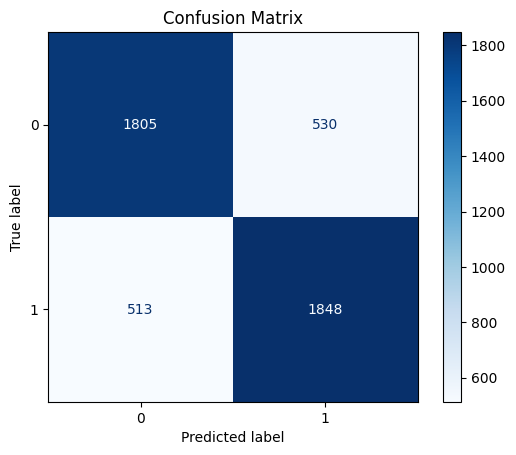

AUC: 0.8554006169127697


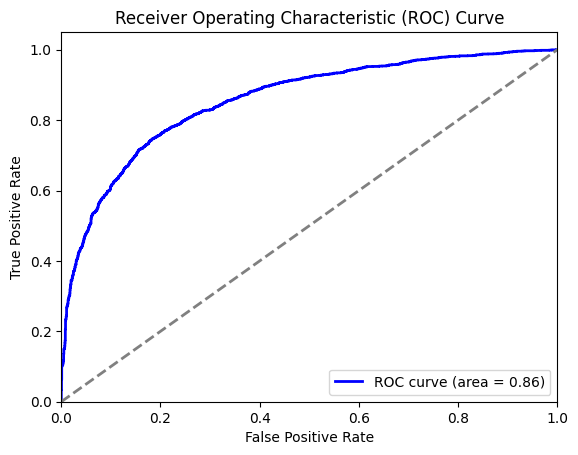

Positive Accuracy (Precision for positive class): 0.7771236333052985
Negative Accuracy (Precision for negative class): 0.7786885245901639
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Number of Hidden Layers: 2


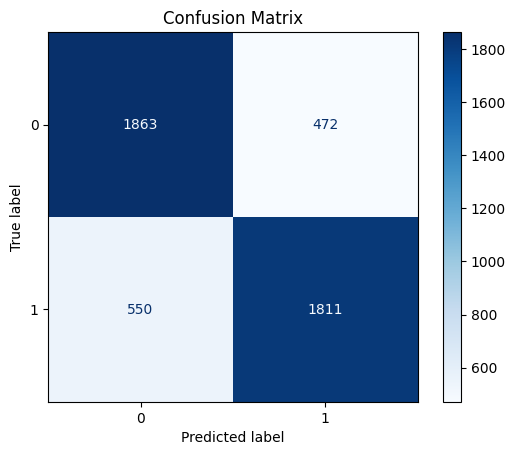

AUC: 0.857018267039245


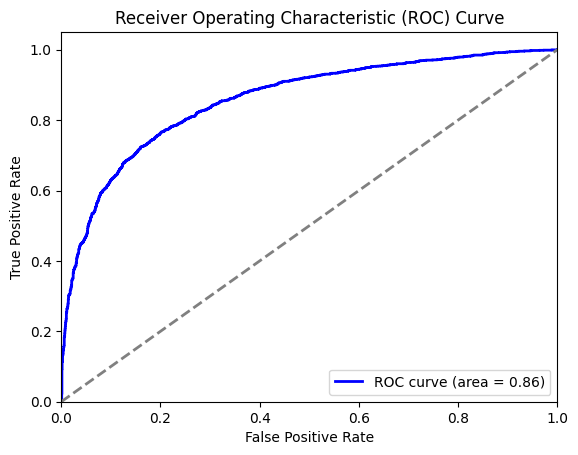

Positive Accuracy (Precision for positive class): 0.7932544897065265
Negative Accuracy (Precision for negative class): 0.7720679651885619
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Number of Hidden Layers: 3


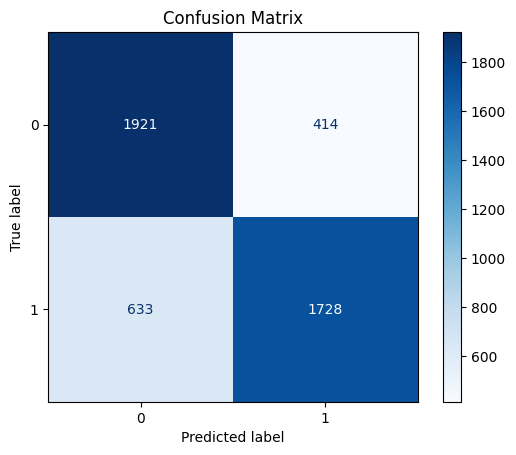

AUC: 0.8531094598430782


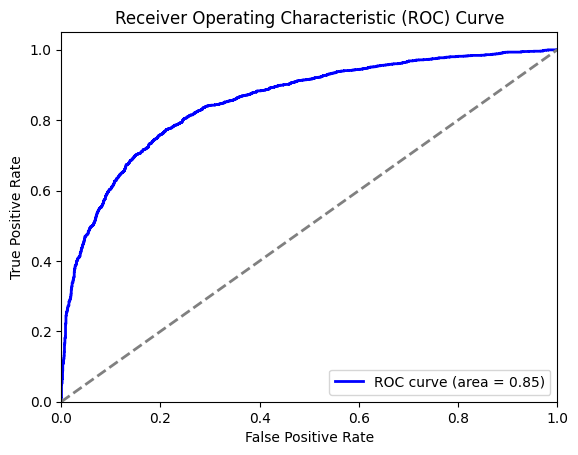

Positive Accuracy (Precision for positive class): 0.8067226890756303
Negative Accuracy (Precision for negative class): 0.7521534847298356
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Number of Hidden Layers: 4


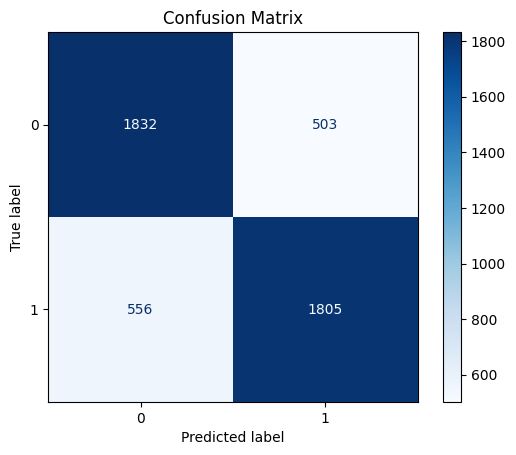

AUC: 0.8487746545170585


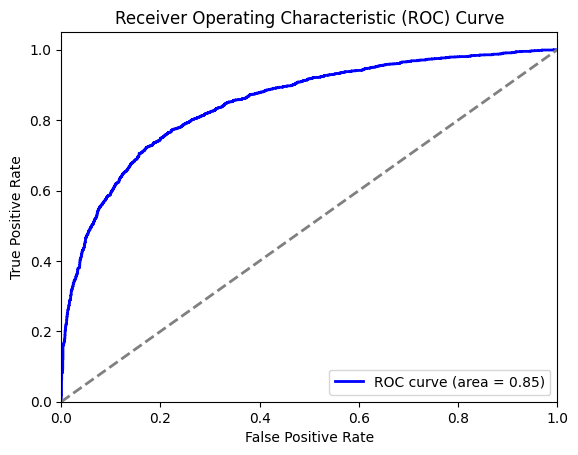

Positive Accuracy (Precision for positive class): 0.7820623916811091
Negative Accuracy (Precision for negative class): 0.7671691792294807
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Number of Hidden Layers: 5


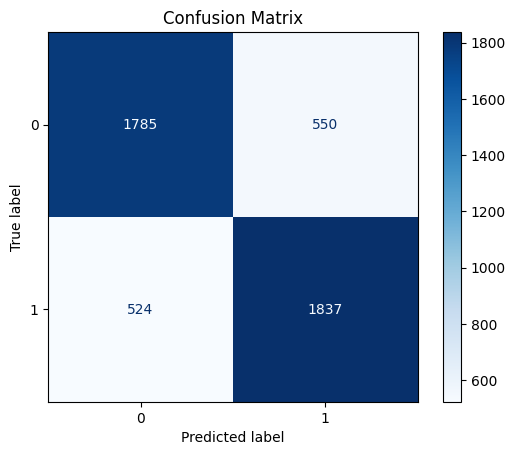

AUC: 0.8445733533952422


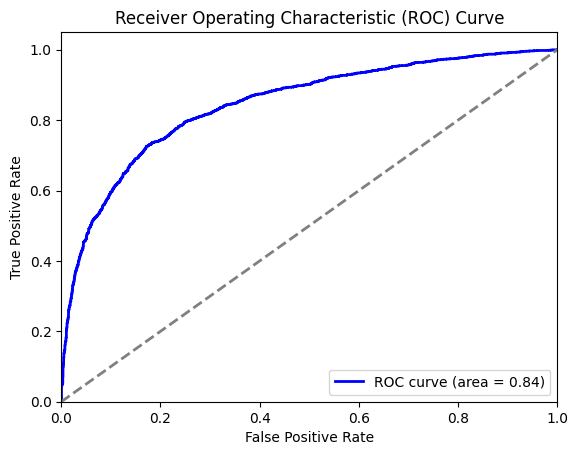

Positive Accuracy (Precision for positive class): 0.7695852534562212
Negative Accuracy (Precision for negative class): 0.7730619315721091
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Number of Hidden Layers: 6


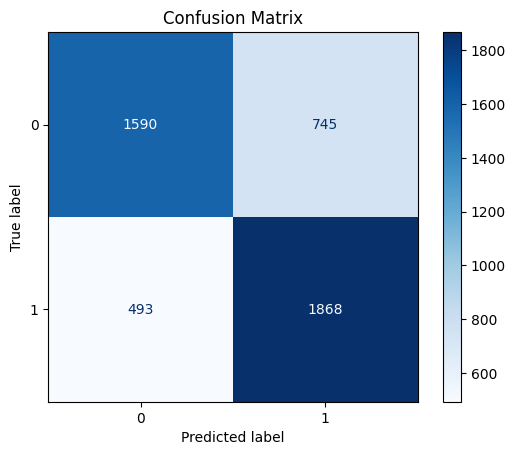

AUC: 0.8184968623791138


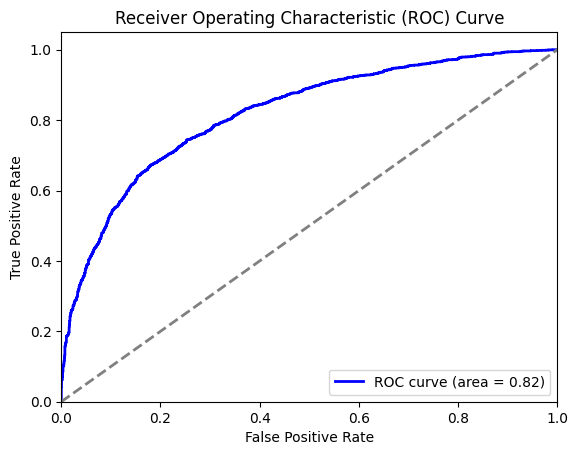

Positive Accuracy (Precision for positive class): 0.7148871029468045
Negative Accuracy (Precision for negative class): 0.7633221315410466


In [52]:
dir_path = config['model_output']['model_save_dir'] + config['date_string']+ '/' + 'test_log_'

for i in range(2,config['pathways_network']['n_hidden_layer']+2):
    print('-'*282)
    print(f'Number of Hidden Layers: {i-1}')
    result = pd.read_csv(f'{dir_path}{i}.csv',index_col=0)

    confusion_matrix_return(result)
    roc_curve_return(result)
    return_accuracy(result)

# Model Interpretation

In [53]:
# Define a hook function to capture the activations


def get_activation(name, number_of_layers, config, activations):
    def hook(model, input, output):
        # Convert output to numpy array for easier handling, but this is optional
        activations[name] = output.detach().numpy()
        
           
    return hook
def attaching_hook(model, dataloader):
    
        correct = 0
        total = 0
        predicted_list = []
        probability_list = []
        labels_list = []
        activations_list = []
        features_list = []
        criterion = nn.BCEWithLogitsLoss()
        loss = 0
        

        with torch.no_grad():  # No need to compute gradients during evaluation
            for sample_idx, (features, labels) in tqdm(enumerate(dataloader)):
                
                
                #print(labels)
                #print(features.shape)
                activations = {}
                for idx, layer in enumerate(model.layers):
                    layer_name = f'layer_{idx}'
                    number_of_layers = len(model.layers)
                    activation_hook = get_activation(layer_name, number_of_layers, config, activations)
                    
                    layer.register_forward_hook(activation_hook)
    
                outputs =  model(features)
                    #print(outputs)
                probability = torch.sigmoid(outputs.data)
                predicted = torch.round(torch.sigmoid(outputs.data))
                    #print(outputs)
                    #print(predicted)
                #loss += criterion(outputs, labels)
                    #_, predicted = torch.sigmoid(outputs.data)
                predicted_list.extend(predicted.detach().numpy())
                labels_list.extend(labels.detach().numpy())
                probability_list.extend(probability.detach().numpy())
                features_list.append(features)
                total += labels.size(0)
                x = activations
                activations_temp = activations.copy()
                activations_list.append(activations_temp)
                
                correct += (predicted == labels).sum().item()
                '''if sample_idx == 1000:
                    #print(activations_list)
                    break'''
                
            #print(total)
        accuracy = 100 * correct / total
        #print(activations_list)
        return activations_list, accuracy, predicted_list, labels_list, features_list,x
        


In [54]:

def return_feature_importance(model_dict_sparse, dataloader):
    predicted_list_dict = {}
    ground_truth_list_dict = {}
    activations_list_dict = {}
    accuracy_list_dict = {}
    for i, j in model_dict_sparse.items():
        #accuracy, loss, predicted_list, labels_list, probability_list = evaluate(j, dataloader)
        
        activations_list_dict[f'model_{i}_hidden_layers'], accuracy_list_dict[f'model_{i}_hidden_layers'], \
        predicted_list_dict[f'model_{i}_hidden_layers'], ground_truth_list_dict[f'model_{i}_hidden_layers'], \
        feature_list,x= attaching_hook(j, dataloader)
        print(f'{i} Layers: {accuracy_list_dict[f'model_{i}_hidden_layers']}')
        
    return activations_list_dict, accuracy_list_dict, predicted_list_dict, ground_truth_list_dict, feature_list,x

In [55]:

activations_list_dict, accuracy_list_dict, predicted_list_dict, ground_truth_list_dict, feature_list,x = return_feature_importance(model_dict_sparse, test_dataloader)

4696it [00:37, 124.40it/s]


2 Layers: 77.78960817717206


4696it [01:02, 74.55it/s] 


3 Layers: 78.23679727427599


4696it [01:31, 51.33it/s] 


4 Layers: 77.70442930153322


4696it [02:03, 38.14it/s] 


5 Layers: 77.4488926746167


4696it [02:35, 30.20it/s] 


6 Layers: 77.12947189097103


4696it [03:09, 24.78it/s]


7 Layers: 73.63713798977854


In [56]:
def return_feature_importance_list(activations_list_dict, model_name):
    m=0
    for k in tqdm(activations_list_dict[model_name]):
        #print(k)
        if m == 0:
            layer_dict = {key: [] for key in list(k.keys())}
        m = m+1
        
        #print(k['0_layer_0'])
        for z in list(layer_dict.keys()):
            #print(k)
            layer_dict[z].append(k[z][0])

    return layer_dict
    

In [57]:

layer_dict = return_feature_importance_list(activations_list_dict, 'model_2_hidden_layers')
layer_node_name_dict = {}
for i in range(config['pathways_network']['n_hidden_layer']+1):
    nodes_df = pd.read_csv(config['model_output']['model_save_dir'] + config['date_string'] + '/' + 'masking_df_' + \
    f'{config['pathways_network']['n_hidden_layer']-i}'+ '.csv', index_col = 0)
    layer_node_name_dict[f'layer_{i-1}'] = nodes_df.columns
    

layer_node_name_dict['final_layer'] = ['last_layer']

li = []
for i in layer_dict['layer_0']:
    li.append(list(i))
    
layer_0_df = pd.DataFrame(li,index = test_x.columns, columns=layer_node_name_dict['layer_0'])
layer_0_df

li = []
for i in layer_dict['layer_1']:
    li.append(list(i))
    
last_layer_df = pd.DataFrame(li,index = test_x.columns, columns=layer_node_name_dict['final_layer'])


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4696/4696 [00:00<00:00, 699770.90it/s]


In [59]:
layer_0_df

,R-HSA-74217_copy2,R-HSA-9660826_copy1,R-HSA-5654712,R-HSA-5663213_copy1,R-HSA-9020933_copy1,R-HSA-3315487_copy1,R-HSA-6782210_copy2,R-HSA-111957,R-HSA-8862803_copy1,R-HSA-191859_copy3,...,R-HSA-9694614_copy1,R-HSA-432720_copy2,R-HSA-77288_copy1,R-HSA-381033_copy2,R-HSA-432722_copy2,R-HSA-163680_copy3,R-HSA-1483213_copy1,R-HSA-6803204,R-HSA-9673767_copy2,R-HSA-2465910_copy1
cell_id,,,,,,,,,,,,,,,,,,,,,
CACAACATCGTCCTTG.26.2,-0.266969,-0.000063,-0.011841,0.037170,-0.007921,-0.016976,-0.037099,-0.000676,0.052700,0.055671,...,-0.010881,-0.179933,0.076090,0.000013,-0.167538,0.009255,9.910540e-07,0.000061,0.011477,-0.000111
AGCTTCCGTCTCTCTG.9.9,-0.472819,-0.000058,0.000000,0.032919,0.034935,0.021197,0.055927,0.001456,0.010851,0.115898,...,-0.021317,-0.204123,0.000000,0.000000,0.644346,-0.006855,0.000000e+00,0.000000,0.000000,0.000000
CGCCAGACAACAAGTA.17.11,-0.553419,-0.000052,-0.000922,-0.017369,0.004235,-0.022926,-0.064107,-0.004528,0.077874,0.116450,...,-0.022280,-0.123359,0.049248,0.000038,-0.180522,0.004352,2.391650e-07,0.000000,0.001120,0.000000
GGGATGATCGTAACAC.7.4,-0.389615,-0.000073,-0.024444,-0.007223,-0.064077,-0.035594,-0.086123,-0.010759,-0.100795,0.006246,...,-0.103092,-0.262173,0.000000,0.000026,-0.762814,-0.019061,3.925663e-07,0.000197,0.023523,0.000000
ACGTTCCGTATTCTCT.5.11,0.000000,-0.000142,0.000000,0.000000,0.000000,0.035574,0.000000,0.000000,0.041021,0.000000,...,0.232591,0.288058,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CATCAAGTCCTCGCAT.19.1,-0.150421,0.000000,0.000000,-0.048568,-0.104472,0.000000,0.085214,-0.017713,0.152404,0.125750,...,-0.111373,-0.150510,0.162951,0.000000,-0.247923,0.021841,0.000000e+00,0.000000,0.000000,0.000000
GTCAGCGGTCTGATAC.45.2,0.269026,-0.000050,0.004699,-0.010647,-0.003041,-0.035245,-0.085346,-0.002680,0.159890,-0.089347,...,0.081712,0.064472,0.000000,0.000000,-1.055960,0.016174,8.889596e-07,0.000000,-0.004166,-0.000232
CATGCTCAGTGTCATC.30.10,-0.485155,-0.000051,0.009119,-0.007105,-0.022431,0.005792,-0.092283,-0.001360,0.088012,0.216970,...,-0.035434,-0.131158,0.000000,0.000071,-0.904049,0.007497,0.000000e+00,0.000206,-0.008610,-0.000122


In [ ]:
layer_0_df

In [ ]:
last_layer_df

In [ ]:
y_test

In [ ]:
for i,j in predicted_list_dict.items():
    flattened_list = [item for sublist in list(predicted_list_dict[i]) for item in sublist]
    predicted_list_dict[i] = flattened_list
    

In [ ]:
predicted_list_dict['model_2_hidden_layers'][0:10]

In [ ]:
predicted_list_dict['model_4_hidden_layers'][0:10]

In [ ]:
for i,j in ground_truth_list_dict.items():
    flattened_list = [item for sublist in list(ground_truth_list_dict[i]) for item in sublist]
    ground_truth_list_dict[i] = flattened_list
    

In [ ]:
ground_truth_list_dict['model_2_hidden_layers'][0:10]

In [ ]:
ground_truth_list_dict['model_4_hidden_layers'][0:10]

In [ ]:
predicted_list_dict['model_2_hidden_layers'][0:10]

In [ ]:
layer_0_df['predicted'] = predicted_list_dict['model_2_hidden_layers']
layer_0_df['ground_truth'] = ground_truth_list_dict['model_2_hidden_layers']
layer_0_df.head()

In [ ]:
correct_predicted_layer_0_df = layer_0_df[layer_0_df.predicted == layer_0_df.ground_truth]
correct_predicted_layer_0_df_AD = correct_predicted_layer_0_df[correct_predicted_layer_0_df.predicted == 1]
correct_predicted_layer_0_df_Control = correct_predicted_layer_0_df[correct_predicted_layer_0_df.predicted == 0]

In [ ]:
combined_layer_0 = pd.concat([correct_predicted_layer_0_df_AD, correct_predicted_layer_0_df_Control])


In [ ]:
combined_layer_0['predicted'] = combined_layer_0['predicted'].replace({1: 'AD', 0: 'Control'})


In [ ]:
labels = np.array(combined_layer_0.predicted)
labels

In [ ]:
combined_layer_0 .drop(columns=['predicted','ground_truth'], inplace = True)
combined_layer_0 .head()

In [ ]:
'''pathways_list = []
p_value_list = []

for i in correct_predicted_layer_1_df_Control.columns:
    t_stat, p_value = stats.ttest_ind(correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist())
    print(f"T-statistic: {t_stat}")
    print(f"P-value: {p_value}")

    plt.figure(figsize=(8, 6))
    plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True, 
                boxprops=dict(facecolor='lightblue'))
    
    # Add title and labels
    plt.title('Box Plot of Two Distributions')
    plt.ylabel('Values')
    pathways_list.append(i)
    p_value_list.append(p_value)
    # Display the plot
    plt.show()'''
    
    

In [ ]:
import pandas as pd
import umap
import plotly.express as px
import numpy as np

# Example embeddings (let's assume these are your high-dimensional embeddings)
np.random.seed(42)
embeddings = combined_layer_0.values 
#labels = np.random.choice(['A', 'B', 'C'], size=100)  # Example labels
labels = labels
# Step 1: Reduce dimensionality using UMAP
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
umap_embeddings = reducer.fit_transform(embeddings)

# Step 2: Create a DataFrame with the reduced dimensions and labels
df_umap = pd.DataFrame({
    'UMAP1': umap_embeddings[:, 0],
    'UMAP2': umap_embeddings[:, 1],
    'Label': labels
})

# Step 3: Plot using Plotly
fig = px.scatter(
    df_umap,
    x='UMAP1',
    y='UMAP2',
    color='Label',
    title='UMAP Projection of Pathways Importance',
    labels={'UMAP1': 'UMAP Dimension 1', 'UMAP2': 'UMAP Dimension 2'}
)

# Show plot
fig.show()


In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.decomposition import PCA

# Assuming `combined_layer_0` and `labels` are already defined

# Step 1: Reduce dimensionality using PCA
pca = PCA(n_components=2)  # We want to reduce to 2 dimensions
pca_embeddings = pca.fit_transform(combined_layer_0.values)

# Step 2: Create a DataFrame with the reduced dimensions and labels
df_pca = pd.DataFrame({
    'PCA1': pca_embeddings[:, 0],
    'PCA2': pca_embeddings[:, 1],
    'Label': labels
})

# Step 3: Plot using Plotly
fig = px.scatter(
    df_pca,
    x='PCA1',
    y='PCA2',
    color='Label',
    title="Tained Model's Embedding Vector of AD and Control samples",
    labels={'PCA1': 'PCA Dimension 1', 'PCA2': 'PCA Dimension 2'},
    width=800,   # Set plot width
    height=600   # Set plot height
)

# Show plot
fig.show()


In [ ]:
embeddingfig = px.scatter(
    df_umap,
    x='UMAP1',
    y='UMAP2',
    color='Label',
    title='UMAP Projection of Pathways Importance',
    labels={'UMAP1': 'UMAP Dimension 1', 'UMAP2': 'UMAP Dimension 2'},
    width=500,   # Width of the plot in pixels
    height=6000 
)

# Show plot
fig.show()

In [ ]:
pd.DataFrame(pathways_list, p_value_list)

In [34]:

layer_dict = return_feature_importance_list(activations_list_dict, 'model_3_hidden_layers')
layer_node_name_dict = {}
for i in range(config['pathways_network']['n_hidden_layer']+1):
    nodes_df = pd.read_csv(config['model_output']['model_save_dir'] + config['date_string'] + '/' + 'masking_df_' + \
    f'{config['pathways_network']['n_hidden_layer']-i}'+ '.csv', index_col = 0)
    layer_node_name_dict[f'layer_{i-1}'] = nodes_df.columns
    

layer_node_name_dict['final_layer'] = ['last_layer']

li = []
for i in layer_dict['layer_0']:
    li.append(list(i))    
layer_0_df = pd.DataFrame(li,index = test_x.columns, columns=layer_node_name_dict['layer_0'])

li = []
for i in layer_dict['layer_1']:
    li.append(list(i)) 
layer_1_df = pd.DataFrame(li,index = test_x.columns, columns=layer_node_name_dict['layer_1'])

li = []
for i in layer_dict['layer_2']:
    li.append(list(i))   
last_layer_df = pd.DataFrame(li,index = test_x.columns, columns=layer_node_name_dict['final_layer'])


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4696/4696 [00:00<00:00, 566576.10it/s]


In [35]:
layer_1_df

,R-HSA-74217_copy2,R-HSA-264870_copy2,R-HSA-68949_copy3,R-HSA-3311021_copy2,R-HSA-446199_copy2,R-HSA-3000480_copy3,R-HSA-352230_copy3,R-HSA-9758881_copy3,R-HSA-450385_copy3,R-HSA-5619095_copy3,...,R-HSA-75035_copy3,R-HSA-399956_copy3,R-HSA-8875555_copy2,R-HSA-5358606_copy3,R-HSA-9683683_copy2,R-HSA-1169091_copy3,R-HSA-1855167_copy3,R-HSA-4755609_copy3,R-HSA-8865999_copy3,R-HSA-110320_copy2
cell_id,,,,,,,,,,,,,,,,,,,,,
CACAACATCGTCCTTG.26.2,-0.206384,-0.022933,-0.007530,0.006102,0.000000,0.022437,0.094826,-0.062603,0.002884,0.000000,...,-0.002156,-0.041897,0.048343,-0.000756,0.000286,-0.122683,-0.000583,0.000000,0.004815,0.004349
AGCTTCCGTCTCTCTG.9.9,-0.268494,-0.021670,-0.016909,-0.007050,0.000000,0.029413,0.000000,0.000000,0.004341,-0.193077,...,-0.000404,0.122997,-0.025143,0.003260,0.000000,-0.178500,-0.000767,0.000000,0.002215,0.026714
CGCCAGACAACAAGTA.17.11,-0.288181,-0.023590,-0.039942,0.008130,-0.028012,0.000000,0.406826,-0.249784,0.003288,0.000000,...,-0.000805,0.011522,-0.023420,-0.000481,0.000470,-0.190099,-0.000490,0.039424,-0.000382,0.011780
GGGATGATCGTAACAC.7.4,-0.220441,-0.026395,0.028902,0.012507,-0.018986,0.059803,0.286324,-0.358912,0.003717,0.000000,...,-0.001932,-0.075913,0.034243,0.000719,0.000144,-0.132070,-0.000450,0.026749,0.003884,-0.022246
ACGTTCCGTATTCTCT.5.11,0.000000,-0.035279,-0.241797,-0.011727,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.001115,0.000000,0.000000,0.000000,0.000000,-0.175966,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CATCAAGTCCTCGCAT.19.1,-0.122540,-0.019079,0.072193,0.000000,0.000000,0.062748,0.124062,-0.641852,0.000000,0.000000,...,-0.001943,-0.054873,0.000000,0.000000,0.001450,-0.189986,0.000000,0.000000,0.000000,0.012738
GTCAGCGGTCTGATAC.45.2,0.071272,-0.033684,0.115114,0.012659,0.000000,0.056566,0.000000,0.000000,0.001664,-0.229226,...,0.000068,-0.100011,0.021578,0.000000,0.000147,-0.099970,0.000000,0.000000,-0.000827,-0.022748
CATGCTCAGTGTCATC.30.10,-0.273554,-0.025531,-0.057226,-0.001935,0.000000,0.046478,0.341979,0.000000,0.002104,0.000000,...,-0.000693,0.027001,-0.013010,-0.000341,0.000114,-0.158894,-0.000792,0.000000,0.002248,-0.017749


In [36]:

layer_dict = return_feature_importance_list(activations_list_dict, 'model_4_hidden_layers')
layer_node_name_dict = {}
for i in range(config['pathways_network']['n_hidden_layer']+1):
    nodes_df = pd.read_csv(config['model_output']['model_save_dir'] + config['date_string'] + '/' + 'masking_df_' + \
    f'{config['pathways_network']['n_hidden_layer']-i}'+ '.csv', index_col = 0)
    layer_node_name_dict[f'layer_{i-1}'] = nodes_df.columns
    

layer_node_name_dict['final_layer'] = ['last_layer']

li = []
for i in layer_dict['layer_0']:
    li.append(list(i))    
layer_0_df = pd.DataFrame(li,index = test_x.columns, columns=layer_node_name_dict['layer_0'])

li = []
for i in layer_dict['layer_1']:
    li.append(list(i)) 
layer_1_df = pd.DataFrame(li,index = test_x.columns, columns=layer_node_name_dict['layer_1'])

li = []
for i in layer_dict['layer_2']:
    li.append(list(i)) 
layer_2_df = pd.DataFrame(li,index = test_x.columns, columns=layer_node_name_dict['layer_2'])

li = []
for i in layer_dict['layer_3']:
    li.append(list(i))   
last_layer_df = pd.DataFrame(li,index = test_x.columns, columns=layer_node_name_dict['final_layer'])


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4696/4696 [00:00<00:00, 329614.63it/s]


In [37]:
layer_2_df

,R-HSA-5632927_copy1,R-HSA-5654712,R-HSA-3315487_copy1,R-HSA-110312_copy1,R-HSA-110328,R-HSA-1169408_copy2,R-HSA-73621_copy1,R-HSA-1296061_copy2,R-HSA-8949664_copy2,R-HSA-111957,...,R-HSA-5607763_copy2,R-HSA-75035_copy2,R-HSA-2024101_copy2,R-HSA-1963642_copy2,R-HSA-9701898_copy2,R-HSA-432720_copy2,R-HSA-381033_copy2,R-HSA-432722_copy2,R-HSA-9693928_copy2,R-HSA-9673767_copy2
cell_id,,,,,,,,,,,,,,,,,,,,,
CACAACATCGTCCTTG.26.2,-1.779463e-06,2.135650e-06,-0.000025,-0.000115,-0.000807,-2.535255e-07,-2.874987e-08,0.122058,0.017138,6.763624e-09,...,-0.239046,0.292629,1.674559e-11,0.000061,3.016794e-08,0.040967,-0.000001,-0.019640,0.000099,-2.742315e-07
AGCTTCCGTCTCTCTG.9.9,-1.303893e-06,0.000000e+00,0.000022,0.000092,-0.018384,-1.010968e-06,-3.783497e-08,0.051405,-0.011307,8.908620e-09,...,-0.187369,0.292776,4.733396e-11,-0.000090,1.543970e-07,0.053201,0.000000,-0.302026,0.000000,0.000000e+00
CGCCAGACAACAAGTA.17.11,-1.132544e-06,2.168254e-06,-0.000032,-0.000050,-0.013093,1.101855e-07,0.000000e+00,0.230999,0.018599,3.683248e-09,...,-0.225574,0.262164,0.000000e+00,-0.000175,0.000000e+00,-0.007999,-0.000004,0.006338,0.000083,-4.173336e-07
GGGATGATCGTAACAC.7.4,-1.692776e-06,2.916513e-06,-0.000050,-0.000267,-0.021160,-1.211461e-06,-2.218920e-08,0.276461,0.038390,2.525202e-09,...,-0.079112,0.273439,0.000000e+00,0.000281,0.000000e+00,0.042407,-0.000003,0.207425,0.000076,-2.710982e-07
ACGTTCCGTATTCTCT.5.11,0.000000e+00,0.000000e+00,0.000037,0.000000,0.026439,0.000000e+00,0.000000e+00,0.000000,-0.017032,0.000000e+00,...,0.000000,0.105499,0.000000e+00,0.000000,0.000000e+00,-0.109196,0.000000,0.000000,0.000000,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CATCAAGTCCTCGCAT.19.1,0.000000e+00,0.000000e+00,0.000000,-0.000361,-0.020425,-2.048137e-07,0.000000e+00,0.109114,-0.008136,-7.590977e-09,...,-0.239889,0.292529,0.000000e+00,-0.000138,0.000000e+00,0.002541,0.000000,0.088449,0.000000,0.000000e+00
GTCAGCGGTCTGATAC.45.2,0.000000e+00,2.585894e-06,-0.000054,-0.000273,0.009462,-2.814105e-07,0.000000e+00,0.298077,0.047380,8.063776e-09,...,-0.217261,-0.051004,0.000000e+00,0.000295,1.314064e-07,-0.038547,0.000000,0.354956,0.000000,-5.703233e-07
CATGCTCAGTGTCATC.30.10,-8.025849e-07,3.704226e-07,0.000006,-0.000217,-0.004052,-7.891015e-07,0.000000e+00,0.118913,-0.004691,8.516487e-09,...,-0.141279,0.288898,0.000000e+00,0.000106,0.000000e+00,-0.053022,-0.000007,0.284115,0.000175,-1.873804e-07


# layer_2_df

# Plots

In [ ]:
!pwd